# Which patients would get treatment based on different ways to make the decision to give treatment (notebook 2 from set of n)
Answering a question raised from the results from notebook 210.
(see notebook 211 for three other questions)


### Plain English summary

Analyse the impact of 14 scenarios for deciding who gets treatment. How does this difference in decision making affect patient outcomes? Here we also explore different ways of defining the 'best outcome'.

The 14 scenarios (different ways of selecting which patient to give treatment to):
1. All patients are treated
1. No patients are treated
1. Actual treatment decision
1. High-benchmark treatment decision (25 hospitals with highest SHAP hospital value)
1. Low-benchmark treatment decision (25 hospitals with lowest SHAP hospital value)
1. Best weighted mRS outcome decision
1. Worst weighted mRS outcome decision
1. Best likelihood of being mRS 0-4
1. Worst likelihood of being mRS 0-4
1. Best weighted mRS and best likelihood of being mRS 0-4
1. Worse weighted mRS and worse likelihood of being mRS 0-4
1. Best weighted mRS outcome decision where everyone has door to needle of 30 mins if they are treated 
1. Only choose treatment if it improves the mRS by +0.2
1. Only choose treatment if it improves the mRS by +0.2 and not increase the likelihood of a bad outcome (>= mRS 5) [a given benefit without risk of increased risk of bad outcome]

For each scenario we set up the feature "onset-to-thrombolysis-time" depending on whether the patient gets treatment in the scenario (we make use of the decision to treat model to obtain the bechmark decision to treat). We then pass this edited X_data to the outcome model to predict the mRS distribution for each patient (given them having treatment, or not), and report the population outcome for this decision to treat scenario.

### Model and data

#### Models
This notebook uses two XGBoost models.

1) Model to predict whether get treatment 

Model: XGBoost classifier [from notebook 200]\
Target feature: Give thrombolysis\
Input features: 9 features (prior_disability, stroke_severity, stroke_team, age, onset_to_arrival_time, arrival_to_scan_time, precise_onset_known, onset_during_sleep, afib_anticoagulant)\
Kfold split: First kfold split


Note: The original thrombolysis choice model had 10 features. For this analysis, we only have ischaemic patients, and don't include anyone taking AF anticoagulants, so no need for those two related features

2) Model to predict the disability at discharge

Model: XGBoost classifier (multiclass classification) [from notebook 040]\
Target feature: Discharge disability\
Input features: 7 features (prior_disability, stroke_severity, stroke_team, age, onset_to_thrombolysis_time, any_afib_diagnosis, precise_onset_known)\
Kfold split: First kfold split

Use the model to predict each patients mRS probability distributions with/without thrombolysis (individual mRS probability, cumulative probability distributions, and weighted mRS). The scenario will determine whether the patient gets treatment. For those patients that did not get thrombolysis in the observed dataset, assume their scan-to-treatment is the median of the hospital attended.

#### Data.

Use dataset '02_reformatted_data_ml_include_mt.csv'

This analysis includes patients that are:
* Scanned within 4 hrs 15 mins of onset
* Ischaemic strokes (filter included in input dataset '02_reformatted_data_ml_include_mt.csv')
* Can have had thrombectomy (included in input dataset '02_reformatted_data_ml_include_mt.csv')

### Aims

### Observations


#### Further work
Is benchmark just really defined by people giving thtrombolysis to the large group of people with mild strokes.

Opposing approaches for giving IVT:
Not too worreid how much benefit give, just so long as not doing harm.
Or the other way is only giving it when I see there's a clear reason to.

#### Resources
pip install plotly
pip install dash

https://github.com/timyerg/venny4py?tab=readme-ov-file
https://github.com/tctianchi/pyvenn
https://pypi.org/project/venn/

## Import libraries

In [450]:
# Turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings("ignore")

import copy
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from xgboost import XGBClassifier
from sklearn.metrics import auc
from sklearn.metrics import roc_curve


from dataclasses import dataclass

from sklearn.metrics import roc_auc_score

from sklearn.metrics import confusion_matrix

%matplotlib inline

import pickle

from sklearn import metrics
from sklearn.linear_model import LinearRegression

from os.path import exists

import math

from matplotlib.ticker import MaxNLocator #force all mrs categories to be shown on the x axis

import time

# chi squared test
from scipy.stats import chi2_contingency

# for venn diagram (pip install matplotlib_venn)
# https://pypi.org/project/matplotlib-venn/
from matplotlib_venn import venn2, venn2_circles
from matplotlib_venn import venn3, venn3_circles

# for venn diagram with 3+ sets (pip install venny4py)
from venny4py.venny4py import *

# For the 3+ sets venn diagram
from itertools import combinations
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import Ellipse

# for radar plot
from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections import register_projection
from matplotlib.projections.polar import PolarAxes
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D

# Add rectangle to venn 
import matplotlib.patches as patches

Report the time duration to run notebook

In [451]:
start_time = time.time()

Set to use only the first kfold

In [452]:
k = 0

Select the features for the model to predict disability discharge

In [453]:
selected_features_mrs = ["prior_disability", "stroke_severity", "stroke_team", 
                         "age", "onset_to_thrombolysis_time", "any_afib_diagnosis", 
                         "precise_onset_known", "discharge_disability"]

Select the features for the model to predict decision to give thrombolysis

In [454]:
selected_features_treatment = ["prior_disability", "stroke_severity", 
                     "age", "arrival_to_scan_time", "precise_onset_known", 
                     "onset_to_arrival_time","onset_during_sleep", 
                     "afib_anticoagulant", "stroke_team"]

Get union of both sets of features

In [455]:
selected_features_set = list(set.union(set(selected_features_mrs), 
                                       set(selected_features_treatment)))

## Set up paths and filenames

For consistency, the folders end with "/" and the text for filenames include no trailing "_".

In [456]:
@dataclass(frozen=True)
class Paths:
    '''Singleton object for storing paths to data and database.'''
    image_save_path: str = './saved_images'
    model_save_path: str = './saved_models'
    data_save_path: str = './saved_data'
    data_read_path: str = '../data_processing/output'
    model_text: str = 'xgb_all_data_multiclass_outcome'
    notebook: str = '214_'

paths = Paths()

Create output folders if needed

In [457]:
path = paths.image_save_path
if not os.path.exists(path):
    os.makedirs(path)
        
path = paths.model_save_path
if not os.path.exists(path):
    os.makedirs(path)

path = paths.data_save_path
if not os.path.exists(path):
    os.makedirs(path)

## Import data

Read in the full dataset (not kfold splits). Include patients that may have had thrombectomy

In [458]:
# Read in training set, restrict to chosen features & store
filename = os.path.join(paths.data_read_path, 
                        '02_reformatted_data_ml_include_mt.csv')
data_all_features = pd.read_csv(filename)

## Filter patients
Keep only patients with onset to scan time of 4hours 15mins (so 15 mins to treat). This is 255 minutes.

In [459]:
mask = (data_all_features["onset_to_arrival_time"] + data_all_features["arrival_to_scan_time"]) <= 255
data_all_features = data_all_features[mask]

Store number fo patients in analysis

In [460]:
n_patients = data_all_features.shape[0]

## Store data details prior to one hot encoding

Store stroke team attended (before one hot encode it)

In [461]:
data_stroke_team = data_all_features["stroke_team"]

## Create new features

### 1. Create series "onset_to_thrombolysis_time_all_treated" for all patients.

To be used for the scenarios when patients that are not treated in the dataset are treated in the scenario (they are without a scan to treatment time, use the average for the hospital they attended)

First calculate the average scan_to_thrombolysis_time for those patients that got treated (per hospital) as then use this for those that do not get treatment.

In [462]:
# median scan to treatment for the treated patients (per hosptial)
mask_treatment = data_all_features["onset_to_thrombolysis_time"] > -100
median_scan_to_needle_time = (
    data_all_features[mask_treatment].groupby(["stroke_team"])["scan_to_thrombolysis_time"].median())

median_scan_to_needle_time.describe()

count    118.000000
mean      33.351695
std        9.763071
min       13.000000
25%       27.000000
50%       33.000000
75%       40.000000
max       75.000000
Name: scan_to_thrombolysis_time, dtype: float64

Create a new series "onset_to_thrombolysis_time_all_treated" which takes the dataset value for those patients that are treated in the dataset. For those patients that are not treated in the dataset add the median hospital scan to treatment time to their individual onset to scan times.

In [463]:
# Identify patients not recieve treatment in the dataset
mask_not_treated = data_all_features["scan_to_thrombolysis_time"] == -100

# Take a deep copy of the onset to thrombolysis time. This will remain unchanged 
# for those patients that recieve treatment in the dataset
onset_to_thrombolysis_time_all_treated = data_all_features["onset_to_thrombolysis_time"].copy(deep=True)

# For those patients not recieve treatment in the dataset, use the median scan to treatment of their attended hosptial
onset_to_scan_time = data_all_features["onset_to_arrival_time"] + data_all_features["arrival_to_scan_time"]
onset_to_thrombolysis_time_all_treated[mask_not_treated] = (
    onset_to_scan_time[mask_not_treated] + 
    median_scan_to_needle_time[data_all_features["stroke_team"]].values[mask_not_treated])

### 2. Create series "onset_to_thrombolysis_time_all_treated_30mins_d2n" for all patients.

Repeat all of the 8 scenarios as if all hospitals are able to treat patients with a 30 minute door to needle time (use patients own onset to scan times).

In [464]:
# Take a deep copy of the onset to thrombolysis time. This will remain unchanged 
# for those patients that recieve treatment in the dataset
onset_to_thrombolysis_time_all_treated_30mins_d2n = (
    data_all_features["onset_to_arrival_time"] + data_all_features["arrival_to_scan_time"] + 30)

### 3. Create series "onset_to_thrombolysis_time_all_treated_within_30mins_d2n" for all patients.

Repeat all of the 8 scenarios as if all hospitals are able to treat patients within a 30 minute door to needle time (use patients own door to needle time if < 30 minutes).

In [465]:
within_30mins_d2n = (
    np.minimum(np.array([30]*n_patients), 
               data_all_features["scan_to_thrombolysis_time"].replace(-100,9999)))

onset_to_thrombolysis_time_all_treated_within_30mins_d2n = (
                    data_all_features["onset_to_arrival_time"] + 
                    data_all_features["arrival_to_scan_time"] + 
                    within_30mins_d2n)

#### Select features to use in both models

In [466]:
data = data_all_features[selected_features_set].copy(deep=True)

# Keep a copy of this dataset to use for the histograms (before the stroke team 
# is OHE)
data_for_histogram = data.copy(deep=True)

### One hot the categorical features

Convert some categorical features to one hot encoded features.

Define a function

In [467]:
def convert_feature_to_one_hot(df, feature_name, prefix):
    """
    df [dataframe]: training or test dataset
    feature_name [str]: feature to convert to ont hot encoding
    prefix [str]: string to use on new feature
    """

    # One hot encode a feature
    df_feature = pd.get_dummies(
        df[feature_name], prefix = prefix)
    df = pd.concat([df, df_feature], axis=1)
    df.drop(feature_name, axis=1, inplace=True)

    return(df)

Set up two lists for the one hot encoding. 

A list of the feature names that are categorical and to be converted using one hot encoding.
A list of the prefixes to use for these features.

In [468]:
features_to_one_hot = ["stroke_team", "weekday"]
list_prefix = ["team", "weekday"]

For each feature in the list, for each train and test dataset, convert to one hot encoded.

In [469]:
for feature, prefix in zip(features_to_one_hot, list_prefix):
    if feature in selected_features_set:
        data = convert_feature_to_one_hot(data, feature, prefix)

Feature names with one hot encoding

In [470]:
feature_names_ohe = list(data)

Extract the team names

In [471]:
ohe_stroke_team_features = [col for col in feature_names_ohe if col.startswith('team')]

Update the feature names to use in the model (remove "stroke_team" and add in all the one hot encoded feature names)

In [472]:
# replace the column name "stroke_team" with the ohe column names
selected_features_mrs_ohe = selected_features_mrs
selected_features_mrs_ohe.remove("stroke_team")
selected_features_mrs_ohe.extend(ohe_stroke_team_features)

# replace the column name "stroke_team" with the ohe column names
selected_features_treatment_ohe = selected_features_treatment
selected_features_treatment_ohe.remove("stroke_team")
selected_features_treatment_ohe.extend(ohe_stroke_team_features)

Get set of the features for both models (wtih ohe features)

In [473]:
selected_features_set_ohe = list(set.union(set(selected_features_mrs_ohe), 
                                       set(selected_features_treatment_ohe)))

# Discharge disability outcome multiclass model

Get data for features for the outcome model

In [474]:
data_outcome = data[selected_features_mrs_ohe]

In [475]:
feature_names_ohe = list(data_outcome)
feature_names_ohe.remove("discharge_disability")
n_features_ohe = len(feature_names_ohe)

## Edit data
### Divide into X (features) and y (labels)
We will separate out our features (the data we use to make a prediction) from our label (what we are trying to predict).
By convention our features are called `X` (usually upper case to denote multiple features), and the label (disability discharge) `y`.

In [476]:
X_outcome = data_outcome.drop('discharge_disability', axis=1)
y_outcome = data_outcome['discharge_disability']

## Load XGBoost model multiclass classification model for discharge disability
From notebook 040

In [477]:
def load_xgboost_model(filename):
    """
    Given the filename, either load if the model exists (saved as a pickle), 
    else train a new model.

    Args:
        filename [string]: where xgboost model is saved
        X_train [dataframe]: feature values
        y_train [dataframe]: target feature
        
    Returns:
        model [object]: xgboost classifier model

    """
    # Check if exists
    file_exists = exists(filename)

    if file_exists:
    # Load models
        with open(filename, 'rb') as filehandler:
            model = pickle.load(filehandler)
    else:
        # Print error
        print("Run notebook 040 first to train the model")
    return(model)

In [478]:
# Model filename
filename = os.path.join(paths.model_save_path, 
                ('040_xgb_7_features_5fold_0.p'))

model_outcome = load_xgboost_model(filename)

Define function to calculate the population outcome (from the individual patient mRS probabilities)

In [479]:
def calculate_population_outcome(y_probs, mrs_classes):
    weighted_mrs = (y_probs * mrs_classes).sum(axis=1)
    return(np.average(weighted_mrs),weighted_mrs)

Extract the classes from the multiclass model

In [480]:
mrs_classes = model_outcome.classes_

# Read in the results for the 14 scenarios for deciding which patients get treatment

For this analysis, use this patient population:
* Scanned within 4 hrs 15 mins of onset
* Ischaemic stroke
* Not taking anticolgalents
* Not recieve thrombectomy

The 14 scenarios (different ways of selecting which patient to give treatment to):
1. All patients are treated
1. No patients are treated
1. Actual treatment decision
1. High-benchmark treatment decision
1. Low-benchmark treatment decision
1. Best weighted mRS outcome decision
1. Worst weighted mRS outcome decision
1. Best likelihood of being mRS 0-4
1. Worst likelihood of being mRS 0-4
1. Best weighted mRS and best likelihood of being mRS 0-4
1. Worse weighted mRS and worse likelihood of being mRS 0-4
1. Best weighted mRS outcome decision where everyone has door to needle of 30 mins if they are treated 
1. Only choose treatment if it improves the mRS by +0.2
1. Only choose treatment if it improves the mRS by +0.2 and not increase the likelihood of a bad outcome (>= mRS 5) [a given benefit without risk of increased risk of bad outcome]

For each scenario we set up the feature "onset-to-thrombolysis-time" depending on whether the patient gets treatment in the scenario (we make use of the decision to treat model to obtain the bechmark decision to treat). We then pass this edited X_data to the outcome model to predict the mRS distribution for each patient (given them having treatment, or not), and report the population outcome for this decision to treat scenario.

Read in data from first notebook in this set (from notebook 210)

In [481]:
# Read in as numpy array
filename = os.path.join(paths.data_save_path, 
    ('210_' + paths.model_text + '_y_outcome_probs_all_treated.p'))

with open(filename, 'rb') as filehandler:
    y_outcome_probs_all_treated = pickle.load(filehandler)

# Read in as numpy array
filename = os.path.join(paths.data_save_path, 
    ('210_' + paths.model_text + '_y_outcome_probs_none_treated.p'))

with open(filename, 'rb') as filehandler:
    y_outcome_probs_none_treated = pickle.load(filehandler)

In [482]:
filename = os.path.join(paths.data_save_path, 
                ('210_' + paths.model_text + '_dict_of_dataframes.p'))

# Save using pickle
with open(filename, 'rb') as filehandler:
    dict_dataframes = pickle.load(filehandler)

filename = os.path.join(paths.data_save_path, 
                ('210_' + paths.model_text + '_dict_of_scen_full_names.p'))

# Save using pickle
with open(filename, 'rb') as filehandler:
    dict_scenario_information = pickle.load(filehandler)

In [483]:
df_treatment_decision_per_scenario = dict_dataframes["df_treated"]
df_weighted_mrs_per_scenario = dict_dataframes["df_weighted_mrs"]
df_mrs6_per_scenario = dict_dataframes["df_likelihood_mrs6"]
df_mrs5_6_per_scenario = dict_dataframes["df_likelihood_mrs5_6"]

# Question 4 (of 4) to ask of the results seen in notebook 210. 
## Are there patients that the high benchmarks are giving thrombolysis to, that they shouldn’t (and so could be causing harm)?

Looking at whether the benchmark hosptials are making the best decisions.

This question is comparing the agreement in which patients are treated between two scenarios: High benchmark decision, vs best outcome decision. We will compare benchmark with the five different scenarios for "best outcome" (which have different levels of caution) and defined as giving treatment if the patient has a:
* lower weighted mRS
* reduction in weighted mRS by 0.2
* reduction in the likelihood of a bad outcome (mRS5+)
* lower weighted mRS and a reduction in the likelihood of a bad outcome (mRS5+)
* reduction in weighted mRS by 0.2 and a reduction in likelihood of a bad outcome (mRS5+)

We will present the agreement in treatment decisions between the scenarios using venn diagrams.

The most conservative scenario requires a threshold for the improvement (without increasing bad outcome). The least conservative best outcome scenario requires any improvement (but could increase the likelihood of harm), or vice versa, a scenario that gives treatment if not increase a bad outcome (without an increased likelihood for improvement).

By providing these various definitions for "best outcome" in the web app, we move away from reporting that "the computer says this". It instead gives various options that are beneficial, and allows the clincian to choose their level of risk vs benefit.

Define a function to create a Venn diagram that shows the agreement in which patients get treatment across 2 (or 3) scenarios.

Option to pass/return the ax so to be included as a subplot in a figure.

In [484]:
def create_venn_diagram(df_treatment_decision_per_scenario, 
                        venn_diagram_columns, venn_diagram_xticks,
                        filename="", title_prefix="", title_suffix="", ax=None,
                        represent_as_100=False):
    
    """
    df_treatment_decision_per_scenario []: 
    venn_diagram_columns []:
    venn_diagram_xticks []:
    filename []:
    title_prefix []:
    title_suffix []:
    ax []:
    represent_as_100 [boolean]:
    
    """
    # Put data in required format for venn diagram (a list of sets, with each set
    # containing the patient index numbers that recieve IVT in that scenario)

    total = df_treatment_decision_per_scenario.shape[0]

    # Initialise lists
    list_vd_sets = []
    labels = []

    ax = ax or plt.gca()

    # For each scenario to be shown in the venn diagram
    for col, label in zip (venn_diagram_columns, venn_diagram_xticks):
        # Mask those patients that get treatment in that scenario
        mask = df_treatment_decision_per_scenario[col]==1
        list_vd_sets.append(set(df_treatment_decision_per_scenario[mask].index))
        count_ivt = df_treatment_decision_per_scenario[col].sum()
        if represent_as_100:
            count_ivt = (count_ivt/total)*100
        labels.append(label +  f"\n({count_ivt:.0f} patients)")

    if len(venn_diagram_columns) == 2:
        # Create venn diagram
        if represent_as_100:
            venn2(list_vd_sets, labels, set_colors=('yellow', 'deepskyblue'), 
                alpha = 0.7,
                subset_label_formatter=lambda x: f"{((x/total)*100):.0f}");
        else:
            venn2(list_vd_sets, labels, set_colors=('yellow', 'deepskyblue'), alpha = 0.7);

        venn2_circles(list_vd_sets, linewidth=0.5, color='k');

    elif len(venn_diagram_columns) == 3:
        if represent_as_100:
            venn3(list_vd_sets, labels, set_colors=('yellow', 'deepskyblue', 'mediumorchid'), 
                alpha = 0.7,
                subset_label_formatter=lambda x: f"{((x/total)*100):.0f}");
        else:
            venn3(list_vd_sets, labels, set_colors=('yellow', 'deepskyblue', 'mediumorchid'), alpha = 0.7);
        venn3_circles(list_vd_sets, linewidth=0.5, color='k');
    
    else:
        print("Can only plot venn with 2 or 3 subgroups")

    # Calculate the number of patients treated across any scenario
    mask = df_treatment_decision_per_scenario[venn_diagram_columns].sum(axis=1) > 0
    n_patients_treated_any = mask.sum()

    # Calculate the number of patients not treated across any scenario
    mask = df_treatment_decision_per_scenario[venn_diagram_columns].sum(axis=1) == 0
    n_patients_not_treated_any = mask.sum()

    if represent_as_100:
        n_patients_not_treated_any = str(int((n_patients_not_treated_any / total) * 100)) + " patients"
        n_patients_treated_any = str(int((n_patients_treated_any / total) * 100)) + " patients"

    # Add title
    plt.title(f"{title_prefix}* {n_patients_treated_any} patients treated in any scenario"
            f"\n* {n_patients_not_treated_any} patients not treated in any scenario"
            f"\n{title_suffix}", fontsize=18, pad=30)
    
    if len(filename)>0:
        plt.savefig(filename, dpi=300)

    return(ax)


show agreement of patients treated in the high benchmark decision vs the five different scenarios for "best outcome".

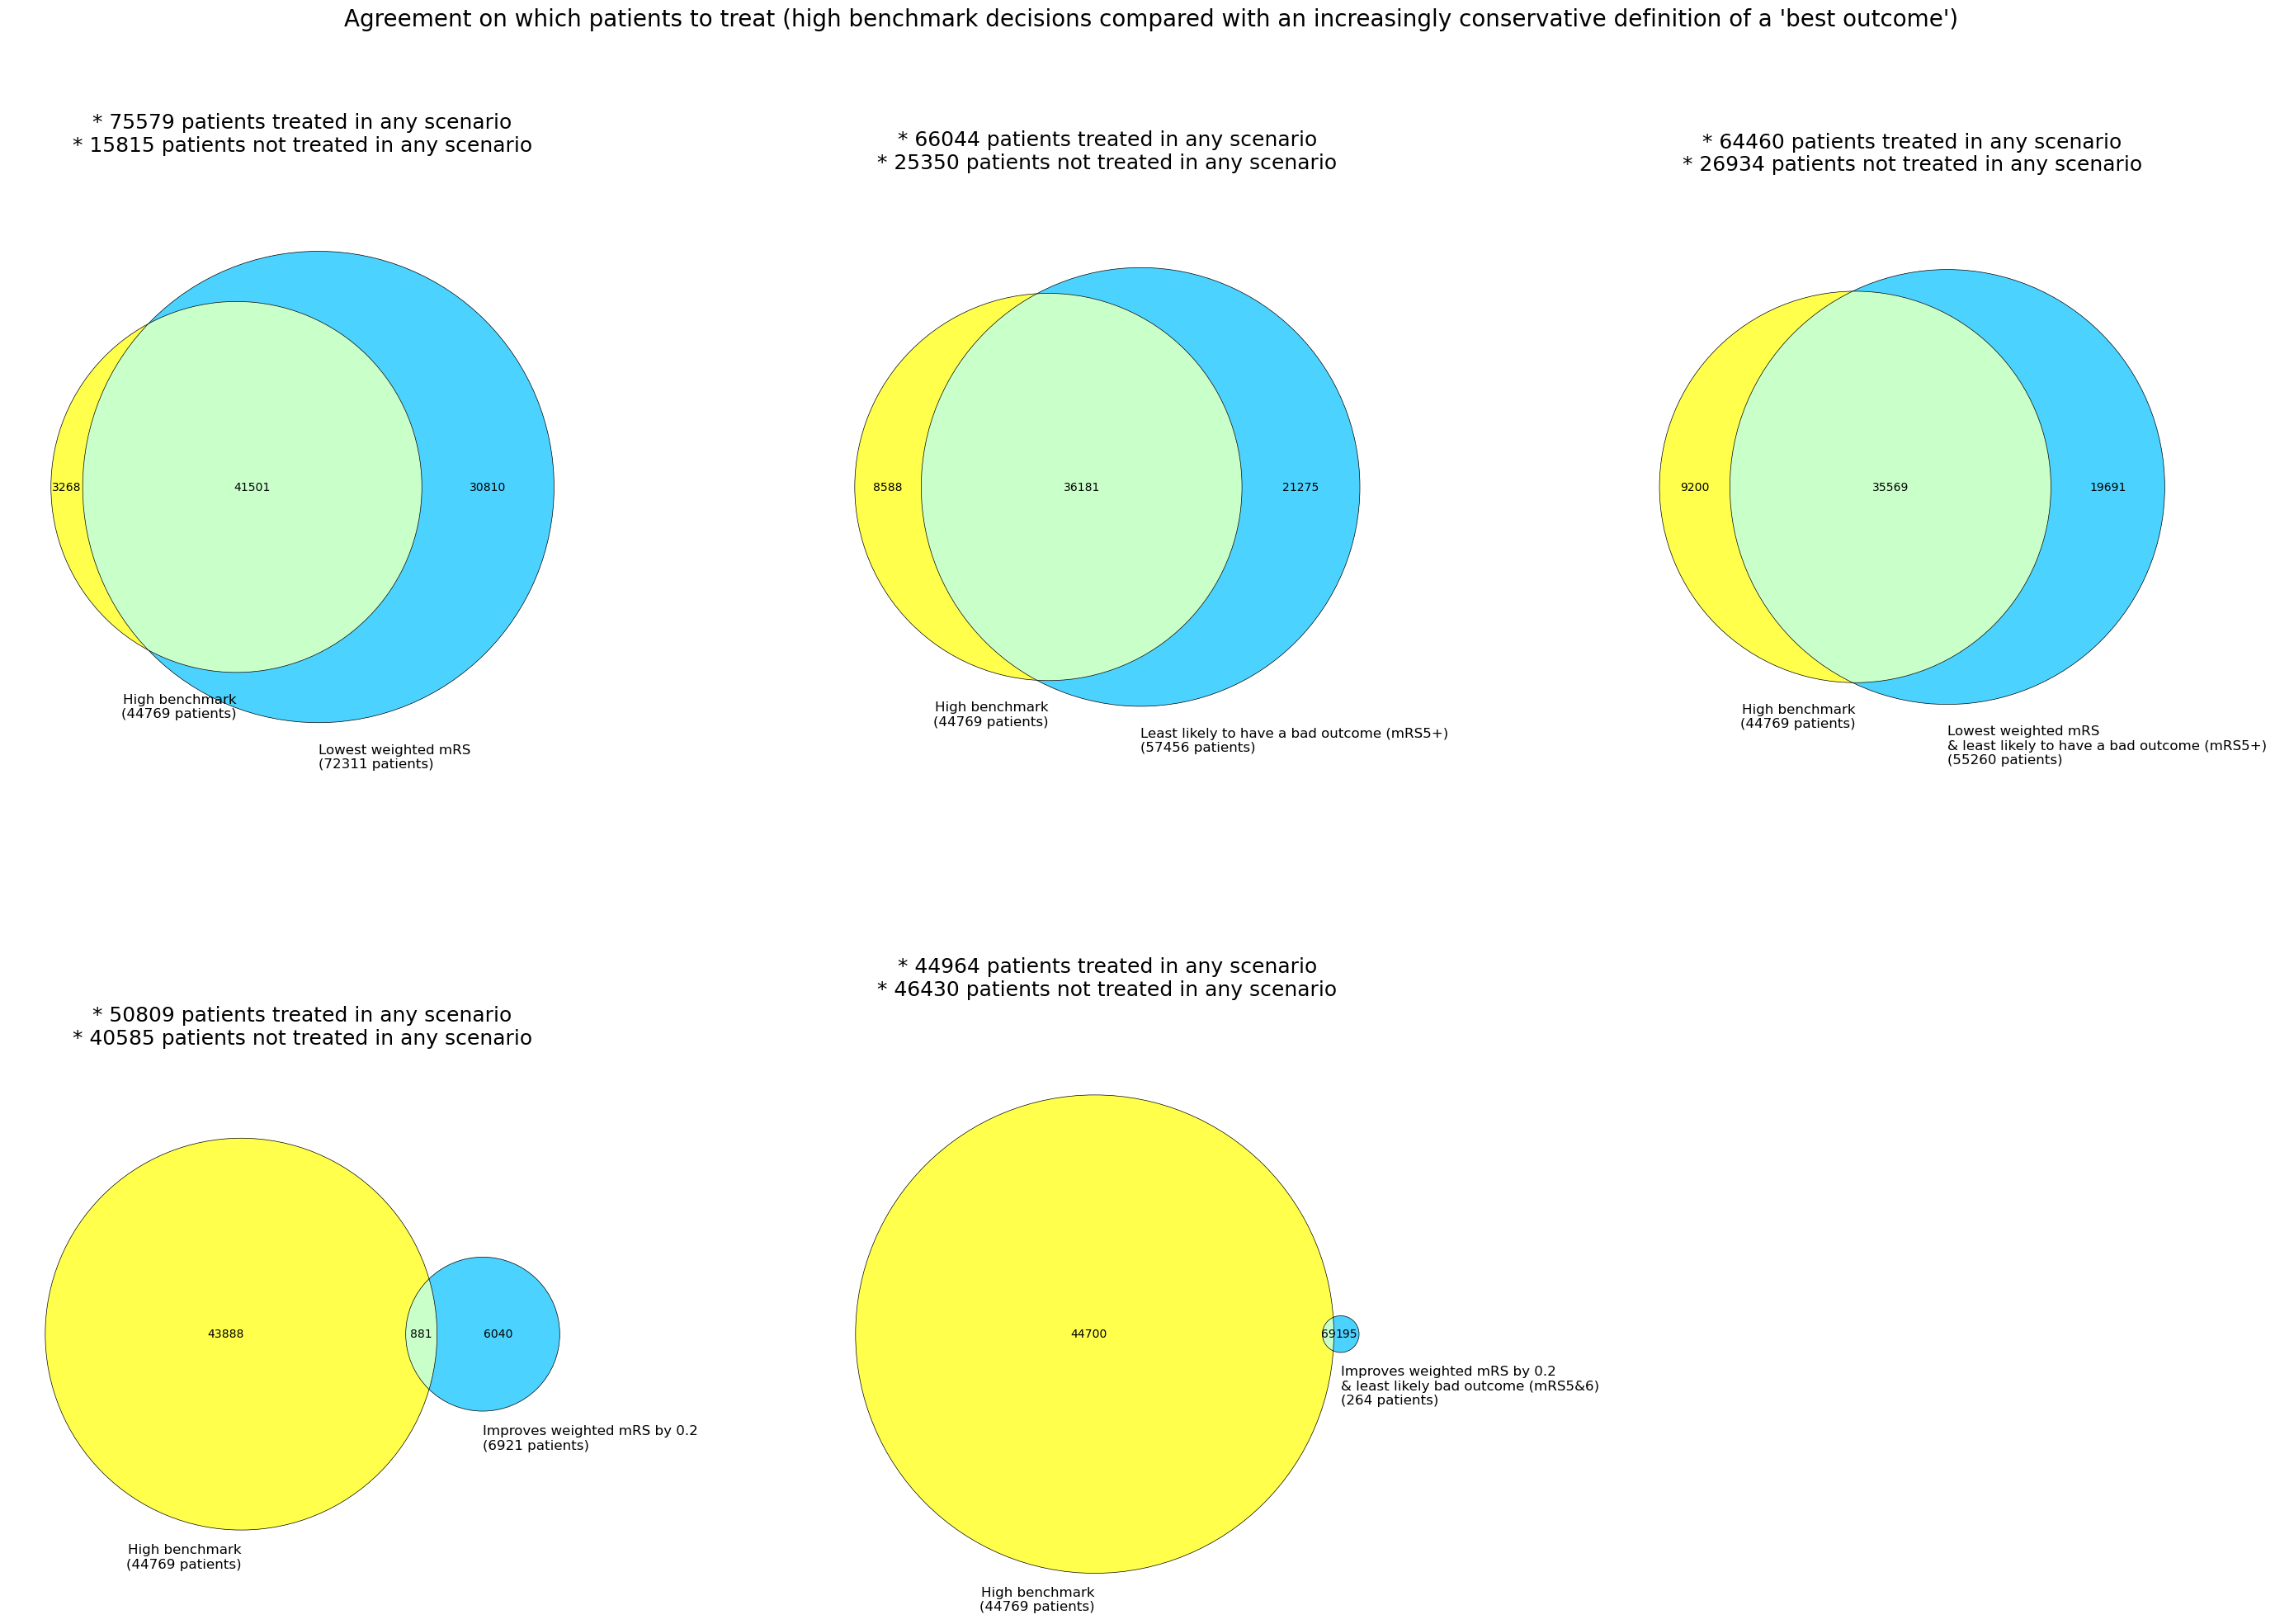

In [485]:
list_venn_diagram_columns = [["High_benchmark", "Lowest_weighted_mrs"],
                             ["High_benchmark", "Least_mrs5_6"],
                             ["High_benchmark", "Lowest_weighted_mrs_and_least_mrs5_6"],
                             ["High_benchmark", "Weighted_mrs_threshold_improvement"],
                             ["High_benchmark", "Weighted_mrs_threshold_improvement_and_least_mrs5_6"]]
list_xticks = []
for venn_diagram_columns in list_venn_diagram_columns:
    xticks = [dict_scenario_information[f"{col_name}_full_name"] for col_name in venn_diagram_columns]
    list_xticks.append(xticks)

fig = plt.figure(figsize=(28,22))

fig.suptitle("Agreement on which patients to treat (high benchmark decisions compared with an increasingly conservative definition of a 'best outcome')", fontsize=20)

for subplot, (venn_diagram_columns, xticks) in enumerate(zip(list_venn_diagram_columns, list_xticks)):
    ax1 = fig.add_subplot(2,3,subplot+1)

    create_venn_diagram(df_treatment_decision_per_scenario, 
                        venn_diagram_columns, xticks, ax=ax1, represent_as_100=False)
    
  
fig.tight_layout()

filename = os.path.join(paths.image_save_path, 
                        (paths.notebook + paths.model_text + 
                        f'_venn_diagram_{len(venn_diagram_columns)}scenarios.jpg'))

plt.savefig(filename, dpi=300)

Same figure, displaying values as per 100 patients.

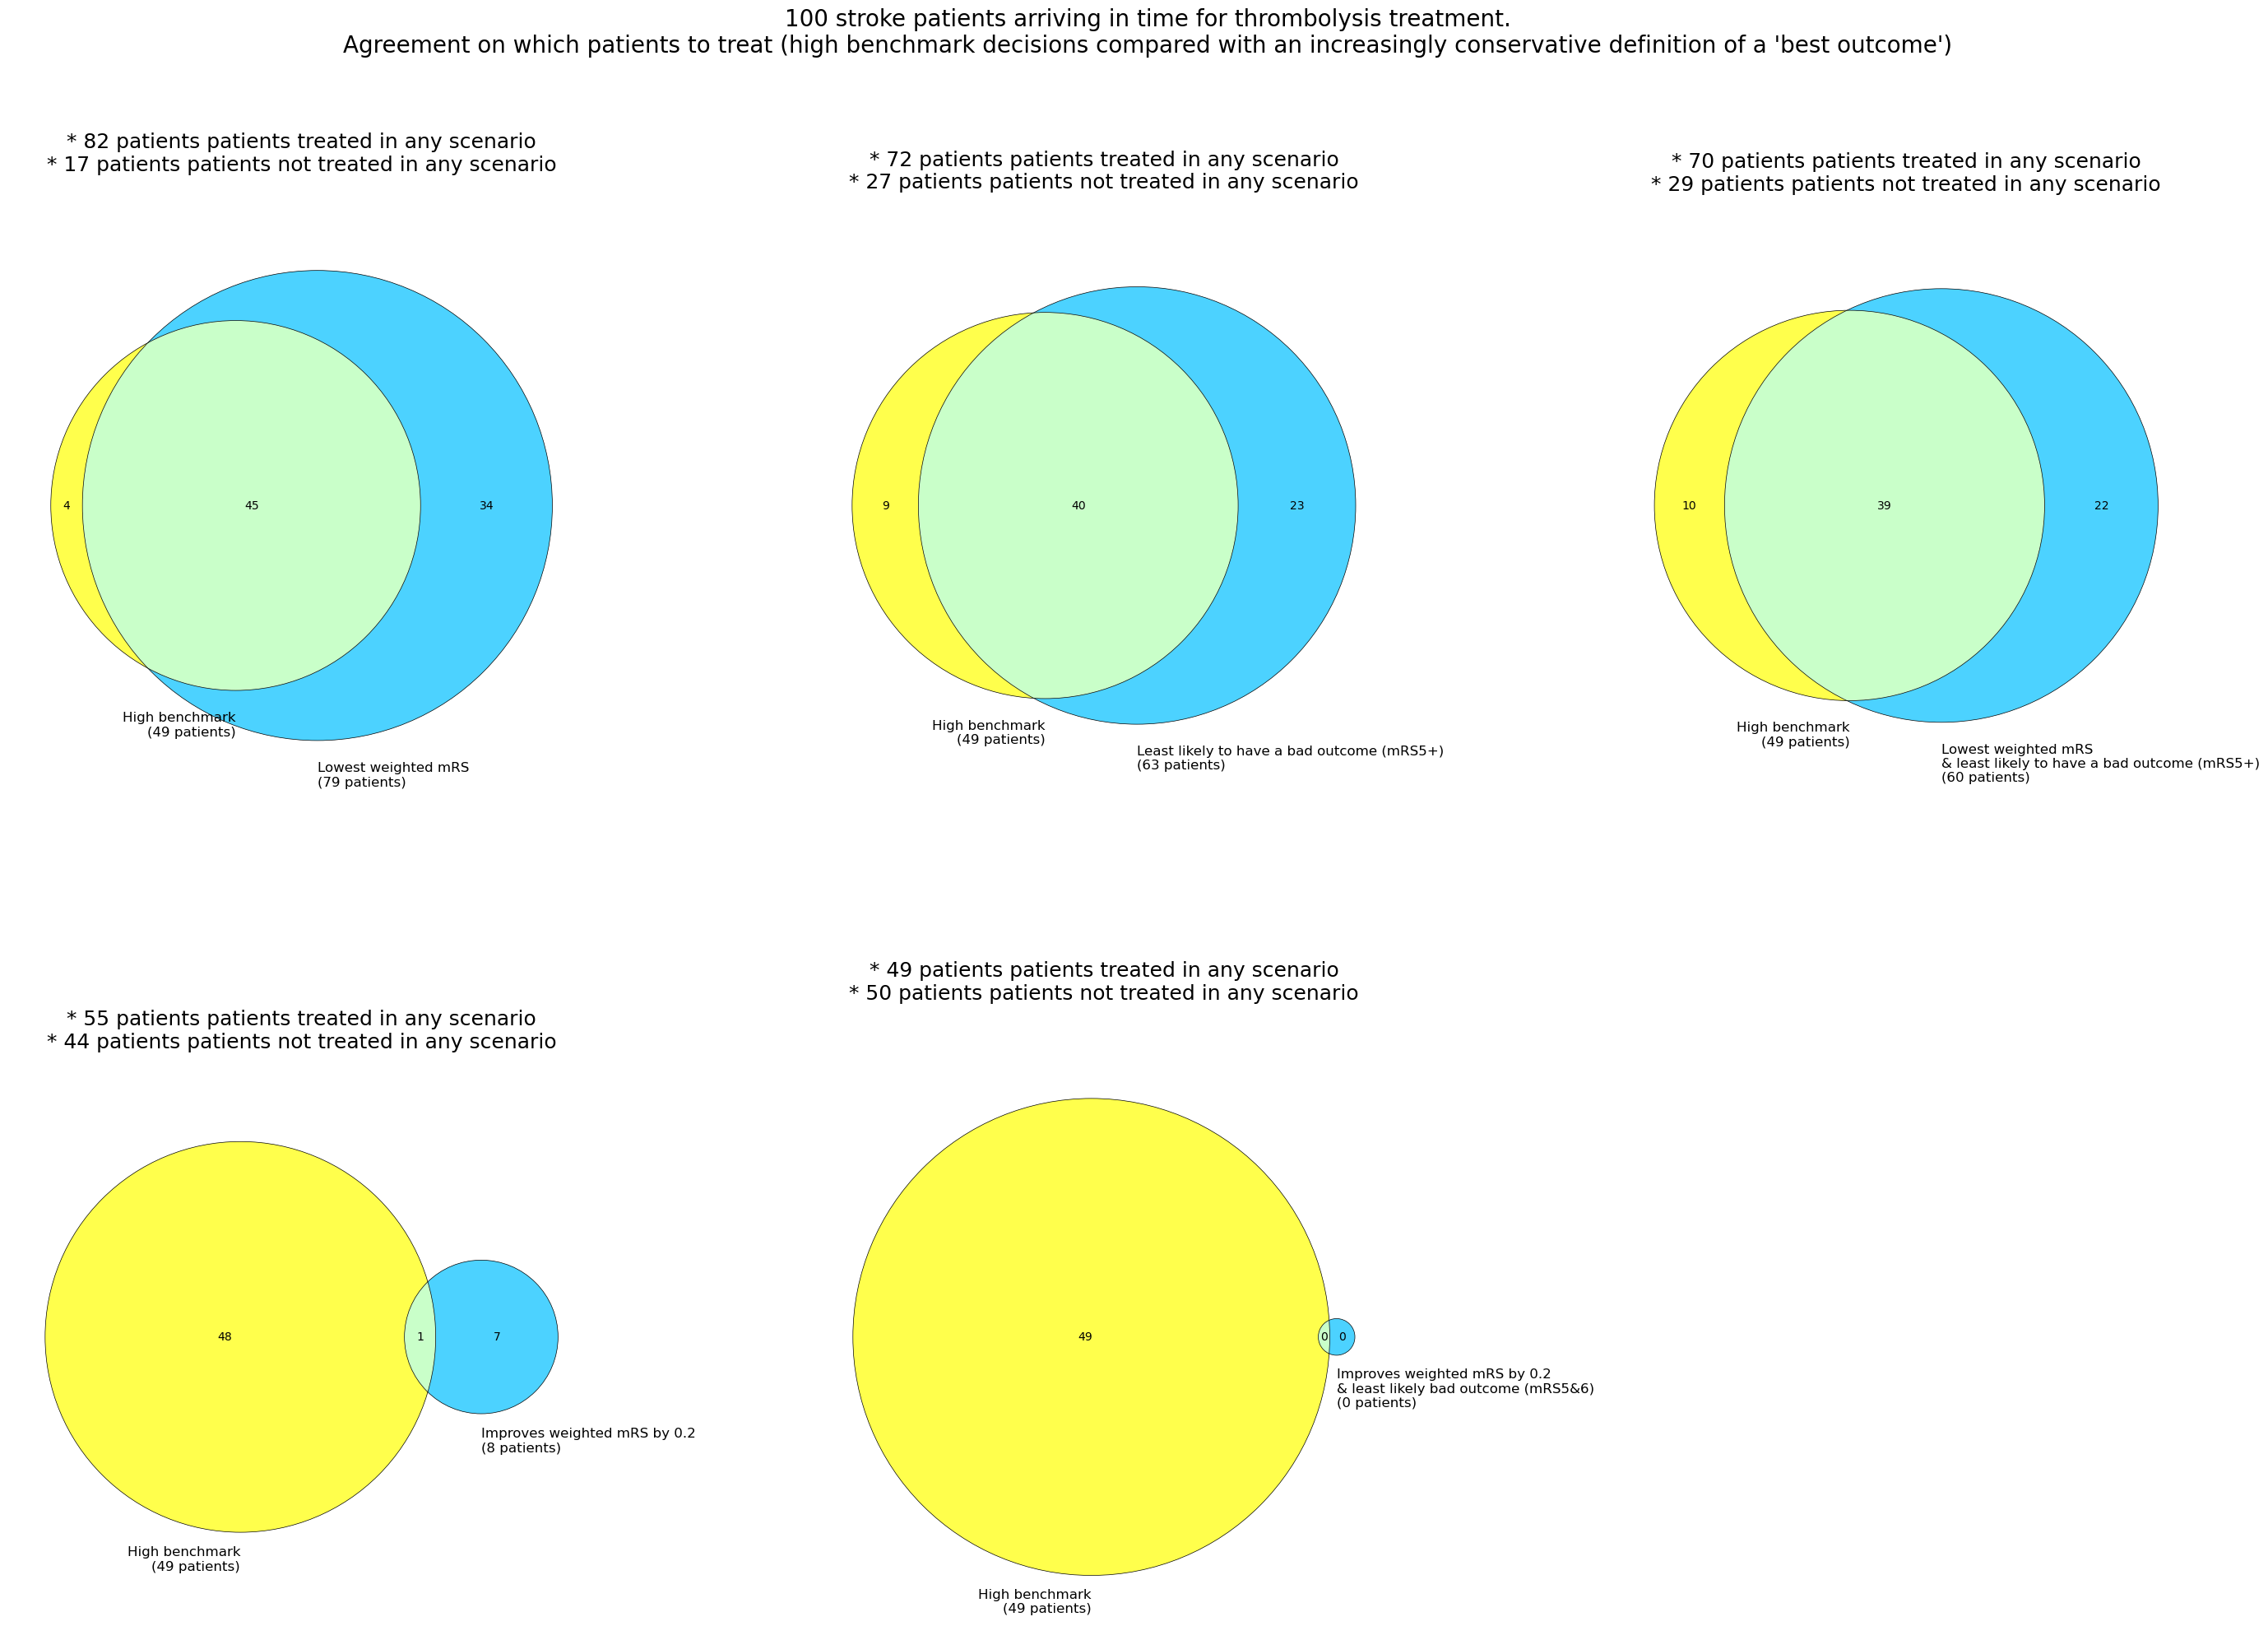

In [486]:
list_venn_diagram_columns = [["High_benchmark", "Lowest_weighted_mrs"],
                             ["High_benchmark", "Least_mrs5_6"],
                             ["High_benchmark", "Lowest_weighted_mrs_and_least_mrs5_6"],
                             ["High_benchmark", "Weighted_mrs_threshold_improvement"],
                             ["High_benchmark", "Weighted_mrs_threshold_improvement_and_least_mrs5_6"]]
list_xticks = []
for venn_diagram_columns in list_venn_diagram_columns:
    xticks = [dict_scenario_information[f"{col_name}_full_name"] for col_name in venn_diagram_columns]
    list_xticks.append(xticks)

fig = plt.figure(figsize=(28,22))

fig.suptitle("100 stroke patients arriving in time for thrombolysis treatment."
             "\nAgreement on which patients to treat (high benchmark decisions "
             "compared with an increasingly conservative definition of a "
             "'best outcome')", fontsize=20)

for subplot, (venn_diagram_columns, xticks) in enumerate(zip(list_venn_diagram_columns, list_xticks)):
    ax1 = fig.add_subplot(2,3,subplot+1)

    create_venn_diagram(df_treatment_decision_per_scenario, 
                        venn_diagram_columns, xticks, ax=ax1, represent_as_100=True)
    
  
fig.tight_layout()

filename = os.path.join(paths.image_save_path, 
                        (paths.notebook + paths.model_text + 
                        f'_venn_diagram_{len(venn_diagram_columns)}scenarios.jpg'))

plt.savefig(filename, dpi=300)

Leads us to ask, what are the differences in the patient characteristics between those getting treated in the different scenarios?

Which patients are the benchmark decisions choosing to treat that the model predicts there would not be an improvement (identfy the patient cohort to inform the hospitals to leave alone).
Which patients are the benchmark decisions choosing not to treat that the model predicts there would be an improvement (identfy the patient cohort to inform the hospitals to choose ot treat).

For this use the definitnion for 'best outcome' as 'Lower weighted mRS and a reduction in the likelihood of a bad outcome (mRS5+)'. How do we identify the 9200 patients that the benchmark decision shouldn't treat, and the 19691 patients that we should treat.

Can we unpick any patient characteristics where the benchmark decision to treat but the outcome scenario does not, and vice versa, can we also unpick any patient characteristics where benchmark hospitals do not treat, but the outcome scenario does?

In [487]:
def create_histogram_figures(df_treatment_decision_per_scenario,
                             data_for_histogram,
                             selected_features_set,
                             scenario_columns,
                             scenarios_short_name,
                             scenarios_full_name=""):

    # mask of the patients treated across any scenario
    either_mask = (df_treatment_decision_per_scenario[scenario_columns].sum(axis=1) > 0).values

    # mask of the patients treated in bm
    s1_mask = (df_treatment_decision_per_scenario[scenario_columns[0]] > 0).values

    # mask of the patients treated in outcome
    s2_mask = (df_treatment_decision_per_scenario[scenario_columns[1]] > 0).values

    # mask of the patients treated in bm only
    s1_only_mask = (s1_mask == 1) & (s2_mask == 0)

    # mask of the patients treated in outcome
    s2_only_mask = (s1_mask == 0) & (s2_mask == 1)

    # mask of the patients treated in both scenario
    both_mask = (df_treatment_decision_per_scenario[scenario_columns].sum(axis=1) == 2).values

    mask_patients = [either_mask, both_mask, s1_only_mask, s2_only_mask]

    labels = [f"Either scenario (n = {int(either_mask.sum())})", 
            f"Both scenarios (n = {int(both_mask.sum())})",
            f"'{scenarios_short_name[0]}' only (n = {int(s1_only_mask.sum())})", 
            f"'{scenarios_short_name[1]}' only (n = {int(s2_only_mask.sum())})" 
            ]

    n_subplots = len(labels)
    n_cols = 2
    n_rows = int(n_subplots/n_cols)

    for feat in selected_features_set:
        fig, axes = plt.subplots(n_rows, n_cols)

        plt.text(x=0.5, y=0.94, s=f"Feature: {feat}", fontsize=14, ha="center", transform=fig.transFigure)
        plt.text(x=0.5, y=0.89, s=f"Comparing scenarios: '{scenarios_short_name[0]}' vs '{scenarios_short_name[1]}'", fontsize=12, ha="center", transform=fig.transFigure)
        if len(scenarios_full_name)>0:
            plt.text(x=0.5, y=0.85, s=f"[where '{scenarios_short_name[1]}' is '{scenarios_full_name[1]}'", fontsize=8, ha="center", transform=fig.transFigure)

        # For each set of patients (all, bm, both, outcome)
        for (mask, label, ax) in zip(mask_patients, labels, axes.flatten()):
            if feat == "onset_to_thrombolysis_time":
                counts, bins = np.histogram(data_for_histogram[feat][mask])
                ax.hist(bins[:-1], bins, weights=counts)
            else:
                x = data_for_histogram[mask].groupby([feat]).count().index
                y = data_for_histogram[mask].groupby([feat]).count().iloc[:,0].values
                ax.bar(x,y)

            if feat == "stroke_team":
                ax.set_xticklabels([]);
            ax.set_title(label, fontsize=10)
            if data_for_histogram[feat].nunique() == 2:
                ax.set_xticks([0,1])

        plt.subplots_adjust(top=0.75, wspace=0.3, hspace=0.5)
        plt.show()
    return()

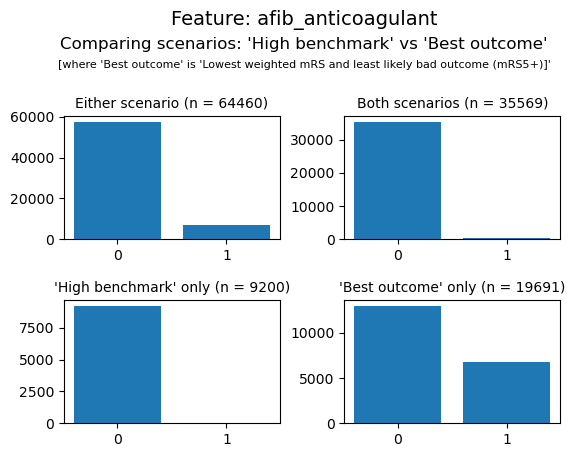

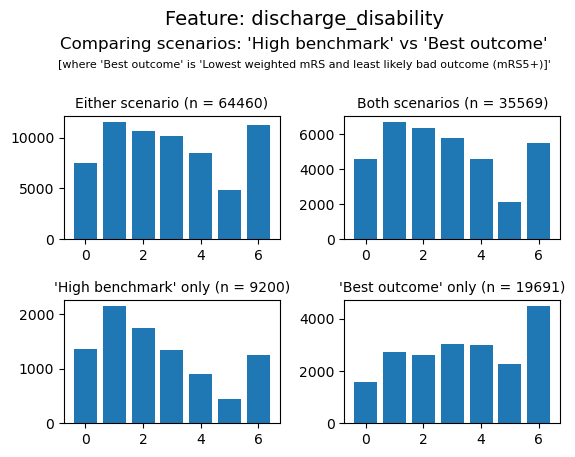

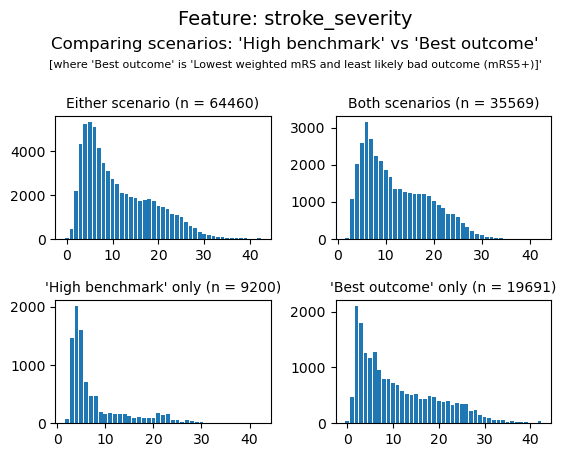

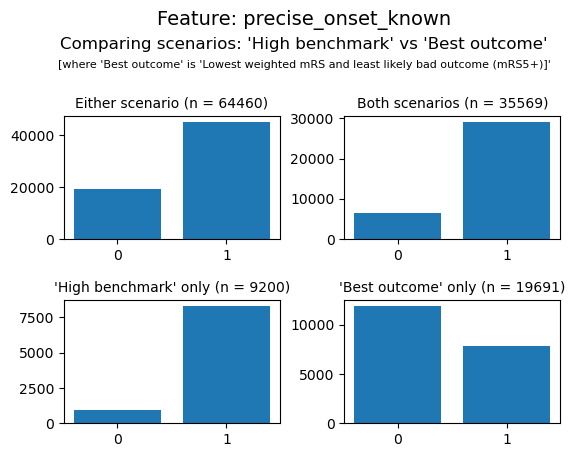

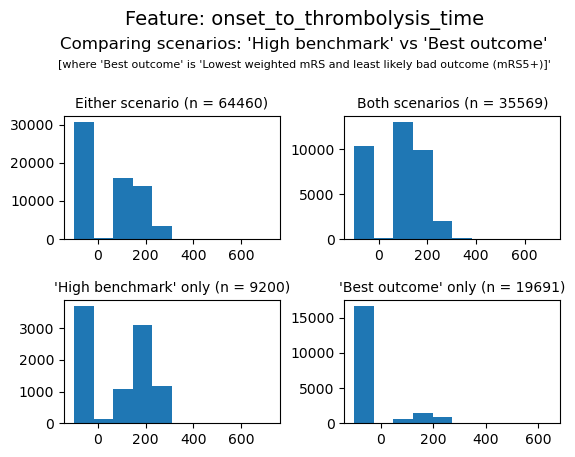

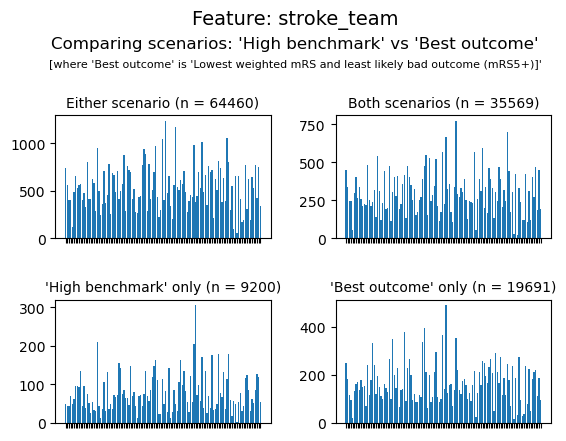

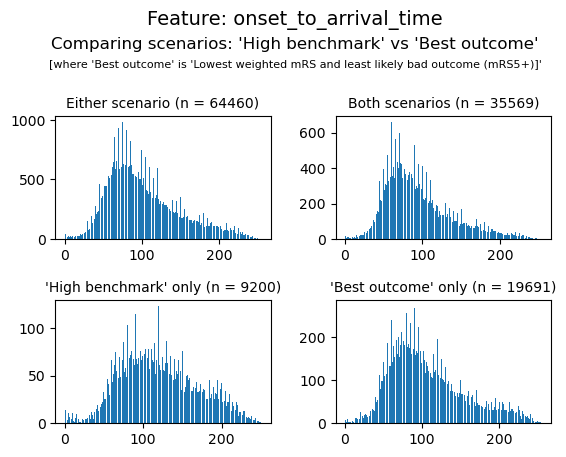

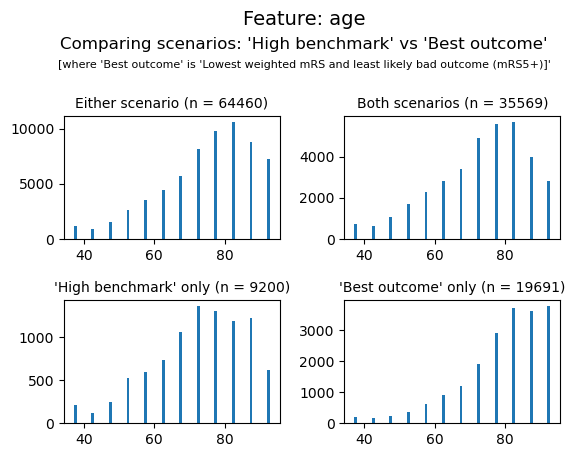

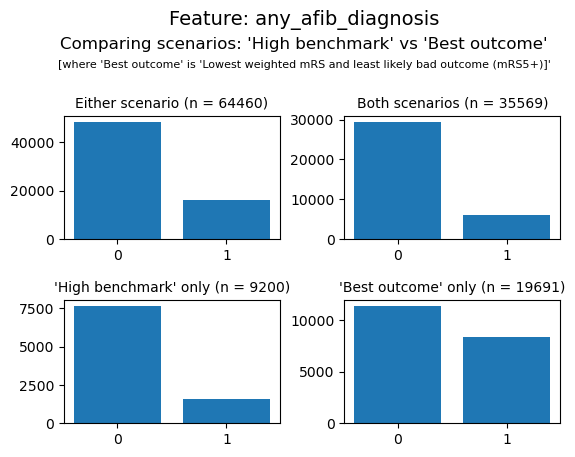

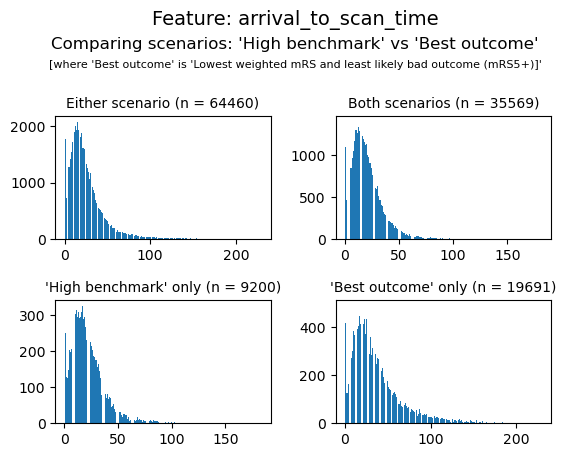

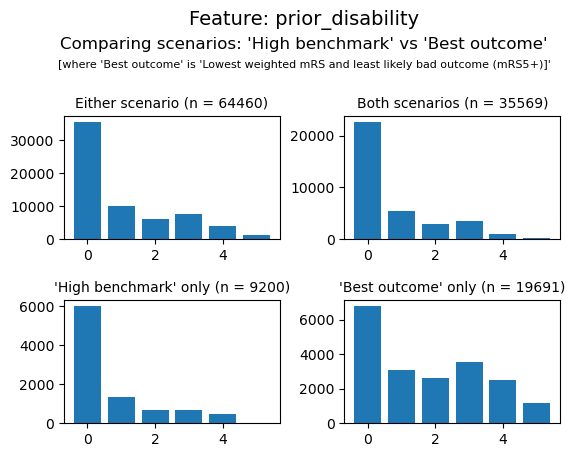

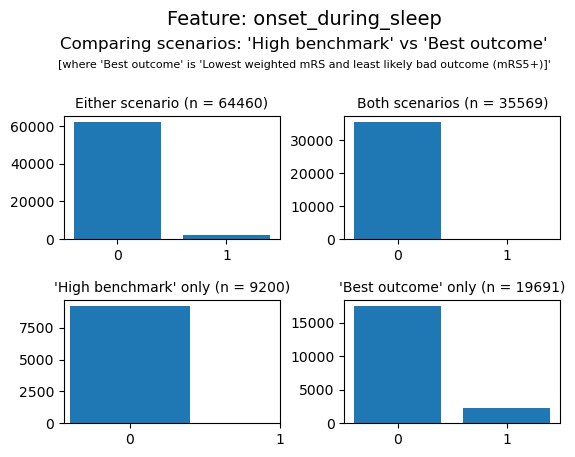

()

In [488]:
scenarios_columns = ["High_benchmark", "Lowest_weighted_mrs_and_least_mrs5_6"]
#xticks = [dict_scenario_information[f"{col_name}_full_name"] for col_name in scenarios_columns]
scenarios_short_name = ["High benchmark", "Best outcome"]
scenarios_full_name = ["High benchmark", 
                       "Lowest weighted mRS and least likely bad outcome (mRS5+)]"]

create_histogram_figures(df_treatment_decision_per_scenario, 
                         data_for_histogram,
                         selected_features_set,
                         scenarios_columns, 
                         scenarios_short_name,
                         scenarios_full_name)

Run two experiments.

1. Of the patients that should get treated (the population sample), fit a model to predict if each patient is treated from the patient characteristics. See the difference in the patients between the two groups. What's different for those patients that are not treated, but should.

2. Of the patients that should not get treated (the population sample), fit a model to predict if each patient is treated from the patient characteristics. See the difference in the patients between the two groups. What's different for those patients that are treated, but should not be.

In [489]:
filename = os.path.join(paths.data_save_path, 
                        '210_xgb_all_data_multiclass_outcome_onset_to_thrombolysis_time_all_treated.csv')

onset_to_thrombolysis_time_all_treated = pd.read_csv(filename)

In [490]:
# Create mask to extract the population sample: should get treated
mask_should_treat = df_treatment_decision_per_scenario["Lowest_weighted_mrs_and_least_mrs5_6"].astype(bool).values

# Get the X data
X = data_outcome[mask_should_treat].copy(deep=True)

X["onset_to_thrombolysis_time"] = onset_to_thrombolysis_time_all_treated["onset_to_thrombolysis_time"][mask_should_treat].values

# Get the y data
y = df_treatment_decision_per_scenario["High_benchmark"][mask_should_treat].values


### Fit logistic regression model

Train model to predict the patients that got treatment (by the high benchmark decision).

Create function to create train and test set.

In [491]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

## Logistic regression (with standardised values)

In [492]:
def standardise_data(X_train, X_test):
    """
    Converts all data to a similar scale.
    Standardisation subtracts mean and divides by standard deviation
    for each feature.
    Standardised data will have a mena of 0 and standard deviation of 1.
    The training data mean and standard deviation is used to standardise both
    training and test set data.
    """
    
    # Initialise a new scaling object for normalising input data
    sc = StandardScaler() 

    # Set up the scaler just on the training set
    sc.fit(X_train)

    # Apply the scaler to the training and test sets
    train_std=sc.transform(X_train)
    test_std=sc.transform(X_test)
    
    return (train_std, test_std)

In [493]:
(X_train, X_test, y_train, y_test) = train_test_split(X, y, test_size = 0.25)

(X_train_std, X_test_std) = standardise_data(X_train, X_test)

In [494]:

# Set up and fit model
model_lr_std = LogisticRegression(solver='lbfgs')
model_lr_std.fit(X_train_std,y_train)

# Predict training and test set labels
pred_y_train_lr_std = model_lr_std.predict(X_train_std)
pred_y_test_lr_std = model_lr_std.predict(X_test_std)

# Calculate accuracy of training and test sets
accuracy_train_lr_std = np.mean(pred_y_train_lr_std == y_train)
accuracy_test_lr_std = np.mean(pred_y_test_lr_std == y_test)

print ('Accuracy of predicting training data =', accuracy_train_lr_std)
print ('Accuracy of predicting test data =', accuracy_test_lr_std)

Accuracy of predicting training data = 0.7959705633972735
Accuracy of predicting test data = 0.7995656894679696


Confusion matrix

In [495]:
def plot_cm(cm):

    fig, ax = plt.subplots(1,1)

    # Visualize the confusion matrix with colors
    heatmap = ax.imshow(cm, cmap=plt.cm.Blues, origin='lower')
    plt.colorbar(heatmap, ax=ax, alpha=0.5, label='Count')

    # Add values to plot
    for i in range(len(cm)):
        for j in range(len(cm[0])):
            ax.text(j, i, cm[i][j], ha='center', va='center', color='grey', 
                    size=8)

    # Set axis titles
    ax.set_xlabel('Predicted value')
    ax.set_ylabel('Observed value')

    return()

()

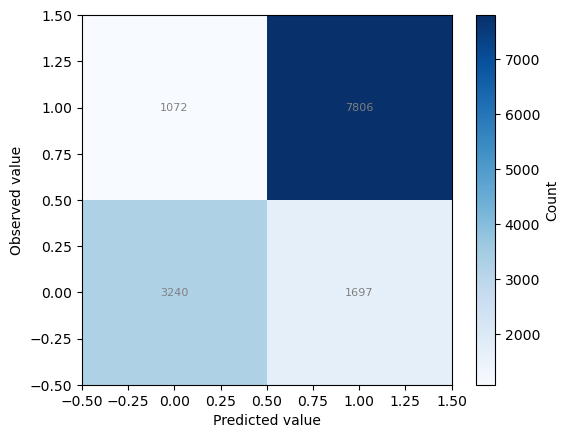

In [496]:
plot_cm(confusion_matrix(y_test, pred_y_test_lr_std))

In [497]:
def create_coefficient_df(model, feature_names):
    coeff = model.coef_[0]
    coeff_df = pd.DataFrame() # create empty DataFrame
    coeff_df['feature'] = feature_names # Get feature names from X
    coeff_df['coeff'] = coeff
    coeff_df['abs_coeff'] = np.abs(coeff)
    coeff_df.sort_values(by='abs_coeff', ascending=False, inplace=True)
    return(coeff_df)

In [498]:
coeff_lr_std_df = create_coefficient_df(model_lr_std, list(X))
coeff_lr_std_df.head(20)

,feature,coeff,abs_coeff
5,precise_onset_known,1.009984,1.009984
0,prior_disability,-0.766851,0.766851
4,any_afib_diagnosis,-0.717036,0.717036
1,stroke_severity,0.670522,0.670522
3,onset_to_thrombolysis_time,-0.432156,0.432156
2,age,-0.138573,0.138573
6,discharge_disability,-0.090816,0.090816
57,team_Northampton General Hospital,0.076351,0.076351
90,team_Salisbury District Hospital,-0.070952,0.070952
113,team_West Wales General,0.070133,0.070133


In [499]:
# Show first ten predicted probabilities 
# (note how the values relate to the classes predicted above)
probabilities_lr_std = model_lr_std.predict_proba(X_test_std)
probabilities_lr_std[0:10]

array([[0.09270055, 0.90729945],
       [0.10849723, 0.89150277],
       [0.09349913, 0.90650087],
       [0.32353611, 0.67646389],
       [0.10012058, 0.89987942],
       [0.05402121, 0.94597879],
       [0.16347278, 0.83652722],
       [0.03872061, 0.96127939],
       [0.16962643, 0.83037357],
       [0.23521905, 0.76478095]])

Receiver operating characteristic (ROC) Curve
We calculate the ROC curve by adjusting the probability cut-off (the probability cut-off of someone surviving in order to classify them as a survivor). Here we create a loop with cut-off probabilities in the range 0-1 in steps of 0.01. We do not need to refit the model – we take the same prediction probabilities output and apply varying cut-off thresholds to that output.

Calculating area of ROC
A common measurement from the ROC curve is to measure the area under the curve. A model that performs no better than guessing by random chance will have an area of 0.5. A perfect model will have an area of 1.0.
sklearn has a method for calculating the ROC area-under-curve, that we will use.

In [500]:
# Define a function for plotting the ROC curve
def plot_roc_curve(fpr, tpr):  
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate (Sensitivity)')
    roc_auc = auc(fpr, tpr)
    plt.title(f'Receiver Operator Characteristic (ROC) Curve\n[ROCAUC: {roc_auc:0.3}]')
    plt.grid(True)
    plt.legend()
    plt.show()
    return()

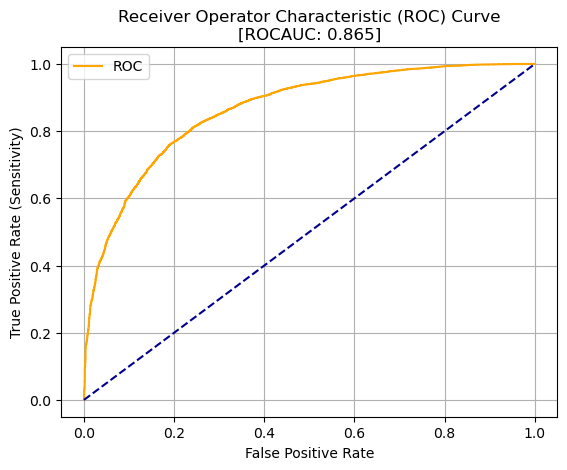

()

In [501]:
# Get ROC curve using sklearn method
fpr, tpr, thresholds = roc_curve(y_test, probabilities_lr_std[:,1]) 

# Plot ROC curve
plot_roc_curve(fpr, tpr)

## Logistic regression (with untransformed values)

In [502]:
# Set up and fit model
model_lr = LogisticRegression(solver='lbfgs')
model_lr.fit(X_train,y_train)

# Predict training and test set labels
y_pred_train_lr = model_lr.predict(X_train)
y_pred_test_lr = model_lr.predict(X_test)

# Calculate accuracy of training and test sets
accuracy_train = np.mean(y_pred_train_lr == y_train)
accuracy_test = np.mean(y_pred_test_lr == y_test)

print ('Accuracy of predicting training data =', accuracy_train)
print ('Accuracy of predicting test data =', accuracy_test)

Accuracy of predicting training data = 0.793823139100012
Accuracy of predicting test data = 0.7997104596453131


()

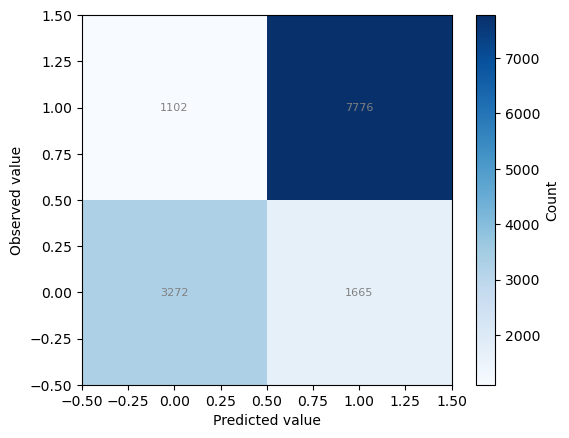

In [503]:
plot_cm(confusion_matrix(y_test, y_pred_test_lr))

In [504]:
coeff_lr_df = create_coefficient_df(model_lr, list(X))
coeff_lr_df.head(20)

,feature,coeff,abs_coeff
5,precise_onset_known,2.134423,2.134423
4,any_afib_diagnosis,-1.770184,1.770184
0,prior_disability,-0.583087,0.583087
57,team_Northampton General Hospital,0.111829,0.111829
90,team_Salisbury District Hospital,-0.093162,0.093162
1,stroke_severity,0.090326,0.090326
23,team_East Surrey Hospital,-0.084561,0.084561
54,team_Norfolk and Norwich University Hospital,-0.083694,0.083694
121,team_Wycombe General Hospital,0.078364,0.078364
26,team_Fairfield General Hospital,0.072517,0.072517


In [505]:
# Show first ten predicted probabilities 
# (note how the values relate to the classes predicted above)
probabilities_lr = model_lr.predict_proba(X_test)
probabilities_lr[0:10]

array([[0.08088944, 0.91911056],
       [0.07422827, 0.92577173],
       [0.11669151, 0.88330849],
       [0.34125839, 0.65874161],
       [0.07720581, 0.92279419],
       [0.05374427, 0.94625573],
       [0.12836587, 0.87163413],
       [0.04470486, 0.95529514],
       [0.18677417, 0.81322583],
       [0.17248996, 0.82751004]])

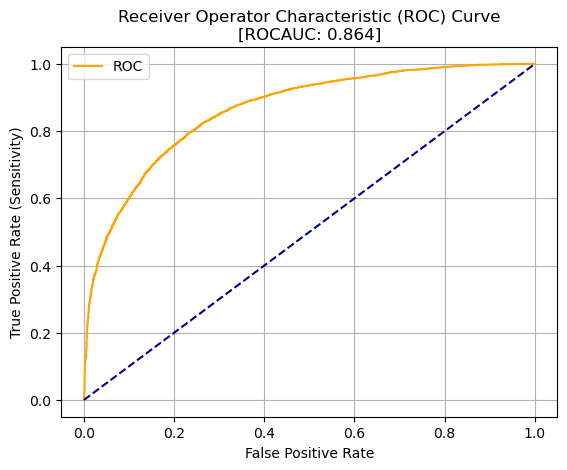

()

In [506]:
# Get ROC curve using sklearn method
fpr, tpr, thresholds = roc_curve(y_test, probabilities_lr[:,1]) 

# Plot ROC curve
plot_roc_curve(fpr, tpr)

### XGBoost

In [507]:
# Set up and fit model
model_xgb = XGBClassifier(verbosity=0, seed=42, learning_rate=0.5,
                              tree_method='gpu_hist')
model_xgb.fit(X_train, y_train)

# Predict training and test set labels
y_pred_train = model_xgb.predict(X_train)
y_pred_test = model_xgb.predict(X_test)

# Calculate accuracy of training and test sets
accuracy_train = np.mean(y_pred_train == y_train)
accuracy_test = np.mean(y_pred_test == y_test)

print ('Accuracy of predicting training data =', accuracy_train)
print ('Accuracy of predicting test data =', accuracy_test)

Accuracy of predicting training data = 0.9036795753408131
Accuracy of predicting test data = 0.8503076366268548


()

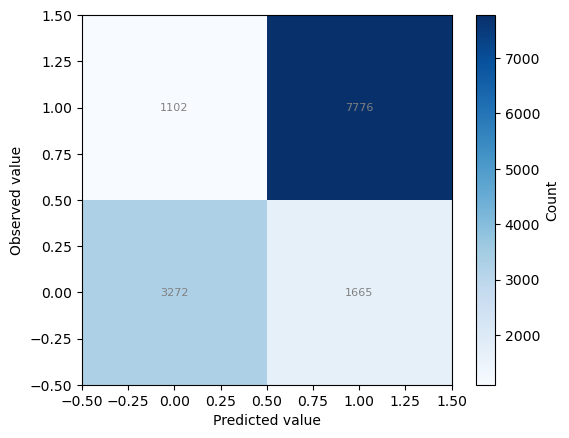

In [508]:
plot_cm(confusion_matrix(y_test, y_pred_test_lr))

In [509]:
# Show first ten predicted probabilities 
# (note how the values relate to the classes predicted above)
probabilities_xgb = model_xgb.predict_proba(X_test)
probabilities_xgb[0:10]

array([[0.01929319, 0.9807068 ],
       [0.0288496 , 0.9711504 ],
       [0.00774139, 0.9922586 ],
       [0.11303443, 0.8869656 ],
       [0.00793111, 0.9920689 ],
       [0.01046425, 0.98953575],
       [0.00893492, 0.9910651 ],
       [0.00592548, 0.9940745 ],
       [0.10644859, 0.8935514 ],
       [0.19481409, 0.8051859 ]], dtype=float32)

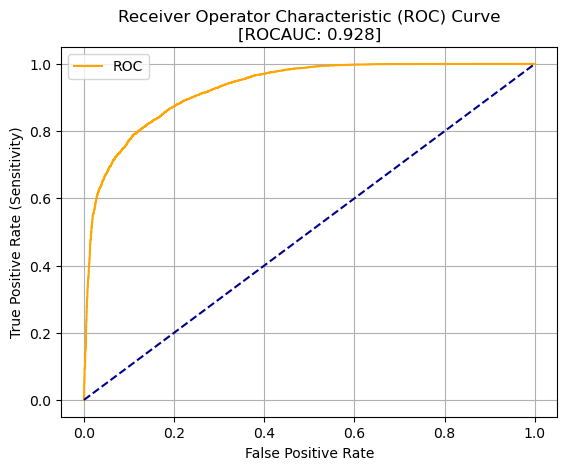

()

In [510]:
# Get ROC curve using sklearn method
fpr, tpr, thresholds = roc_curve(y_test, probabilities_xgb[:,1]) 

# Plot ROC curve
plot_roc_curve(fpr, tpr)

In [522]:
# Get and store feature importances
feature_importance_df = pd.DataFrame() # create empty DataFrame
feature_importance_df['feature'] = list(X) # Get feature names from X
feature_importance_df['importance'] = model_xgb.feature_importances_
feature_importance_df.sort_values(by='importance', ascending=False, inplace=True)

feature_importance_df.head(20)

,feature,importance
5,precise_onset_known,0.141635
4,any_afib_diagnosis,0.066965
0,prior_disability,0.047826
1,stroke_severity,0.032569
65,team_Princess Royal Hospital Telford,0.023465
54,team_Norfolk and Norwich University Hospital,0.020191
23,team_East Surrey Hospital,0.012796
79,team_Royal Hampshire County Hospital,0.012401
40,team_Kings Mill Hospital,0.011951
100,team_Sunderland Royal Hospital,0.011792


SHAP

In [523]:
import shap

Create function to return SHAP values extension X and y data for train and test sets

In [513]:
def calculate_shap_extended(model, X_train, X_test):
    """
    TreeExplainer is a fast and exact method to estimate SHAP values for tree 
    models and ensembles of trees. Using this we can calculate the SHAP values.

    Either load from pickle (if file exists), or calculate.

    Args:
        model [xgboost classification model object]: xgboost object
        X_train [dataframe]: training set (used as background data)
        X_test [dtaframe]: test set (to calculate the SHAP values for)

    Return:
        shap_values_extended [dictionary]: the extended shap values (contains 
                    .values, .base, and .data)
        
    """

    # Set filename
    filename = os.path.join(paths.data_save_path, 
                            (paths.notebook + paths.model_text + 
                             '_shap_values_extended_.p'))
    # Check if exists
    file_exists = exists(filename)

    if file_exists:
        # Load explainer
        with open(filename, 'rb') as filehandler:
            shap_values_extended = pickle.load(filehandler)
    else:
        # Calculate SHAP values
        
        # Set up explainer using the model and feature values from training set
        explainer = shap.TreeExplainer(model, X_train)

        # Get (and store) Shapley values along with base and feature values
        shap_values_extended = explainer(X_test)

        explainer_filename = os.path.join(paths.data_save_path, 
                            (paths.notebook + paths.model_text + 
                             '_shap_explainer_' + str(k) + '.p'))

        # Save explainer using pickle
        with open(explainer_filename, 'wb') as filehandler:
            pickle.dump(explainer, filehandler)
            
        # Save shap values extended using pickle
        with open(filename, 'wb') as filehandler:
            pickle.dump(shap_values_extended, filehandler)
        
    return(shap_values_extended)

In [514]:
# Get and store SHAP values
shap_values_extended = calculate_shap_extended(model_xgb, X_train, X_test)
shap_values = shap_values_extended.values


 99%|===================| 13671/13815 [00:13<00:00]        

array([2.29642916e-01, 1.81956303e-01, 1.65846521e-02, 1.16390476e-01,
       1.61769877e-02, 1.62416990e-01, 3.46829857e-02, 6.79150811e-04,
       3.13841253e-03, 3.38385834e-03, 4.36757389e-03, 1.80327853e-03,
       4.31092578e-03, 7.71935800e-04, 1.36068740e-03, 1.03566069e-03,
       3.78080201e-04, 8.10997784e-04, 2.67802217e-03, 1.19063237e-03,
       4.47866934e-03, 4.57547339e-04, 2.06794248e-03, 3.98245715e-03,
       1.38464877e-04, 3.84788770e-03, 5.71205211e-03, 1.73122436e-03,
       4.19681982e-04, 2.02762720e-03, 2.46924776e-04, 1.43249253e-03,
       2.83476852e-03, 2.83928400e-03, 6.71968629e-06, 1.17342458e-03,
       3.17491733e-03, 4.13157506e-04, 1.79252523e-03, 1.36639509e-03,
       4.47356338e-04, 2.33410768e-03, 4.06434790e-03, 7.82274472e-04,
       3.21693940e-03, 5.94912447e-03, 1.36915303e-03, 3.59686786e-03,
       7.68940634e-03, 4.01824128e-03, 1.02598595e-03, 1.71402285e-03,
       7.84141262e-03, 7.10811307e-03, 4.19789089e-03, 4.03371146e-03,
      

In [536]:
# Get and store feature importances
shap_feature_importance_df = pd.DataFrame() # create empty DataFrame
shap_feature_importance_df['feature'] = list(X) # Get feature names from X
shap_feature_importance_df['importance'] = model_xgb.feature_importances_
shap_feature_importance_df['abs(mean shap)'] = abs(shap_values.mean(axis=0))
shap_feature_importance_df.sort_values(by='abs(mean shap)', ascending=False, inplace=True)

shap_feature_importance_df.head(20)

,feature,importance,abs(mean shap)
0,prior_disability,0.047826,0.229643
1,stroke_severity,0.032569,0.181956
5,precise_onset_known,0.141635,0.162417
3,onset_to_thrombolysis_time,0.009768,0.116390
6,discharge_disability,0.004466,0.034683
2,age,0.007018,0.016585
4,any_afib_diagnosis,0.066965,0.016177
100,team_Sunderland Royal Hospital,0.011792,0.008607
115,team_Whiston Hospital HASU,0.008201,0.008333
52,team_Musgrove Park Hospital,0.010020,0.007841


Show the relationship between feature value and SHAP value for the top 6 influential features
(as violin plots)

Resource: https://towardsdatascience.com/binning-records-on-a-continuous-variable-with-pandas-cut-and-qcut-5d7c8e11d7b0 https://matplotlib.org/3.1.0/gallery/statistics/customized_violin.html

In [ ]:
def set_ax(ax, category_list, feat, rotation=0):
    '''
    ax [matplotlib axis object] = matplotlib axis object
    category_list [list] = used for the xtick labels (the grouping of the data)
    feat [string] = used in the axis label, the feature that is being plotted
    rotation [integer] = xtick label rotation
    
    resource: 
    https://matplotlib.org/3.1.0/gallery/statistics/customized_violin.html
    '''
    # Set the axes ranges and axes labels
    ax.get_xaxis().set_tick_params(direction='out')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticks(np.arange(1, len(category_list) + 1))
    ax.set_xticklabels(category_list, rotation=rotation, fontsize=10)
    ax.set_xlim(0.25, len(category_list) + 0.75)
    ax.set_ylabel(f'SHAP values for {feat}', fontsize=12)
    ax.set_xlabel(f'Feature values for {feat}', fontsize=12)
    return(ax)

In [ ]:
feat_to_show = ["prior_disability", "stroke_severity", "precise_onset_known",
                "onset_to_thrombolysis_time", "discharge_disability", "age",
                "any_afib_diagnosis"]

fig = plt.figure(figsize=(12,9))
# for each feature, prepare the data for the violin plot.
# data either already in categories, or if there's more than 50 unique values
# for a feature then assume it needs to be binned, and a violin for each bin
for n, feat in enumerate(feat_to_show):    
    feature_data = shap_values_extended[:, feat].data
    feature_shap = shap_values_extended[:, feat].values

    # if feature has more that 50 unique values, then assume it needs to be 
    # binned (other assume they are unique categories)
    if np.unique(feature_data).shape[0] > 50:
        # bin the data, create a violin per bin
        
        # settings for the plot
        rotation = 45
        step = 30
        n_bins = min(11, np.int((feature_data.max())/step))
        
        # create list of bin values
        bin_list = [(i*step) for i in range(n_bins)]
        bin_list.append(feature_data.max())

        # create list of bins (the unique categories)
        category_list = [f'{i*step}-{((i+1)*step-1)}' for i in range(n_bins-1)]
        category_list.append(f'{(n_bins-1)*step}+')

        # bin the feature data
        feature_data = pd.cut(feature_data, bin_list, labels=category_list, 
                              right=False)

    else:
        # create a violin per unique value
        
        # settings for the plot
        rotation = 90
        
        # create list of unique categories in the feature data
        category_list = np.unique(feature_data)
        category_list = [int(i) for i in category_list]

    # create a list, each entry contains the corresponsing SHAP value for that 
    # category (or bin). A violin will represent each list.    
    shap_per_category = []
    for category in category_list:
        mask = feature_data == category
        shap_per_category.append(feature_shap[mask])

    # create violin plot
    ax = fig.add_subplot(2,3,n+1)
    ax.violinplot(shap_per_category, showmedians=True, widths=0.9)
    
    # Add line at Shap = 0
    feature_values = shap_values_extended[:, feat].data
    ax.plot([0, len(feature_values)], [0,0],c='0.5')   

    # customise the axes
    ax = set_ax(ax, category_list, feat, rotation=rotation)
    plt.subplots_adjust(bottom=0.15, wspace=0.05)
    
    # Adjust stroke severity tickmarks
    if feat == 'Stroke severity':
        ax.set_xticks(np.arange(1, len(category_list)+1, 2))
        ax.set_xticklabels(category_list[0::2]) 
    
    # Add title
    ax.set_title(feat)
    
plt.tight_layout(pad=2)

filename = os.path.join(paths.data_save_path, 
                        (paths.notebook + paths.model_text + 
                            '_thrombolysis_shap_violin.jpg'))
plt.savefig(filename, dpi=300, bbox_inches='tight', pad_inches=0.2) 

plt.show()

Compare SHAP values for the hospital one-hot encoded features
The hospital feature is one-hot encoded, so there is a SHAP value per stroke team. We will use this to create a histogram of the frequency of the SHAP value for the hospital feature (using only the first k-fold test set, and take the mean of the SHAP values for the instances for each hospital's own patients).

In [ ]:
# Set up list for storing patient data and hospital SHAP
feature_data_with_shap = []

# Get mean SHAP for stroke team when patient attending that stroke team
stroke_teams = list(np.unique(data_stroke_team))
stroke_teams.sort()
stroke_team_mean_shap = []
# Loop through stroke teams

for stroke_team in stroke_teams:
    # Identify rows in test data that match each stroke team
    mask = data_stroke_team == stroke_team
    stroke_team_shap_all_features = shap_values[mask]
    # Get column index for stroke_team_in_shap
    feature_name = 'team_' + stroke_team
    index = feature_names_ohe.index(feature_name)
    # Get SHAP values for hospital
    stroke_team_shap = stroke_team_shap_all_features[:, index]
    # Get mean
    mean_shap = np.mean(stroke_team_shap)
    # Store mean
    stroke_team_mean_shap.append(mean_shap)
    # Get and store feature data and add SHAP
    feature_data = data_outcome[mask]
    feature_data['Hospital_SHAP'] = stroke_team_shap
    feature_data_with_shap.append(feature_data)

# Concatenate and save feature_data_with_shap
feature_data_with_shap = pd.concat(feature_data_with_shap, axis=0)

filename = os.path.join(paths.data_save_path, 
                        (paths.notebook + paths.model_text + 
                         '_feature_data_with_hospital_shap.jpg'))

feature_data_with_shap.to_csv(filename, index=False)

# Create and save shap mean value per hospital
hospital_data = pd.DataFrame()
hospital_data["stroke_team"] = stroke_teams
hospital_data["shap_mean"] = stroke_team_mean_shap

filename = os.path.join(paths.data_save_path, 
                        (paths.notebook + paths.model_text + 
                         '_mean_shap_per_hospital_0fold.csv'))

hospital_data.to_csv(filename, index=False)

Plot histogram of the frequency of the mean SHAP value for the instances for each hospital's own patients (using only the first k-fold test set)


NameError: name 'stroke_team_mean_shap' is not defined

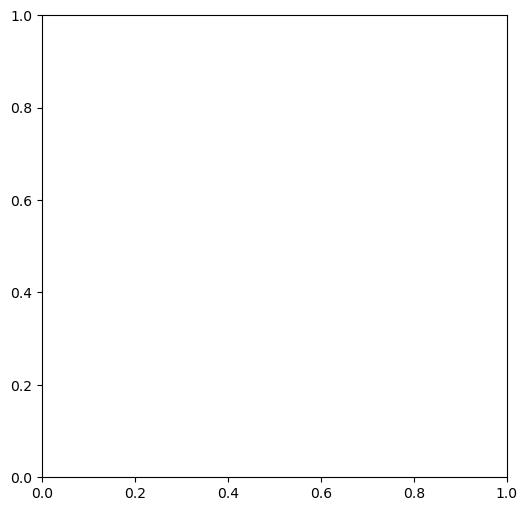

In [537]:
# Plot histogram
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot()
ax.hist(stroke_team_mean_shap, bins=np.arange(-1.5, 1.51, 0.1))
ax.set_xlabel('SHAP value')
ax.set_ylabel('Count')

filename = os.path.join(paths.data_save_path, 
                        (paths.notebook + paths.model_text + 
                         '_hosp_shap_hist.jpg'))
plt.savefig(filename, dpi=300, bbox_inches='tight', pad_inches=0.2)
plt.show()

For each of the features, for each of the patient subpopulations, use statistical tests to determine whether any are statistically significant.

Different variable types will need different statistical test.
1. Continuous: t-test (normally distributed). Or, instead of t-test use mann whitney (if non parametric). This test is done on the rank of the values, rather than actual values. Due to features with a large range, even small differences will appear to be significanlty different. When do tests, we will compile a table containing the mean, std dev etc. if using MW test, quote median than mean.
1. Counts: poisson regression, negative binomial regression (which is a type of liniear regression with negative binomial parameter)
1. Categorical: Chi squared test


Define each feature:
1. prior_disability: categorical
1. stroke_severity: Count
1. age: continuous (or count?)
1. arrival_to_scan_time: count
1. precise_onset_known: categorical
1. onset_to_arrival_time: poisson or normal
1. onset_during_sleep: categorical
1. afib_anticoagulant: categorical
1. stroke_team: categorical
1. onset_to_thrombolysis_time: (exclude the -ve) continuous
1. any_afib_diagnosis: categorical
1. discharge_disability: categorical

#### Chi-Square

The aim of this chi-square test is to conclude whether the two variables are related to each other not. 

For our case, our two features are: prior disability (0, 1, 2, 3, 4, 5), and treated in the different scenarios (s1 only, s2 only, both s1 and s2).

Null hypothesis: We start by defining our null hypothesis (H0) which states that there is no relation between the variables (prior disability and treated in the scenarios). 

Alternate hypothesis: It would state that there is a significant relationship between the two variables (prior disability and treated in the scenarios). 

Using p-value: We will define a significant factor to determine whether the relation between the variables is of considerable significance. Generally, a significant factor or alpha value of 0.05 is chosen. This alpha value denotes the probability of erroneously rejecting H0 when it is true. A lower alpha value is chosen in cases when we expect more precision. If the p-value for the test comes out to be strictly greater than the alpha value, then we will accept our H0.

Code for chi squared

In [516]:
def calculate_chi_square(df_treatment_decision_per_scenario,
                         data_for_histogram,
                         list_features,
                         scenario_columns,
                         scenarios_short_name):

    # mask of the patients treated in bm
    s1_mask = (df_treatment_decision_per_scenario[scenario_columns[0]] > 0).values

    # mask of the patients treated in outcome
    s2_mask = (df_treatment_decision_per_scenario[scenario_columns[1]] > 0).values

    # mask of the patients treated in bm only
    s1_only_mask = (s1_mask == 1) & (s2_mask == 0)

    # mask of the patients treated in outcome
    s2_only_mask = (s1_mask == 0) & (s2_mask == 1)

    # mask of the patients treated in both scenario
    both_mask = (df_treatment_decision_per_scenario[scenario_columns].sum(axis=1) == 2).values

    mask_patients = [both_mask, s1_only_mask, s2_only_mask]

    for feat in list_features:
        unique_feat_values = data_for_histogram[feat].unique()
        df_chi2_data = pd.DataFrame(index=data_for_histogram[feat].unique())

        # For each set of patients (both, s1 only, s2 only)
        for c, mask in enumerate(mask_patients):
    #        x = data_for_histogram[mask].groupby([feat]).count().index
    #        y = data_for_histogram[mask].groupby([feat]).count().iloc[:,0].values
            df1 = pd.DataFrame(index=data_for_histogram[mask].groupby([feat]).count().index)
            df1[c] = data_for_histogram[mask].groupby([feat]).count().iloc[:,0].values
            df_chi2_data = df_chi2_data.join(df1)

        df_chi2_data = df_chi2_data.replace(np.nan, 0)
        print(df_chi2_data)
        chi2_data = df_chi2_data.transpose().values.tolist()

        stat, p, dof, expected = chi2_contingency(chi2_data)
        
        # interpret p-value
        alpha = 0.05
        print(f"Scenario: {scenario_columns[0]} vs {scenario_columns[1]} (three groups, in only one, in only the other, in both)")
        print(f"Feature: {feat}")
        print("p value is " + str(p))
        if p <= alpha:
            print('Dependent (reject H0): There is a significant relationship between the two variables')
        else:
            print('Independent (H0 holds true): There is not a significant relationship between the two variables')
        print()
    return()

In [517]:
list_features_categorical = ["prior_disability", "precise_onset_known", "onset_during_sleep", "afib_anticoagulant", "stroke_team", "any_afib_diagnosis", "discharge_disability"]
scenarios_columns = ["High_benchmark", "Lowest_weighted_mrs_and_least_mrs5_6"]
scenarios_short_name = ["High benchmark", "Best outcome"]
scenarios_full_name = ["High benchmark", 
                       "Lowest weighted mRS and least likely bad outcome (mRS5+)]"]

calculate_chi_square(df_treatment_decision_per_scenario,
                     data_for_histogram,
                     list_features_categorical,
                     scenarios_columns,
                     scenarios_short_name)

       0     1     2
1   5433  1348  3105
0  22668  5992  6775
3   3439   697  3554
5    111    32  1176
2   2889   671  2601
4   1029   460  2480
Scenario: High_benchmark vs Lowest_weighted_mrs_and_least_mrs5_6 (three groups, in only one, in only the other, in both)
Feature: prior_disability
p value is 0.0
Dependent (reject H0): There is a significant relationship between the two variables

       0     1      2
1  29132  8280   7802
0   6437   920  11889
Scenario: High_benchmark vs Lowest_weighted_mrs_and_least_mrs5_6 (three groups, in only one, in only the other, in both)
Feature: precise_onset_known
p value is 0.0
Dependent (reject H0): There is a significant relationship between the two variables

       0       1      2
0  35568  9200.0  17480
1      1     0.0   2211
Scenario: High_benchmark vs Lowest_weighted_mrs_and_least_mrs5_6 (three groups, in only one, in only the other, in both)
Feature: onset_during_sleep
p value is 0.0
Dependent (reject H0): There is a significant relati

()

#### Chi-Square

The aim of this chi-square test is to conclude whether the two variables are related to each other not. 

When comparing the scenarios of who is treated in the high benchmark scenario vs who is treated in the best outcome scenario, we have a set of patients that should be treated (but aren't), and those that should not be treated (but are). Want to identify if there is a way to identify either of these groups and so know to leave them alone, or to give treatment.

Compare the set of patients that should be treated (but aren't) [subgroup 1] with the rest of the patient population [subgroup 2].
Compare the set of patients that should not be treated (but are) [subgroup 1] with the rest of the patient population [subgroup 2].

For our case, our two features are: prior disability (0, 1, 2, 3, 4, 5), and whether are in subgroup 1 or 2.

Null hypothesis (H0): There is no relation between the variables (prior disability and whether in subgroup 1 or 2). 

Alternate hypothesis (H1): There is a significant relationship between the two variables (prior disability and whether in subgroup 1 or 2). 

Using p-value: We will define a significant factor to determine whether the relation between the variables is of considerable significance. Generally, a significant factor or alpha value of 0.05 is chosen. This alpha value denotes the probability of erroneously rejecting H0 when it is true. A lower alpha value is chosen in cases when we expect more precision. If the p-value for the test comes out to be strictly greater than the alpha value, then we will accept our H0.

Code for chi squared

In [518]:
def calculate_chi_square(list_of_df_treatment_decisions,
                         list_features,
                         scenario_columns):

    for feat in list_features:
        unique_feat_values = data_for_histogram[feat].unique()
        df_chi2_data = pd.DataFrame(index=data_for_histogram[feat].unique())

        # For each set of patients
        for c, df_sg in enumerate(list_of_df_treatment_decisions):
            df1 = pd.DataFrame(index=df_sg.groupby([feat]).count().index)
            df1[c] = df_sg.groupby([feat]).count().iloc[:,0].values
            df_chi2_data = df_chi2_data.join(df1)

        df_chi2_data = df_chi2_data.replace(np.nan, 0)
        print(df_chi2_data)
        chi2_data = df_chi2_data.transpose().values.tolist()

        stat, p, dof, expected = chi2_contingency(chi2_data)
        
        # interpret p-value
        alpha = 0.05
        print(f"Scenario: {scenario_columns[0]} vs {scenario_columns[1]} (three groups, in only one, in only the other, in both)")
        print(f"Feature: {feat}")
        print("p value is " + str(p))
        if p <= alpha:
            print('Dependent (reject H0): There is a significant relationship between the two variables')
        else:
            print('Independent (H0 holds true): There is not a significant relationship between the two variables')
        print()
    return()

In [519]:
list_features_categorical = ["prior_disability", "precise_onset_known", "onset_during_sleep", "afib_anticoagulant", "stroke_team", "any_afib_diagnosis", "discharge_disability"]
scenarios_columns = ["High_benchmark", "Lowest_weighted_mrs_and_least_mrs5_6"]
scenarios_short_name = ["High benchmark", "Best outcome"]
scenarios_full_name = ["High benchmark", 
                       "Lowest weighted mRS and least likely bad outcome (mRS5+)]"]

calculate_chi_square(df_treatment_decision_per_scenario,
                     list_features_categorical,
                     scenarios_columns,
                     scenarios_short_name)

TypeError: calculate_chi_square() takes 3 positional arguments but 4 were given

Code for t-test

Code for mann whitney

Code for poisson regression

Code for negative binomial regression

We can use this to ask other similar questions by looking at the agreement between other scenarios.

Such as:
* Are those that are actually treated getting the best outcome? (comparing scenario Actual, with the versions of best outcome)
* 

Not going to have a scenario for the benchmark set of hospitals based on best outcomes, because if we are interested in best decisions then we can get better decisions by the algortihm (it has learnt more patterns than individual hospitals).

Include this analysis in the WebApp - provide more than 1 treatment scenario. If you want to be conservative use the scenario that requires a threshold for the improvement (without increasing bad outcome) "IMPROVES WEIGHTED AVE mRS BY 0.2 & BEST LIKELIHOOD mRS0-4". If want to be less conservative use "BEST WEIGHTED mRS & BEST LIKELIHOOD mRS0-4" which shows any improvement (without increasing bad outcome). Neither of these scnarios increase the risk of causing harm.

This approach moves away from "computer says this", it instead gives 2 options that is beneficial, but the clincian chooses their level of improvement.

Which patients do benchmark decide to give IVT, and the "BEST WEIGHTED mRS & BEST LIKELIHOOD mRS0-4" says no.

Are there any patterns for the patients where "BEST WEIGHTED mRS & BEST LIKELIHOOD mRS0-4" says yes, and benchmark say no. And vice versa?

Could we use cluster analysis to look at this?

Or the Radar/spider diagrams?

Could give patients that the benchmark hospitals choose to give Ivt, but the "Best Outcome" decision says no: Store as a new label.
Then build a model to predict the new label, calculate SHAP for it. Then can analyse which are the feature values that mostly predict a patient the benchmark treats, but outcome wise you shouldn’t.

The 2 best outcome scenarios bracket the benchmark rate (45 to 60, vs 49%).

<Axes: title={'center': 'Agreement on which patients to treat\n* Patients treated in any scenario: 64460\n* Patients not treated in any scenario: 26934\n'}>

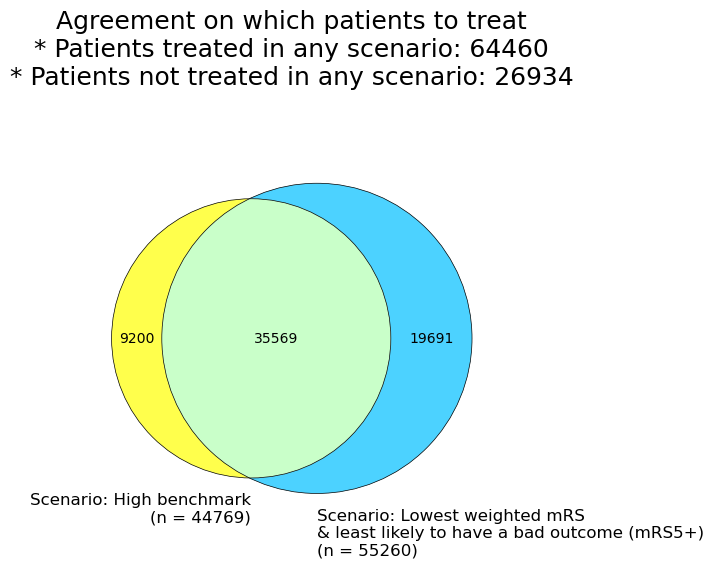

In [ ]:
venn_diagram_columns = ["High_benchmark",
                        "Lowest_weighted_mrs_and_least_mrs5_6"]

xticks = [dict_scenario_information[f"{col_name}_full_name"] for col_name in venn_diagram_columns]

filename = os.path.join(paths.image_save_path, 
                        (paths.notebook + paths.model_text + 
                        '_venn_diagram_2scenarios.jpg'))

create_venn_diagram(df_treatment_decision_per_scenario, 
                    venn_diagram_columns, xticks,
                    filename, 
                    title_prefix="Agreement on which patients to treat\n")

<Axes: title={'center': 'Agreement on which patients to treat\n* Patients treated in any scenario: 63622\n* Patients not treated in any scenario: 27772\n'}>

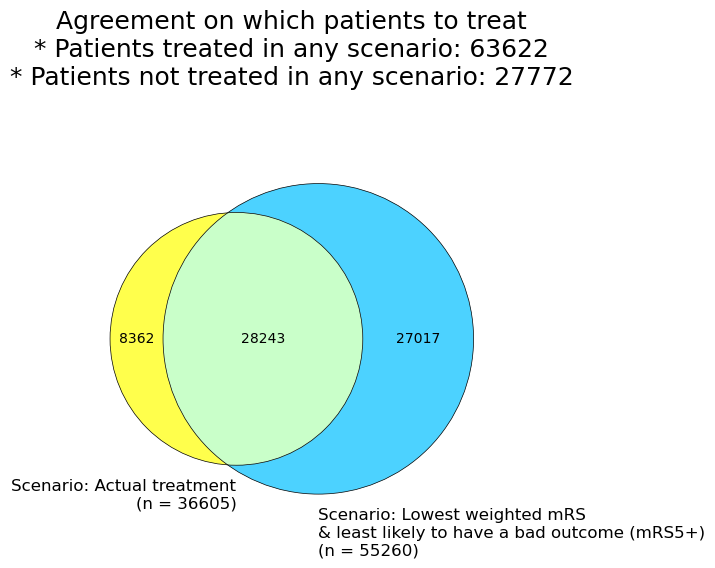

In [ ]:
venn_diagram_columns = ["Actual_treatment",
                        "Lowest_weighted_mrs_and_least_mrs5_6"]

xticks = [dict_scenario_information[f"{col_name}_full_name"] for col_name in venn_diagram_columns]

filename = os.path.join(paths.image_save_path, 
                        (paths.notebook + paths.model_text + 
                        '_venn_diagram_2scenarios.jpg'))

create_venn_diagram(df_treatment_decision_per_scenario, 
                    venn_diagram_columns, xticks,
                    filename,
                    title_prefix="Agreement on which patients to treat\n")

<Axes: title={'center': 'Agreement on which patients to treat\n* Patients treated in any scenario: 75579\n* Patients not treated in any scenario: 15815\n'}>

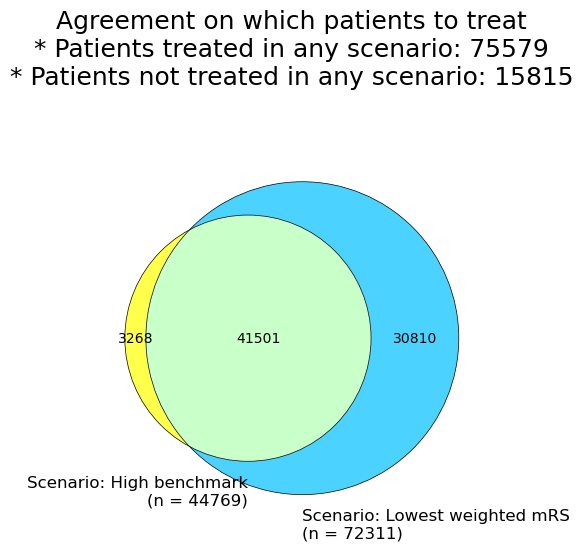

In [ ]:
venn_diagram_columns = ["High_benchmark",
                        "Lowest_weighted_mrs"]

xticks = [dict_scenario_information[f"{col_name}_full_name"] for col_name in venn_diagram_columns]

filename = os.path.join(paths.image_save_path, 
                        (paths.notebook + paths.model_text + 
                        '_venn_diagram_2scenarios.jpg'))

create_venn_diagram(df_treatment_decision_per_scenario, 
                    venn_diagram_columns, xticks,
                    filename,
                    title_prefix="Agreement on which patients to treat\n")

In [ ]:
### Subgroup 1: Patients with mild stroke
mask_mild = (data["stroke_severity"] < 5).values

df_treatment_per_scenario_mild_stroke = (
    df_treatment_decision_per_scenario[mask_mild])

### Subgroup 2: Patients with moderate stroke
mask_moderate = ((data["stroke_severity"] > 4) & (data["stroke_severity"] < 21)).values

df_treatment_per_scenario_moderate_stroke = (
    df_treatment_decision_per_scenario[mask_moderate])

### Subgroup 3: Patients with severe stroke
mask_severe = (data["stroke_severity"] > 20).values

df_treatment_per_scenario_severe_stroke = (
    df_treatment_decision_per_scenario[mask_severe])

### Subgroup 4: Patients with severe stroke with no prior disability
mask_severe = (data["stroke_severity"] > 20).values
mask_no_prior_disability = (data["prior_disability"] <2).values
mask = mask_severe * mask_no_prior_disability

df_treatment_per_scenario_severe_stroke_no_prior_disability = (
    df_treatment_decision_per_scenario[mask])

### Subgroup 5: Patients with not a mild stroke (NIHSS 5+)
mask_not_mild = (data["stroke_severity"] >= 5).values

df_treatment_per_scenario_not_mild_stroke = (
    df_treatment_decision_per_scenario[mask_not_mild])

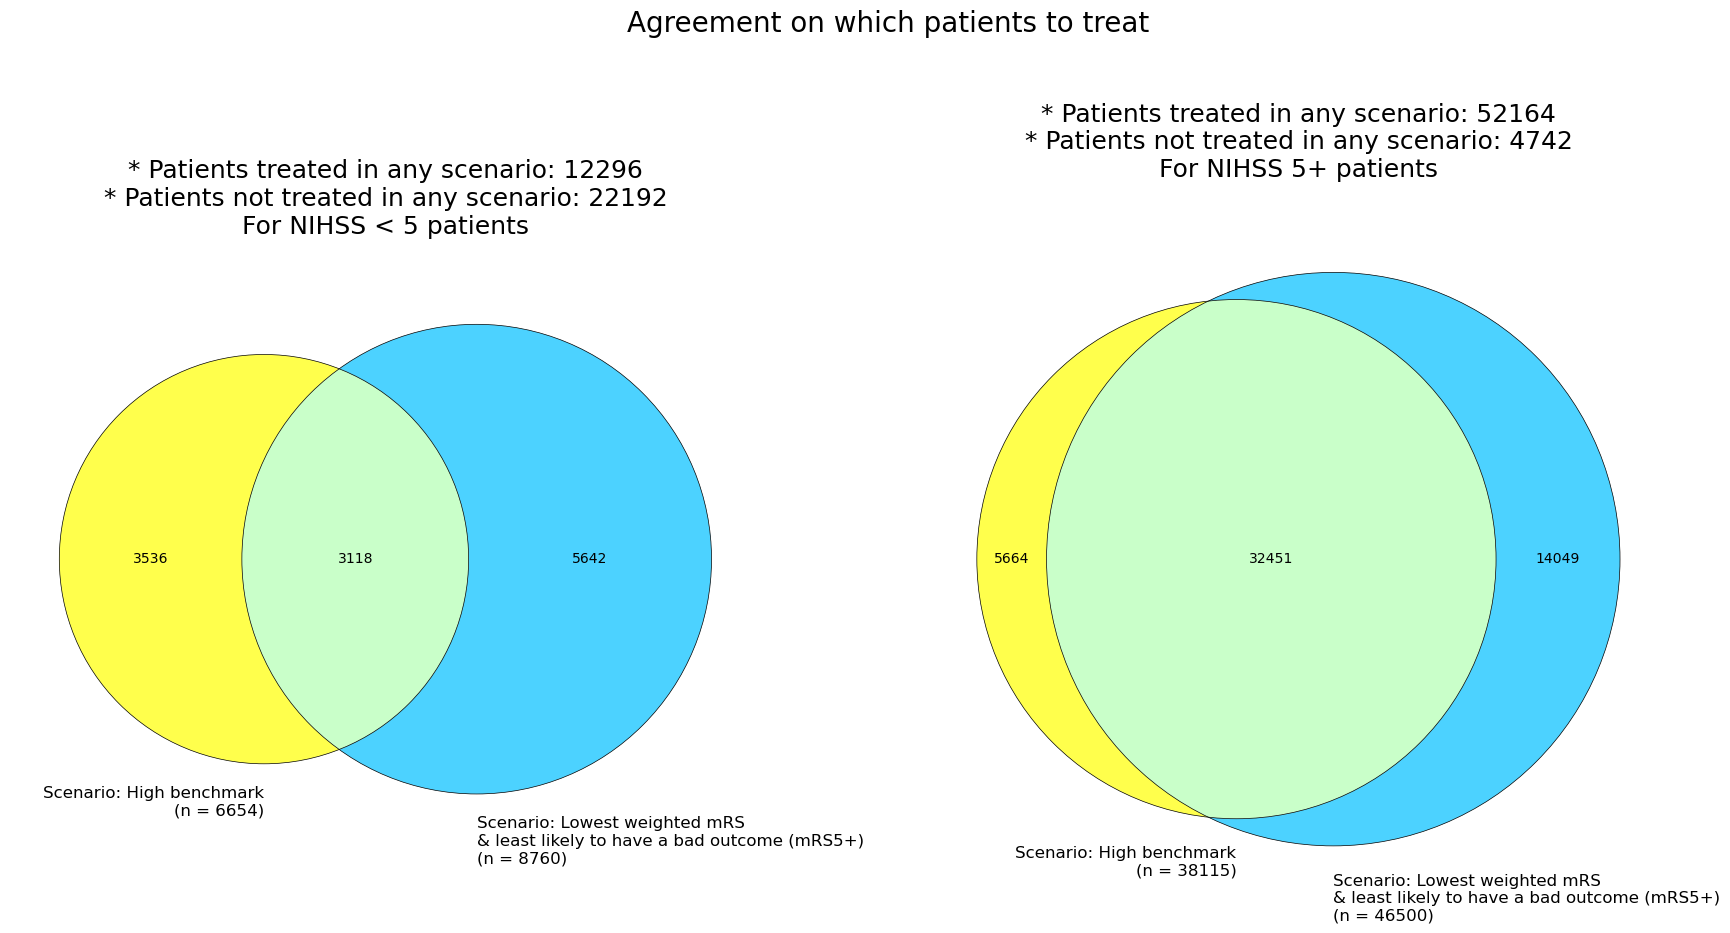

In [ ]:
# split by stroke severity: NIHSS <5, NIHSS 5+

venn_diagram_columns = ["High_benchmark",
                        "Lowest_weighted_mrs_and_least_mrs5_6"]

xticks = [dict_scenario_information[f"{col_name}_full_name"] for col_name in venn_diagram_columns]

# Put data in required format for venn diagram.
# A list of sets
# Each set contains the patient index numbers that recieve IVT in that scenario
subgroup_data = [df_treatment_per_scenario_mild_stroke,
                 df_treatment_per_scenario_not_mild_stroke]

subgroup_labels = ["NIHSS < 5", "NIHSS 5+"]

fig = plt.figure(figsize=(18,11))

fig.suptitle("Agreement on which patients to treat", fontsize=20)

for subplot, (df_treated_subgroup, subgroup_label) in enumerate(zip(subgroup_data, subgroup_labels)):
    filename = os.path.join(paths.image_save_path, 
                            (paths.notebook + paths.model_text + 
                            f'_venn_diagram_{len(venn_diagram_columns)}scenarios_{subgroup_label}.jpg'))

    ax1 = fig.add_subplot(1,2,subplot+1)

    create_venn_diagram(df_treated_subgroup, 
                        venn_diagram_columns, xticks,
                        filename, title_suffix=f"For {subgroup_label} patients",
                        ax=ax1)
    
  
fig.tight_layout()

We have defined two scenarios that decide to treat based on the best outcome for the patient. Both do not increase the risk of a bad outcome with treatment (does not increase the likelihood of being mRS 5 and mRS 6). One only gives treatment if the weighted average mRS is improved, and the other is if the improvement is beyond a set threshold (we are using 0.2).

We compare the choice of whether to give thrombolysis to each of the 91394 patients, based on the benchmark decision, the more cautious best outcome, and the less cautious best outcome.

55260 patients are treated by the less cautious scenario.
41699 patients are treated by the more cautious scenario.
24469 patients are treated by the benchmark decision.

Of the 24469 patients are treated by the benchmark decision, 11382 are also treated in both of the best outcome scenarios, 3650 are also treated in the less caution scenario, and 9437 patients are not treated in either best outcome scenarios.

Can we unpick any patient characteristics where benchmark hospitals treat but the outcome scenarios do not?

Also can we unpick any patient characteristics where benchmark hospitals do not treat, but the outcome scenarios do?


For each feature create a set of four histograms:
1. of all the 64697 patients treated in either scenario
1. for the 9437 patients that only the benchmark treat
1. for the 15032 patients that both treat
1. for the 40228 patients that only the best outcome treat

In [ ]:
def create_histogram_figures(df_treatment_decision_per_scenario,
                             data_for_histogram,
                             selected_features_set,
                             scenario_columns,
                             scenarios_short_name,
                             scenarios_full_name=""):

    # mask of the patients treated across any scenario
    either_mask = df_treatment_decision_per_scenario[scenario_columns].sum(axis=1) > 0

    # mask of the patients treated in bm
    s1_mask = df_treatment_decision_per_scenario[scenario_columns[0]] > 0

    # mask of the patients treated in outcome
    s2_mask = df_treatment_decision_per_scenario[scenario_columns[1]] > 0

    # mask of the patients treated in bm only
    s1_only_mask = (s1_mask == 1) & (s2_mask == 0)

    # mask of the patients treated in outcome
    s2_only_mask = (s1_mask == 0) & (s2_mask == 1)

    # mask of the patients treated in both scenario
    both_mask = df_treatment_decision_per_scenario[scenario_columns].sum(axis=1) == 2

    mask_patients = [either_mask, both_mask, s1_only_mask, s2_only_mask]

    labels = [f"Either scenario (n = {int(either_mask.sum())})", 
            f"Both scenarios (n = {int(both_mask.sum())})",
            f"'{scenarios_short_name[0]}' only (n = {int(s1_only_mask.sum())})", 
            f"'{scenarios_short_name[1]}' only (n = {int(s2_only_mask.sum())})" 
            ]

    n_subplots = len(labels)
    n_cols = 2
    n_rows = int(n_subplots/n_cols)

    for feat in selected_features_set:
        fig, axes = plt.subplots(n_rows, n_cols)

        plt.text(x=0.5, y=0.94, s=f"Feature: {feat}", fontsize=14, ha="center", transform=fig.transFigure)
        plt.text(x=0.5, y=0.89, s=f"Comparing scenarios: '{scenarios_short_name[0]}' vs '{scenarios_short_name[1]}'", fontsize=12, ha="center", transform=fig.transFigure)
        if len(scenarios_full_name)>0:
            plt.text(x=0.5, y=0.85, s=f"[where '{scenarios_short_name[1]}' is '{scenarios_full_name[1]}'", fontsize=8, ha="center", transform=fig.transFigure)

        # For each set of patients (all, bm, both, outcome)
        for (mask, label, ax) in zip(mask_patients, labels, axes.flatten()):
            if feat == "onset_to_thrombolysis_time":
                counts, bins = np.histogram(data_for_histogram[feat][mask])
                ax.hist(bins[:-1], bins, weights=counts)
            else:
                x = data_for_histogram[mask].groupby([feat]).count().index
                y = data_for_histogram[mask].groupby([feat]).count().iloc[:,0].values
                ax.bar(x,y)

            if feat == "stroke_team":
                ax.set_xticklabels([]);
            ax.set_title(label, fontsize=10)
            if data_for_histogram[feat].nunique() == 2:
                ax.set_xticks([0,1])

        plt.subplots_adjust(top=0.75, wspace=0.3, hspace=0.5)
        plt.show()
    return()

IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).

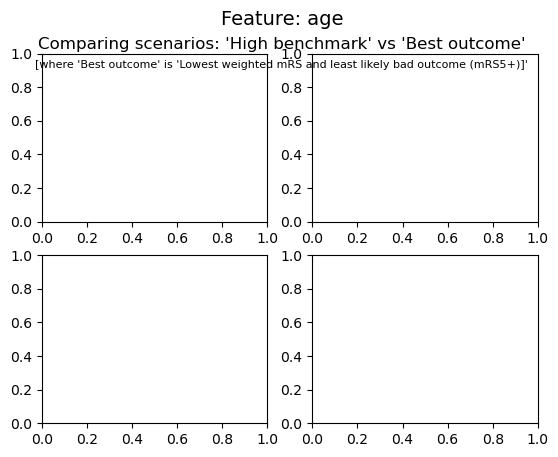

In [ ]:
scenarios_columns = ["High_benchmark",
                     "Lowest_weighted_mrs_and_least_mrs5_6"]
scenarios_short_name = ["High benchmark", "Best outcome"]
scenarios_full_name = ["High benchmark", 
                       "Lowest weighted mRS and least likely bad outcome (mRS5+)]"]

create_histogram_figures(df_treatment_decision_per_scenario, 
                         data_for_histogram,
                         selected_features_set,
                         scenarios_columns, 
                         scenarios_short_name,
                         scenarios_full_name=scenarios_full_name)

In [ ]:
scenarios_columns = ["High_benchmark",
                     "Lowest_weighted_mrs"]
scenarios_short_name = ["High benchmark", "Best outcome"]
scenarios_full_name = ["High benchmark", 
                       "Lowest weighted mRS"]

create_histogram_figures(df_treatment_decision_per_scenario, 
                         data_for_histogram,
                         selected_features_set,
                         scenarios_columns, 
                         scenarios_short_name,
                         scenarios_full_name=scenarios_full_name)

Looking at low benchmark

In [ ]:
venn_diagram_columns = ["Low_benchmark",
                        "High_benchmark",
                        "Weighted_mrs_threshold_improvement_and_least_mrs5_6"]

venn_diagram_xticks = ["Low benchmark" , "High benchmark" , 
                   "Improves weighted mRS by 0.2\n& least likely bad outcome (mRS5+)"]

# Put data in required format for venn diagram.
# A list of sets
# Each set contains the patient index numbers that recieve IVT in that scenario
list_vd_sets = []
labels =[]
for col, label in zip (venn_diagram_columns, venn_diagram_xticks):
    mask = df_treatment_decision_per_scenario[col]==1
    list_vd_sets.append(set(df_treatment_decision_per_scenario[mask].index))
    count_ivt = int(df_treatment_decision_per_scenario[col].sum())
    labels.append("Scenario: " + label +  f"\n(n = {count_ivt})")

# Create venn diagram
venn3(list_vd_sets, labels);

# Calculate the number of patients treated across any scenario
mask = df_treatment_decision_per_scenario[venn_diagram_columns].sum(axis=1) > 0
n_patients_treated = mask.sum()

# Add title
plt.title(f"Agreement on which patients to treat\n(patients treated in at least"
          f" one of these three scenarios: {n_patients_treated})", 
          fontsize=18, pad=30)

filename = os.path.join(paths.image_save_path, 
                        (paths.notebook + paths.model_text + 
                       '_venn_diagram_3features_lowBM_highBM_bestoutcome.jpg'))

plt.savefig(filename, dpi=300)

In [ ]:
venn_diagram_columns = ["Low_benchmark","High_benchmark", 
                        "Lowest_weighted_mrs_and_least_mrs5_6"]

venn_diagram_xticks = ["Low benchmark","High_benchmark", 
                       "Lowest weighted mRS,\nand least likely bad outcome (mRS5+)"]

# Put data in required format for venn diagram.
# A list of sets
# Each set contains the patient index numbers that recieve IVT in that scenario
list_vd_sets = []
labels =[]
for col, label in zip (venn_diagram_columns, venn_diagram_xticks):
    mask = df_treatment_decision_per_scenario[col]==1
    list_vd_sets.append(set(df_treatment_decision_per_scenario[mask].index))
    count_ivt = int(df_treatment_decision_per_scenario[col].sum())
    labels.append("Scenario: " + label +  f"\n(n = {count_ivt})")

# Create venn diagram
v = venn3(list_vd_sets, labels);
# Calculate the number of patients treated across any scenario
mask = df_treatment_decision_per_scenario[venn_diagram_columns].sum(axis=1) > 0
n_patients_treated = mask.sum()

# Add title
plt.title(f"Agreement on which patients to treat\n(patients treated in at least"
          f" one of these three scenarios: {n_patients_treated})", 
          fontsize=18, pad=30)

filename = os.path.join(paths.image_save_path, 
                        (paths.notebook + paths.model_text + 
                       '_venn_diagram_lowBM_highBM_bo1.jpg'))

plt.savefig(filename, dpi=300)

Print out the percentages that get treated... YET TO DO (NEED TO GET VALUES FROM THE INTERSECTIONS)

In [ ]:
for col, label in zip (venn_diagram_columns, venn_diagram_xticks):
    mask = df_treatment_decision_per_scenario[col]==1
    list_vd_sets.append(set(df_treatment_decision_per_scenario[mask].index))
    count_ivt = int(df_treatment_decision_per_scenario[col].sum())
    labels.append("Scenario: " + label +  f"\n(n = {count_ivt})")


    print("Scenario: " + label)

#    print(f"Of the {count_ivt} patients that the scenario {label} would choose to treat, {}79% of those patients are who the model believes get the best outcome from having treatment.")
#    print(f"Of the 55260 patients that the  model believes gets the best outcome from having treatment, the high benchmark decision would choose to treat 64% of them.")

Add one more group ("actual thrombolysis") to this venn diagram.

In [ ]:
from venny4py.venny4py import *

#dict of sets
sets = {
    'Set1': set(list("Harry Potter")),
    'Set2': set(list("Hermione Granger")),
    'Set3': set(list("Ron Weasley")),
    'Set4': set(list("Severus Snape"))}
    
venny4py(sets=sets)

Want to tweak the eclipse venn, so edit the code that was provided on github

In [ ]:
#get shared elements for each combination of sets
def get_shared(sets):
    IDs = sets.keys()
    combs = sum([list(map(list, combinations(IDs, i))) for i in range(1, len(IDs) + 1)], [])

    shared = {}
    for comb in combs:
        ID = ' and '.join(comb)
        if len(comb) == 1:
            shared.update({ID: sets[comb[0]]})
        else:
            setlist = [sets[c] for c in comb]
            u = set.intersection(*setlist)
            shared.update({ID: u})
    return shared


#get unique elements for each combination of sets
def get_unique(shared):
    unique = {}
    for shar in shared:
        if shar == list(shared.keys())[-1]:
            s = shared[shar]
            unique.update({shar: s})
            continue
        count = shar.count(' and ')
        if count == 0:
            setlist = [shared[k] for k in shared.keys() if k != shar and " and " not in k]
            s = shared[shar].difference(*setlist)
        else:
            setlist = [shared[k] for k in shared.keys() if k != shar and k.count(' and ') >= count]
            s = shared[shar].difference(*setlist)
        unique.update({shar: s})
    return(unique)

#plot Venn
def local_venny4py(sets={}, out='./', asax=False, ext='png', dpi=300, size=3.5, n_patients_treated=0):
    shared = get_shared(sets)
    unique = get_unique(shared)
    ce = 'bgrc' #colors
    lw = size*.12 #line width
    fs = size*1.5#2 #font size
    nc = 2 #legend cols
    cs = 4 #columnspacing
    
    with open(f'{out}/Intersections_{len(sets)}.txt', 'w') as f:
        for k, v in unique.items():
            f.write(f'{k}: {len(v)}, {sorted(list(v))}\n')
    
    if asax == False:
        plt.rcParams['figure.dpi'] = 200 #dpi in notebook
        plt.rcParams['savefig.dpi'] = dpi #dpi in saved figure
        fig, ax = plt.subplots(1, 1, figsize=(size, size))

    else:
        ax = asax
        
    ax.set_xlim(0, 100)
    ax.set_ylim(0, 100)
    ax.axis('off')
    
    #4 sets
    if len(sets) == 4:
        #draw ellipses
        ew = 45 #width
        eh = 75 #height
        xe = [35, 48, 52, 65] #x coordinats
        ye = [35, 45, 45, 35] #y coordinats
        ae = [225, 225, 315, 315] #angles

        for i, s in enumerate(sets):
            ax.add_artist(Ellipse(xy=(xe[i], ye[i]), width=ew, height=eh, fc=ce[i], 
                                  angle=ae[i], alpha=.3))
            ax.add_artist(Ellipse(xy=(xe[i], ye[i]), width=ew, height=eh, fc='None',
                                  angle=ae[i], ec='black', lw=lw))

        #annotate
        xt = [12, 32, 68, 88, 14, 34, 66, 86, 26, 28, 50, 50, 72, 74, 37, 60, 40, 63, 50] #x
        yt = [67, 79, 79, 67, 41, 70, 70, 41, 59, 26, 11, 60, 26, 59, 51, 17, 17, 51, 35] #y

        for j, s in enumerate(sets):
            ax.text(xt[j], yt[j], len(sets[s]), ha='center', va='center', fontsize=fs, 
                    transform=ax.transData)

        for k in unique:
            j += 1
            ax.text(xt[j], yt[j], len(unique[k]), ha='center', va='center', fontsize=fs, 
                    transform=ax.transData)
            
    #3 sets
    if len(sets) == 3:
        #draw circles
        ew = 60 #width
        eh = 60 #height
        lw = size*.12 #line width
        xe = [37, 63, 50] #x coordinats
        ye = [55, 55, 32] #y coordinats
        nc = 3 #legend columns
        cs = 1 #columns spacing

        for i, s in enumerate(sets):
            ax.add_artist(Ellipse(xy=(xe[i], ye[i]), width=ew, height=eh, fc=ce[i], 
                                  angle=0, alpha=.3))
            ax.add_artist(Ellipse(xy=(xe[i], ye[i]), width=ew, height=eh, fc='None',
                                  angle=0, ec='black', lw=lw))

        #annotate
        xt = [12, 88, 28, 22, 78, 50, 50, 30, 70, 50] #x
        yt = [80, 80,  3, 60, 60, 17, 70, 35, 35, 50] #y
        

        for j, s in enumerate(sets):
            ax.text(xt[j], yt[j], len(sets[s]), ha='center', va='center', fontsize=fs, 
                    transform=ax.transData)

        for k in unique:
            j += 1
            ax.text(xt[j], yt[j], len(unique[k]), ha='center', va='center', fontsize=fs, 
                    transform=ax.transData)
            
    #2 sets
    if len(sets) == 2:
        #draw circles
        ew = 70 #width
        eh = 70 #height
        lw = size*.12 #line width
        xe = [37, 63] #x coordinats
        ye = [45, 45] #y coordinats

        for i, s in enumerate(sets):
            ax.add_artist(Ellipse(xy=(xe[i], ye[i]), width=ew, height=eh, fc=ce[i], 
                                  angle=0, alpha=.3))
            ax.add_artist(Ellipse(xy=(xe[i], ye[i]), width=ew, height=eh, fc='None',
                                  angle=0, ec='black', lw=lw))

        #annotate
        xt = [20, 80, 18, 82, 50] #x
        yt = [80, 80, 45, 45, 45] #y

        for j, s in enumerate(sets):
            ax.text(xt[j], yt[j], len(sets[s]), ha='center', va='center', fontsize=fs, 
                    transform=ax.transData)

        for k in unique:
            j += 1
            ax.text(xt[j], yt[j], len(unique[k]), ha='center', va='center', fontsize=fs, 
                    transform=ax.transData)
                
    #legend
    handles = [mpatches.Patch(color=ce[i], label=l, alpha=.3) for i, l in enumerate(sets)]

    ax.legend(labels=sets, handles=handles, fontsize=fs*0.9, frameon=False, 
            bbox_to_anchor=(.5, .99), bbox_transform=ax.transAxes, loc=9, 
            handlelength=1.5, ncol=nc, columnspacing=cs, handletextpad=.5)
#    ax.legend(labels=sets, handles=handles, fontsize=fs*.8, frameon=False, 
#              bbox_to_anchor=(.9, .5))#, bbox_transform=ax.transAxes, loc=9, 
#              handlelength=1.5, ncol=nc, columnspacing=cs, handletextpad=.5)

 
#    if asax == False:
#        fig.savefig(f'{out}/Venn_{len(sets)}.{ext}', bbox_inches='tight', facecolor='w', )

    if n_patients_treated>0:
        # Add title
        ttl = plt.title(f"Agreement on which patients to treat\n(patients treated in at least"
            f" one of these {len(sets)} scenarios: {n_patients_treated})", 
            fontsize=10)
        ttl.set_position([.5, 0.2])
#    fig.adjust(left=0.1, bottom=0.1, right=None, top=1, wspace=0.2, 
#                        hspace=0.1)

    plt.tight_layout()

In [ ]:
venn_diagram_columns = ["High_benchmark", "Low_benchmark",
                        "Lowest_weighted_mrs_and_least_mrs5_6",
                        "Actual_treatment"]

venn_diagram_xticks = ["High benchmark", 
                       "Low benchmark",
                       "Lowest weighted mRS,\nand least likely bad outcome (mRS5+)",
                       "Actual treatment"]

#mini_labels = ["High", "Low", "Best", "Actual"]

# Put data in required format for venn diagram.
# A list of sets
# Each set contains the patient index numbers that recieve IVT in that scenario

#dict of sets
dict_sets = {}
dict_sets_bar = {}
list_vd_sets = []
labels =[]
for col, label in zip (venn_diagram_columns, venn_diagram_xticks):
    mask = df_treatment_decision_per_scenario[col]==1
    count_ivt = int(df_treatment_decision_per_scenario[col].sum())
    labels.append("Scenario: " + label +  f"\n(n = {count_ivt})")
    dict_sets[labels[-1]] = set(df_treatment_decision_per_scenario[mask].index)
    dict_sets_bar[label] = set(df_treatment_decision_per_scenario[mask].index)
    list_vd_sets.append(set(df_treatment_decision_per_scenario[mask].index))

# Calculate the number of patients treated across any scenario
mask = df_treatment_decision_per_scenario[venn_diagram_columns].sum(axis=1) > 0
n_patients_treated = mask.sum()

local_venny4py(sets=dict_sets, size=4, n_patients_treated=n_patients_treated)
#v = venn3(list_vd_sets, labels);

#plt.tight_layout()

filename = os.path.join(paths.image_save_path, 
                        (paths.notebook + paths.model_text + 
                       '_venn_diagram_4.jpg'))

plt.savefig(filename, dpi=300)

In [ ]:
# The names for the individual sets
cats = venn_diagram_xticks

# The intersections
data_unique = get_unique(dict_sets_bar)
data_shared = get_shared(dict_sets_bar)

# abbreviation for the long scenario names
dict_name = {"High benchmark": "High",
             "Low benchmark": "Low",
             "Lowest weighted mRS,\nand least likely bad outcome (mRS5+)": "Best",
             "Actual treatment": "Actual"}

import matplotlib.pyplot as plt
import numpy as np
from random import random

colors = dict([(k,(random(),random(),random())) for k in data_shared.keys()])
#print colors
for i, cat in enumerate(sorted(cats)):
    y = 0
#    print(f"Bar: {i}")
#    print(f"Is for set: {cat}")
#    for key, val in data_unique.items():
#        # val is the set of patients. To get the number, get the length of the set
#        val = len(val)
#        print(f"Is {cat} in {key}?")
#        if cat in key:
#            print(val)
#            plt.bar(i, val, bottom=y, color=colors[key])
#            label_text = key
#            for orig, new in dict_name.items():
#                label_text = label_text.replace(orig, new)
#            plt.text(i-0.3,y+1000,label_text,fontsize=4)
#            y += val

    for key, val in data_shared.items():
        # val is the set of patients. To get the number, get the length of the set
        val = len(val)
        print(f"Is {cat} in {key}?")
        if cat in key:
            print(val)
            plt.bar(i, val, bottom=y, color=colors[key])
            label_text = key
            for orig, new in dict_name.items():
                label_text = label_text.replace(orig, new)
            plt.text(i-0.3,y+1000,label_text,fontsize=4)
            y += val

plt.xticks(np.arange(len(cats))-0.5, sorted(cats), rotation=45, fontsize=7)

filename = os.path.join(paths.image_save_path, 
                        (paths.notebook + paths.model_text + 
                       '_venn_diagram_as_bar_INCORRECT.jpg'))

plt.savefig(filename, dpi=300)

plt.show()

In [ ]:
cats = ['cat1','cat2','cat3','cat4']
data1 = {('cat1',): 523, ('cat2',): 231, ('cat3',): 102, ('cat4',): 72, ('cat1','cat2'): 710,('cat1','cat3'): 891,('cat1','cat3','cat4') : 621}

import matplotlib.pyplot as plt
import numpy as np
from random import random

colors = dict([(k,(random(),random(),random())) for k in data1.keys()])
#print colors
for i, cat in enumerate(sorted(cats)):
    y = 0
    for key, val in data1.items():
        if cat in key:
            plt.bar(i, val, bottom=y, color=colors[key])
            plt.text(i,y,' '.join(key))
            y += val
plt.xticks(np.arange(len(cats))+0.4, sorted(cats))
plt.show()

Looking for a venn with 3+ sets that has area proportional to value

https://github.com/tctianchi/pyvenn


labels = venn.get_labels([range(10), range(5, 15), range(3, 8), range(8, 17)], fill=['number', 'logic'])
fig, ax = venn.venn4(labels, names=['list 1', 'list 2', 'list 3', 'list 4'])
fig.show()

The venn and hsitograms with 3 scenarios

In [ ]:
# scenarios_columns
scenario_columns = ["High_benchmark",
                    "Low_benchmark",
                   "Lowest_weighted_mrs_and_least_mrs5_6"]

venn_diagram_xticks = ["High benchmark", 
                       "Low benchmark", 
                       "'Best outcome' (defined as\n'lowest weighted mRS & least likely\nbad outcome [mRS5+]')"]

scenarios_short_name = ["High benchmark", "Low benchmark", "Best outcome"]
scenarios_full_name = ["High benchmark", "Low benchmark", 
                       "Lowest weighted mRS and least likely bad outcome (mRS5+)"]

feat = "stroke_severity"

fig3 = plt.figure(constrained_layout=True, figsize=(20,12))

gs = fig3.add_gridspec(8, 6, hspace=0.2)

# venn diagram
f3_ax1 = fig3.add_subplot(gs[1:7, :])

# histogram subpopulations
f3_ax2 = fig3.add_subplot(gs[7,0])
f3_ax3 = fig3.add_subplot(gs[7,1])
f3_ax4 = fig3.add_subplot(gs[7,2])
f3_ax5 = fig3.add_subplot(gs[7,3])
f3_ax6 = fig3.add_subplot(gs[7,4])
f3_ax7 = fig3.add_subplot(gs[7,5])

# histogram combined population
f3_ax8 = fig3.add_subplot(gs[0,3])

fig3.suptitle(f"Which patients receive thombolysis?\nComparing scenarios: '{scenarios_short_name[0]}' vs '{scenarios_short_name[1]}' vs '{scenarios_short_name[2]}'",
              fontsize=20)

subplots = [f3_ax2, f3_ax3, f3_ax4, f3_ax5, f3_ax6, f3_ax7, f3_ax8]



# DEFINE ALL THE MASKS

# mask of the patients treated in bm
s1_mask = df_treatment_decision_per_scenario[scenario_columns[0]] > 0

# mask of the patients treated in outcome
s2_mask = df_treatment_decision_per_scenario[scenario_columns[1]] > 0

# mask of the patients treated in outcome
s3_mask = df_treatment_decision_per_scenario[scenario_columns[2]] > 0

# mask of the patients treated across any scenario
any_mask = df_treatment_decision_per_scenario[scenario_columns].sum(axis=1) > 0

# mask of the patients treated in bm only
s1_only_mask = (s1_mask == 1) & (s2_mask == 0) & (s3_mask == 0)

# mask of the patients treated in outcome
s2_only_mask = (s1_mask == 0) & (s2_mask == 1) & (s3_mask == 0)

# mask of the patients treated in outcome
s3_only_mask = (s1_mask == 0) & (s2_mask == 0) & (s3_mask == 1)

# mask of the patients treated in both scenario
s1s2_mask = df_treatment_decision_per_scenario[scenario_columns[0:2]].sum(axis=1) == 2
s1s3_mask = df_treatment_decision_per_scenario[[scenario_columns[0], scenario_columns[2]]].sum(axis=1) == 2
s2s3_mask = df_treatment_decision_per_scenario[scenario_columns[1:3]].sum(axis=1) == 2

# Masks in plot order
mask_patients = [s1_only_mask, s2_only_mask, s3_only_mask, s1s2_mask, s1s3_mask, s2s3_mask, any_mask]

# Labels in plot order
labels = [f"Patients that receive thrombolysis\nin '{scenarios_short_name[0]}' only\n(n = {int(s1_only_mask.sum())})", 
          f"Patients that receive thrombolysis\nin '{scenarios_short_name[1]}' only\n(n = {int(s2_only_mask.sum())})", 
          f"Patients that receive thrombolysis\nin '{scenarios_short_name[2]}' only\n(n = {int(s3_only_mask.sum())})", 
          f"Patients that receive thrombolysis\nin '{scenarios_short_name[0]}' and '{scenarios_short_name[1]}'\n(n = {int(s1s2_mask.sum())})",
          f"Patients that receive thrombolysis\nin '{scenarios_short_name[0]}' and '{scenarios_short_name[2]}'\n(n = {int(s1s3_mask.sum())})",
          f"Patients that receive thrombolysis\nin '{scenarios_short_name[1]}' and '{scenarios_short_name[2]}'\n(n = {int(s2s3_mask.sum())})",
          f"Patients that receive thrombolysis\nin any scenario\n(n = {int(any_mask.sum())})"]


# PLOT1 Plot the venn diagram

# Put data in required format for venn diagram.
# A list of sets
# Each set contains the patient index numbers that recieve IVT in that scenario
list_vd_sets = []
list_vd_labels =[]
for col, label in zip (scenario_columns, venn_diagram_xticks):
    mask = df_treatment_decision_per_scenario[col]==1
    list_vd_sets.append(set(df_treatment_decision_per_scenario[mask].index))
    count_ivt = int(df_treatment_decision_per_scenario[col].sum())
    list_vd_labels.append("Scenario: " + label +  f"\n(n = {count_ivt})")

# Create venn diagram
v = venn3(list_vd_sets, list_vd_labels, ax=f3_ax1);

#f3_ax1.set_title(f"Who gets treated?", fontsize=14)

# Calculate the number of patients treated across any scenario
mask = df_treatment_decision_per_scenario[venn_diagram_columns].sum(axis=1) > 0
n_patients_treated = mask.sum()

# PLOTS 2-5 histograms

# For each set of patients (all, bm, both, outcome)
for (mask, label, subplot) in zip(mask_patients, labels, subplots):
    if feat == "onset_to_thrombolysis_time":
        counts, bins = np.histogram(data_for_histogram[feat][mask])
        subplot.hist(bins[:-1], bins, weights=counts)
    else:
        x = data_for_histogram[mask].groupby([feat]).count().index
        y = data_for_histogram[mask].groupby([feat]).count().iloc[:,0].values
        subplot.bar(x,y)

    if feat == "stroke_team":
        subplot.set_xticklabels([]);
    subplot.set_title(label, fontsize=10)

    if data_for_histogram[feat].nunique() == 2:
        subplot.set_xticks([0,1])

    subplot.set_xlabel(feat)
    subplot.set_ylabel("Count")

#plt.update(left=0.1,right=0.9,top=0.965,bottom=0.03,wspace=0.3,hspace=0.09)#subplot2grid_adjust(top=0.75, wspace=0.3, hspace=0.9)
plt.subplots_adjust(top=0.1)

filename = os.path.join(paths.image_save_path, 
                        (paths.notebook + paths.model_text + 
                        f'_3venn_diagram_with_{feat}_histograms.jpg'))

plt.savefig(filename, dpi=300)

plt.show()

In [ ]:
venn_diagram_columns = ["Low_benchmark",
                        "Weighted_mrs_threshold_improvement_and_least_mrs5_6"]

venn_diagram_xticks = ["Low benchmark", 
                   "Improves weighted mRS by 0.2\n& least likely bad outcome (mRS5+)"]

# Put data in required format for venn diagram.
# A list of sets
# Each set contains the patient index numbers that recieve IVT in that scenario
list_vd_sets = []
labels =[]
for col, label in zip (venn_diagram_columns, venn_diagram_xticks):
    mask = df_treatment_decision_per_scenario[col]==1
    list_vd_sets.append(set(df_treatment_decision_per_scenario[mask].index))
    count_ivt = int(df_treatment_decision_per_scenario[col].sum())
    labels.append("Scenario: " + label +  f"\n(n = {count_ivt})")

# Create venn diagram
venn2(list_vd_sets, labels);

# Calculate the number of patients treated across any scenario
mask = df_treatment_decision_per_scenario[venn_diagram_columns].sum(axis=1) > 0
n_patients_treated = mask.sum()

# Add title
plt.title(f"Agreement on which patients to treat\n(patients treated in at least"
          f" one of these two scenarios: {n_patients_treated})", 
          fontsize=18, pad=30)

filename = os.path.join(paths.image_save_path, 
                        (paths.notebook + paths.model_text + 
                       '_venn_diagram_2features_lowBM_bestoutcome.jpg'))

plt.savefig(filename, dpi=300)


In [ ]:
# split by stroke severity: NIHSS <5, NIHSS 5+
venn_diagram_columns = ["Low_benchmark",
                        "Lowest_weighted_mrs_and_least_mrs5_6"]

venn_diagram_xticks = ["Low benchmark",
                   "Lowest weighted mRS &\nleast likely bad outcome (mRS5+)"]

# Put data in required format for venn diagram.
# A list of sets
# Each set contains the patient index numbers that recieve IVT in that scenario
subgroups = [df_treatment_per_scenario_mild_stroke,
             df_treatment_per_scenario_not_mild_stroke]

subgroup_labels = ["NIHSS < 5", "NIHSS 5+"]

for (subgroup, sg_label) in zip(subgroups, subgroup_labels):

    list_vd_sets = []
    labels =[]
    for col, label in zip (venn_diagram_columns, venn_diagram_xticks):
        mask = subgroup[col]==1
        list_vd_sets.append(set(subgroup[mask].index))
        count_ivt = int(subgroup[col].sum())
        labels.append("Scenario: " + label +  f"\n(n = {count_ivt})")

    # Create venn diagram
    venn2(list_vd_sets, labels);

    # Calculate the number of patients treated across any scenario
    mask = subgroup[venn_diagram_columns].sum(axis=1) > 0
    n_patients_treated = mask.sum()

    # Add title
    plt.title(f"Agreement on which patients to treat\n(patients treated in at least"
            f" one of these two scenarios: {n_patients_treated})"
            f"\nFor {sg_label} patients", 
            fontsize=18, pad=30)

#    filename = os.path.join(paths.image_save_path, 
#                            (paths.notebook + paths.model_text + 
#                        '_venn_diagram_2features.jpg'))

#    plt.savefig(filename, dpi=300)

    plt.show()



In [ ]:
scenarios_columns = ["Low_benchmark",
                     "Lowest_weighted_mrs_and_least_mrs5_6"]
scenarios_short_name = ["Low benchmark", "Best outcome"]
scenarios_full_name = ["Low benchmark", 
                       "Lowest weighted mRS and least likely bad outcome (mRS5+)]"]

create_histogram_figures(df_treatment_decision_per_scenario, 
                         data_for_histogram,
                         selected_features_set,
                         scenarios_columns, 
                         scenarios_short_name,
                         scenarios_full_name=scenarios_full_name)

In [ ]:
venn_diagram_columns = ["Low_benchmark",
                        "Least_mrs6"]

venn_diagram_xticks = ["Low benchmark" , "Least likely to die"]

# Put data in required format for venn diagram.
# A list of sets
# Each set contains the patient index numbers that recieve IVT in that scenario
list_vd_sets = []
labels =[]
for col, label in zip (venn_diagram_columns, venn_diagram_xticks):
    mask = df_treatment_decision_per_scenario[col]==1
    list_vd_sets.append(set(df_treatment_decision_per_scenario[mask].index))
    count_ivt = int(df_treatment_decision_per_scenario[col].sum())
    labels.append("Scenario: " + label +  f"\n(n = {count_ivt})")

# Create venn diagram
venn2(list_vd_sets, labels);

# Calculate the number of patients treated across any scenario
mask = df_treatment_decision_per_scenario[venn_diagram_columns].sum(axis=1) > 0
n_patients_treated = mask.sum()

# Add title
plt.title(f"Agreement on which patients to treat\n(patients treated in at least"
          f" one of these two scenarios: {n_patients_treated})", 
          fontsize=18, pad=30)

filename = os.path.join(paths.image_save_path, 
                        (paths.notebook + paths.model_text + 
                       '_venn_diagram_2features_lowBM_leastDeath.jpg'))

plt.savefig(filename, dpi=300)

In [ ]:
scenarios_columns = ["Low_benchmark",
                     "Least_mrs6"]
scenarios_short_name = ["Low benchmark", "Best outcome"]
scenarios_full_name = ["Low benchmark", 
                       "Least likely to die"]

create_histogram_figures(df_treatment_decision_per_scenario, 
                         data_for_histogram,
                         selected_features_set,
                         scenarios_columns, 
                         scenarios_short_name,
                         scenarios_full_name=scenarios_full_name)

Create a figure that has the histograms overlaying the venn diagrams for the patient population


In [ ]:
fig3 = plt.figure(constrained_layout=True)
gs = fig3.add_gridspec(4, 4)
f3_ax1 = fig3.add_subplot(gs[:3, :3])
f3_ax2 = fig3.add_subplot(gs[3,0])
f3_ax2.set_title('gs[1, :-1]')
f3_ax3 = fig3.add_subplot(gs[3,1])
f3_ax3.set_title('gs[1:, -1]')
f3_ax4 = fig3.add_subplot(gs[3,2])
f3_ax4.set_title('gs[-1, 0]')
f3_ax5 = fig3.add_subplot(gs[0,3])
f3_ax5.set_title('gs[-1, 0]')
plt.show

In [ ]:
# scenarios_columns
scenario_columns = ["High_benchmark",
                   "Lowest_weighted_mrs_and_least_mrs5_6"]

venn_diagram_columns = ["High_benchmark",
                   "Lowest_weighted_mrs_and_least_mrs5_6"]

venn_diagram_xticks = ["High benchmark" , 
                       "Lowest weighted mRS,\nand least likely bad outcome (mRS5+)"]

scenarios_short_name = ["High benchmark", "Best outcome"]
scenarios_full_name = ["High benchmark", 
                       "Lowest weighted mRS and least likely bad outcome (mRS5+)"]

feat = "stroke_severity"


fig3 = plt.figure(constrained_layout=True, figsize=(15,10))

gs = fig3.add_gridspec(4, 4)

f3_ax2 = fig3.add_subplot(gs[3,0])
f3_ax2.set_title('gs[1, :-1]')
f3_ax3 = fig3.add_subplot(gs[3,1])
f3_ax3.set_title('gs[1:, -1]')
f3_ax4 = fig3.add_subplot(gs[3,2])
f3_ax4.set_title('gs[-1, 0]')
f3_ax5 = fig3.add_subplot(gs[1,3])
f3_ax5.set_title('gs[-1, 0]')
#f3_ax6 = fig3.add_subplot(gs[3,3])
#f3_ax6.text(x=0.5, y=0.89, s=f"Comparing scenarios: '{scenarios_short_name[0]}' vs '{scenarios_short_name[1]}'", fontsize=12, ha="center", transform=fig.transFigure)
#if len(scenarios_full_name)>0:
#    f3_ax6.text(x=0.5, y=0.85, s=f"[where '{scenarios_short_name[1]}' is '{scenarios_full_name[1]}'", fontsize=8, ha="center", transform=fig.transFigure)
#f3_ax6.text(x=0.5, y=0.84, s=f"Histograms show values for feature: {feat}", fontsize=12, ha="center", transform=fig.transFigure)


f3_ax1 = fig3.add_subplot(gs[:3, :3])


fig3.suptitle("Which patients receive thombolysis in two scenarios (that represent different clinician mentality)",
              fontsize=20)

#text = (f"Comparing scenarios: '{scenarios_short_name[0]}' vs '{scenarios_short_name[1]}'\n"
#        f"[where '{scenarios_short_name[1]}' is '{scenarios_full_name[1]}'\n"
#        f"Histograms show values for feature: {feat}")
#f3_ax6.set_title(text)

#plt.text(x=0.5, y=0.89, s=f"Comparing scenarios: '{scenarios_short_name[0]}' vs '{scenarios_short_name[1]}'", fontsize=12, ha="center", transform=fig.transFigure)
#if len(scenarios_full_name)>0:
#    plt.text(x=0.5, y=0.85, s=f"[where '{scenarios_short_name[1]}' is '{scenarios_full_name[1]}'", fontsize=8, ha="center", transform=fig.transFigure)
#plt.text(x=0.5, y=0.84, s=f"Histograms show values for feature: {feat}", fontsize=12, ha="center", transform=fig.transFigure)

# Subplots in plot order
# PLOT 2: PLOT HISTOGRAM FOR SCENARIO 1 ONLY
# PLOT 3: PLOT HISTOGRAM FOR COMMON IN BOTH SCENARIOS
# PLOT 4: PLOT HISTOGRAM FOR SCENARIO 2 ONLY
# PLOT 5: PLOT HISTOGRAM FOR ALL PATIENTS, IN EITHER SCENARIO
subplots = [f3_ax2, f3_ax3, f3_ax4, f3_ax5]



# DEFINE ALL THE MASKS

# mask of the patients treated in bm
s1_mask = df_treatment_decision_per_scenario[scenario_columns[0]] > 0

# mask of the patients treated across any scenario
either_mask = df_treatment_decision_per_scenario[scenario_columns].sum(axis=1) > 0

# mask of the patients treated in outcome
s2_mask = df_treatment_decision_per_scenario[scenario_columns[1]] > 0

# mask of the patients treated in bm only
s1_only_mask = (s1_mask == 1) & (s2_mask == 0)

# mask of the patients treated in outcome
s2_only_mask = (s1_mask == 0) & (s2_mask == 1)

# mask of the patients treated in both scenario
both_mask = df_treatment_decision_per_scenario[scenario_columns].sum(axis=1) == 2

# Masks in plot order
mask_patients = [s1_only_mask, both_mask, s2_only_mask, either_mask]

# Labels in plot order
labels = [f"'{scenarios_short_name[0]}' only (n = {int(s1_only_mask.sum())})", 
          f"Both scenarios (n = {int(both_mask.sum())})",
          f"'{scenarios_short_name[1]}' only (n = {int(s2_only_mask.sum())})", 
          f"Either scenario (n = {int(either_mask.sum())})"]


# PLOT1 Plot the venn diagram

# Put data in required format for venn diagram.
# A list of sets
# Each set contains the patient index numbers that recieve IVT in that scenario
list_vd_sets = []
list_vd_labels =[]
for col, label in zip (scenario_columns, venn_diagram_xticks):
    mask = df_treatment_decision_per_scenario[col]==1
    list_vd_sets.append(set(df_treatment_decision_per_scenario[mask].index))
    count_ivt = int(df_treatment_decision_per_scenario[col].sum())
    list_vd_labels.append("Scenario: " + label +  f"\n(n = {count_ivt})")

# Create venn diagram
venn2(list_vd_sets, list_vd_labels);

f3_ax1.set_title(f"Who gets treated?", fontsize=14)

# Calculate the number of patients treated across any scenario
mask = df_treatment_decision_per_scenario[venn_diagram_columns].sum(axis=1) > 0
n_patients_treated = mask.sum()

# PLOTS 2-5 histograms

# For each set of patients (all, bm, both, outcome)
for (mask, label, subplot) in zip(mask_patients, labels, subplots):
    if feat == "onset_to_thrombolysis_time":
        counts, bins = np.histogram(data_for_histogram[feat][mask])
        subplot.hist(bins[:-1], bins, weights=counts)
    else:
        x = data_for_histogram[mask].groupby([feat]).count().index
        y = data_for_histogram[mask].groupby([feat]).count().iloc[:,0].values
        subplot.bar(x,y)

    if feat == "stroke_team":
        subplot.set_xticklabels([]);
    subplot.set_title(label, fontsize=10)

    if data_for_histogram[feat].nunique() == 2:
        subplot.set_xticks([0,1])

#plt.update(left=0.1,right=0.9,top=0.965,bottom=0.03,wspace=0.3,hspace=0.09)#subplot2grid_adjust(top=0.75, wspace=0.3, hspace=0.9)
#plt.subplots_adjust(wspace=0.9, hspace=0.9)
plt.show()

In [ ]:
# scenarios_columns
scenario_columns = ["High_benchmark",
                   "Lowest_weighted_mrs_and_least_mrs5_6"]

venn_diagram_xticks = ["High benchmark" , 
                       "'Best outcome' (defined as\n'lowest weighted mRS & least likely\nbad outcome [mRS5+]')"]

scenarios_short_name = ["High benchmark", "Best outcome"]
scenarios_full_name = ["High benchmark", 
                       "Lowest weighted mRS and least likely bad outcome (mRS5+)"]

feat = "stroke_severity"


fig3 = plt.figure(constrained_layout=True, figsize=(10,10))

gs = fig3.add_gridspec(5, 3, hspace=0.2)

f3_ax1 = fig3.add_subplot(gs[1:4, :3])
f3_ax2 = fig3.add_subplot(gs[4,0])
f3_ax2.set_title('gs[1, :-1]')
f3_ax3 = fig3.add_subplot(gs[4,1])
f3_ax3.set_title('gs[1:, -1]')
f3_ax4 = fig3.add_subplot(gs[4,2])
f3_ax4.set_title('gs[-1, 0]')
f3_ax5 = fig3.add_subplot(gs[0,1])
f3_ax5.set_title('gs[-1, 0]')
#f3_ax6 = fig3.add_subplot(gs[3,3])
#f3_ax6.text(x=0.5, y=0.89, s=f"Comparing scenarios: '{scenarios_short_name[0]}' vs '{scenarios_short_name[1]}'", fontsize=12, ha="center", transform=fig.transFigure)
#if len(scenarios_full_name)>0:
#    f3_ax6.text(x=0.5, y=0.85, s=f"[where '{scenarios_short_name[1]}' is '{scenarios_full_name[1]}'", fontsize=8, ha="center", transform=fig.transFigure)
#f3_ax6.text(x=0.5, y=0.84, s=f"Histograms show values for feature: {feat}", fontsize=12, ha="center", transform=fig.transFigure)




fig3.suptitle(f"Which patients receive thombolysis?\nComparing scenarios: '{scenarios_short_name[0]}' vs '{scenarios_short_name[1]}'",# in two scenarios\n(that represent different clinician mentality)",
              fontsize=20)

#text = (f"Comparing scenarios: '{scenarios_short_name[0]}' vs '{scenarios_short_name[1]}'\n"
#        f"[where '{scenarios_short_name[1]}' is '{scenarios_full_name[1]}'\n"
#        f"Histograms show values for feature: {feat}")
#f3_ax6.set_title(text)

#plt.text(x=0.5, y=0.89, s=f"Comparing scenarios: '{scenarios_short_name[0]}' vs '{scenarios_short_name[1]}'", fontsize=12, ha="center", transform=fig.transFigure)
#if len(scenarios_full_name)>0:
#    plt.text(x=0.5, y=0.85, s=f"[where '{scenarios_short_name[1]}' is '{scenarios_full_name[1]}'", fontsize=8, ha="center", transform=fig.transFigure)
#plt.text(x=0.5, y=0.84, s=f"Histograms show values for feature: {feat}", fontsize=12, ha="center", transform=fig.transFigure)

# Subplots in plot order
# PLOT 2: PLOT HISTOGRAM FOR SCENARIO 1 ONLY
# PLOT 3: PLOT HISTOGRAM FOR COMMON IN BOTH SCENARIOS
# PLOT 4: PLOT HISTOGRAM FOR SCENARIO 2 ONLY
# PLOT 5: PLOT HISTOGRAM FOR ALL PATIENTS, IN EITHER SCENARIO
subplots = [f3_ax2, f3_ax3, f3_ax4, f3_ax5]



# DEFINE ALL THE MASKS

# mask of the patients treated in bm
s1_mask = df_treatment_decision_per_scenario[scenario_columns[0]] > 0

# mask of the patients treated across any scenario
either_mask = df_treatment_decision_per_scenario[scenario_columns].sum(axis=1) > 0

# mask of the patients treated in outcome
s2_mask = df_treatment_decision_per_scenario[scenario_columns[1]] > 0

# mask of the patients treated in bm only
s1_only_mask = (s1_mask == 1) & (s2_mask == 0)

# mask of the patients treated in outcome
s2_only_mask = (s1_mask == 0) & (s2_mask == 1)

# mask of the patients treated in both scenario
both_mask = df_treatment_decision_per_scenario[scenario_columns].sum(axis=1) == 2

# Masks in plot order
mask_patients = [s1_only_mask, both_mask, s2_only_mask, either_mask]

# Labels in plot order
labels = [f"Patients that receive thrombolysis\nin '{scenarios_short_name[0]}' only (n = {int(s1_only_mask.sum())})", 
          f"Patients that receive thrombolysis\nin both scenarios (n = {int(both_mask.sum())})",
          f"Patients that receive thrombolysis\nin '{scenarios_short_name[1]}' only (n = {int(s2_only_mask.sum())})", 
          f"Patients that receive thrombolysis\nin either scenario (n = {int(either_mask.sum())})"]


# PLOT1 Plot the venn diagram

# Put data in required format for venn diagram.
# A list of sets
# Each set contains the patient index numbers that recieve IVT in that scenario
list_vd_sets = []
list_vd_labels =[]
for col, label in zip (scenario_columns, venn_diagram_xticks):
    mask = df_treatment_decision_per_scenario[col]==1
    list_vd_sets.append(set(df_treatment_decision_per_scenario[mask].index))
    count_ivt = int(df_treatment_decision_per_scenario[col].sum())
    list_vd_labels.append("Scenario: " + label +  f"\n(n = {count_ivt})")

# Create venn diagram
v = venn2(list_vd_sets, list_vd_labels, ax=f3_ax1);

#f3_ax1.set_title(f"Who gets treated?", fontsize=14)

# Calculate the number of patients treated across any scenario
mask = df_treatment_decision_per_scenario[venn_diagram_columns].sum(axis=1) > 0
n_patients_treated = mask.sum()

# PLOTS 2-5 histograms

# For each set of patients (all, bm, both, outcome)
for (mask, label, subplot) in zip(mask_patients, labels, subplots):
    if feat == "onset_to_thrombolysis_time":
        counts, bins = np.histogram(data_for_histogram[feat][mask])
        subplot.hist(bins[:-1], bins, weights=counts)
    else:
        x = data_for_histogram[mask].groupby([feat]).count().index
        y = data_for_histogram[mask].groupby([feat]).count().iloc[:,0].values
        subplot.bar(x,y)

    if feat == "stroke_team":
        subplot.set_xticklabels([]);
    subplot.set_title(label, fontsize=10)

    if data_for_histogram[feat].nunique() == 2:
        subplot.set_xticks([0,1])

    subplot.set_xlabel(feat)
    subplot.set_ylabel("Count")

#plt.update(left=0.1,right=0.9,top=0.965,bottom=0.03,wspace=0.3,hspace=0.09)#subplot2grid_adjust(top=0.75, wspace=0.3, hspace=0.9)
plt.subplots_adjust(top=0.1)

filename = os.path.join(paths.image_save_path, 
                        (paths.notebook + paths.model_text + 
                        f'_venn_diagram_with_{feat}_histograms.jpg'))

plt.savefig(filename, dpi=300)

plt.show()

In [ ]:
def venn_diagram_with_histograms(scenario_columns, venn_diagram_xticks, 
                                 scenarios_short_name, scenarios_full_name, 
                                 feat, df_treatment_decision_per_scenario, 
                                 scenarios_abrev_name, data_for_histogram, 
                                 title="", labels=""):

    
    fig3 = plt.figure(constrained_layout=True, figsize=(10,10))

    gs = fig3.add_gridspec(5, 3, hspace=0.2)

    f3_ax1 = fig3.add_subplot(gs[1:4, :3])
    f3_ax2 = fig3.add_subplot(gs[4,0])
    f3_ax2.set_title('gs[1, :-1]')
    f3_ax3 = fig3.add_subplot(gs[4,1])
    f3_ax3.set_title('gs[1:, -1]')
    f3_ax4 = fig3.add_subplot(gs[4,2])
    f3_ax4.set_title('gs[-1, 0]')
    f3_ax5 = fig3.add_subplot(gs[0,1])
    f3_ax5.set_title('gs[-1, 0]')

    if len(title)==0:
        title = (f"Which patients receive thombolysis?\nComparing scenarios: "
                 f"'{scenarios_short_name[0]}' vs '{scenarios_short_name[1]}'")

    fig3.suptitle(title, fontsize=20)

    subplots = [f3_ax2, f3_ax3, f3_ax4, f3_ax5]



    # DEFINE ALL THE MASKS

    # mask of the patients treated in bm
    s1_mask = df_treatment_decision_per_scenario[scenario_columns[0]] > 0

    # mask of the patients treated across any scenario
    either_mask = df_treatment_decision_per_scenario[scenario_columns].sum(axis=1) > 0

    # mask of the patients treated in outcome
    s2_mask = df_treatment_decision_per_scenario[scenario_columns[1]] > 0

    # mask of the patients treated in bm only
    s1_only_mask = (s1_mask == 1) & (s2_mask == 0)

    # mask of the patients treated in outcome
    s2_only_mask = (s1_mask == 0) & (s2_mask == 1)

    # mask of the patients treated in both scenario
    both_mask = df_treatment_decision_per_scenario[scenario_columns].sum(axis=1) == 2

    # Masks in plot order
    mask_patients = [s1_only_mask, both_mask, s2_only_mask, either_mask]

    # Labels in plot order
    if len(labels)==0:
        labels = [f"Patients that receive thrombolysis\nin '{scenarios_short_name[0]}' only (n = {int(s1_only_mask.sum())})", 
                f"Patients that receive thrombolysis\nin both scenarios (n = {int(both_mask.sum())})",
                f"Patients that receive thrombolysis\nin '{scenarios_short_name[1]}' only (n = {int(s2_only_mask.sum())})", 
                f"Patients that receive thrombolysis\nin either scenario (n = {int(either_mask.sum())})"]


    # PLOT1 Plot the venn diagram

    # Put data in required format for venn diagram.
    # A list of sets
    # Each set contains the patient index numbers that recieve IVT in that scenario
    list_vd_sets = []
    list_vd_labels =[]
    for col, label in zip (scenario_columns, venn_diagram_xticks):
        mask = df_treatment_decision_per_scenario[col]==1
        list_vd_sets.append(set(df_treatment_decision_per_scenario[mask].index))
        count_ivt = int(df_treatment_decision_per_scenario[col].sum())
        list_vd_labels.append("Scenario: " + label +  f"\n(n = {count_ivt})")

    # Create venn diagram
    v = venn2(list_vd_sets, list_vd_labels, ax=f3_ax1);

    #f3_ax1.set_title(f"Who gets treated?", fontsize=14)

    # Calculate the number of patients treated across any scenario
    mask = df_treatment_decision_per_scenario[venn_diagram_columns].sum(axis=1) > 0
    n_patients_treated = mask.sum()

    # PLOTS 2-5 histograms

    # For each set of patients (all, bm, both, outcome)
    for (mask, label, subplot) in zip(mask_patients, labels, subplots):
        if feat == "onset_to_thrombolysis_time":
            counts, bins = np.histogram(data_for_histogram[feat][mask])
            subplot.hist(bins[:-1], bins, weights=counts)
        else:
            x = data_for_histogram[mask.values].groupby([feat]).count().index
            y = data_for_histogram[mask.values].groupby([feat]).count().iloc[:,0].values
            subplot.bar(x,y)

        if feat == "stroke_team":
            subplot.set_xticklabels([]);
        subplot.set_title(label, fontsize=10)

        if data_for_histogram[feat].nunique() == 2:
            subplot.set_xticks([0,1])

        subplot.set_xlabel(feat)
        subplot.set_ylabel("Count")
        subplot.set_xlim(0,data_for_histogram[feat].max())

    plt.subplots_adjust(top=0.1)

    filename_suffix = f"{feat}_{scenarios_abrev_name[0]}_vs_{scenarios_abrev_name[1]}"

    filename = os.path.join(paths.image_save_path, 
                            (paths.notebook + paths.model_text + 
                            f'_venn_with_hists_{filename_suffix}.jpg'))

    plt.savefig(filename, dpi=300)

    plt.show()

In [ ]:
scenario_columns = ["High_benchmark",
                    "Lowest_weighted_mrs_and_least_mrs5_6"]

venn_diagram_xticks = ["High benchmark" , 
                    "'Best outcome' (defined as\n'lowest weighted mRS & least likely\nbad outcome [mRS5+]')"]

scenarios_abrev_name = ["HighBM", "BestOC1"]
scenarios_short_name = ["High benchmark", "Best outcome"]
scenarios_full_name = ["High benchmark", 
                       "Lowest weighted mRS and least likely bad outcome (mRS5+)"]

feat = "stroke_severity"

venn_diagram_with_histograms(scenario_columns, venn_diagram_xticks, 
                             scenarios_short_name, scenarios_full_name, 
                             feat, df_treatment_decision_per_scenario, 
                             scenarios_abrev_name, data_for_histogram)

In [ ]:
scenario_columns = ["Low_benchmark",
                    "Lowest_weighted_mrs_and_least_mrs5_6"]

venn_diagram_xticks = ["Low benchmark" , 
                    "'Best outcome' (defined as\n'lowest weighted mRS & least likely\nbad outcome [mRS5+]')"]

scenarios_abrev_name = ["LowBM", "BestOC1"]
scenarios_short_name = ["Low benchmark", "Best outcome"]
scenarios_full_name = ["Low benchmark", 
                    "Lowest weighted mRS and least likely bad outcome (mRS5+)"]

feat = "stroke_severity"

venn_diagram_with_histograms(scenario_columns, venn_diagram_xticks, 
                             scenarios_short_name, scenarios_full_name, 
                             feat, df_treatment_decision_per_scenario, 
                             scenarios_abrev_name, data_for_histogram)

In [ ]:
scenario_columns = ["High_benchmark",
                    "Lowest_weighted_mrs_and_least_mrs5_6"]

venn_diagram_xticks = ["High benchmark" , 
                    "'Best outcome' (defined as\n'lowest weighted mRS & least likely\nbad outcome [mRS5+]')"]

scenarios_abrev_name = ["HighBM", "BestOC1"]
scenarios_short_name = ["High benchmark", "Best outcome"]
scenarios_full_name = ["High benchmark", 
                    "Lowest weighted mRS and least likely bad outcome (mRS5+)"]

feat = "age"

venn_diagram_with_histograms(scenario_columns, venn_diagram_xticks, 
                             scenarios_short_name, scenarios_full_name, 
                             feat, df_treatment_decision_per_scenario, 
                             scenarios_abrev_name, data_for_histogram)

In [ ]:
scenario_columns = ["High_benchmark",
                    "Low_benchmark"]

venn_diagram_xticks = ["High benchmark" , 
                       "Low benchmark"]

scenarios_abrev_name = ["HighBM", "LowBM"]
scenarios_short_name = ["High benchmark", "Low benchmark"]
scenarios_full_name = ["High benchmark", "Low benchmark"]

feat = "stroke_severity"

venn_diagram_with_histograms(scenario_columns, venn_diagram_xticks, 
                             scenarios_short_name, scenarios_full_name, 
                             feat, df_treatment_decision_per_scenario, 
                             scenarios_abrev_name, data_for_histogram)

* Observed vs best outcome
* Observed vs high benchmark
* Observed vs low benchmark
* Best outcome vs high benchmark
* Best outcome vs low benchmark
* High benchmark vs low benchmark

In [ ]:
# Observed vs best outcome

scenario_columns = ["Actual_treatment",
                    "Lowest_weighted_mrs_and_least_mrs5_6"]

venn_diagram_xticks = ["Actual treatment", 
                    "'Best outcome' (defined as\n'lowest weighted mRS & least likely\nbad outcome [mRS5+]')"]

scenarios_abrev_name = ["Actual", "Best"]
scenarios_short_name = ["Actual", "Best outcome"]
scenarios_full_name = ["Actual treatment", 
                       "Lowest weighted mRS and least likely bad outcome (mRS5+)"]

feat = "stroke_severity"

venn_diagram_with_histograms(scenario_columns, venn_diagram_xticks, 
                             scenarios_short_name, scenarios_full_name, 
                             feat, df_treatment_decision_per_scenario, 
                             scenarios_abrev_name, data_for_histogram)

In [ ]:
# Observed vs high benchmark

scenario_columns = ["Actual_treatment",
                    "High_benchmark"]

venn_diagram_xticks = ["Actual treatment", 
                       "High benchmark"]

scenarios_abrev_name = ["Actual", "High"]
scenarios_short_name = ["Actual", "High benchmark"]
scenarios_full_name = ["Actual treatment", 
                       "High benchmark"]

feat = "stroke_severity"

venn_diagram_with_histograms(scenario_columns, venn_diagram_xticks, 
                             scenarios_short_name, scenarios_full_name, 
                             feat, df_treatment_decision_per_scenario, 
                             scenarios_abrev_name, data_for_histogram)

In [ ]:
# Observed vs low benchmark

scenario_columns = ["Actual_treatment",
                    "Low_benchmark"]

venn_diagram_xticks = ["Actual treatment", 
                       "Low benchmark"]

scenarios_abrev_name = ["Actual", "Low"]
scenarios_short_name = ["Actual", "Low benchmark"]
scenarios_full_name = ["Actual treatment", 
                       "Low benchmark"]

feat = "stroke_severity"

venn_diagram_with_histograms(scenario_columns, venn_diagram_xticks, 
                             scenarios_short_name, scenarios_full_name, 
                             feat, df_treatment_decision_per_scenario, 
                             scenarios_abrev_name, data_for_histogram)


In [ ]:
# Best outcome vs high benchmark

scenario_columns = ["Lowest_weighted_mrs_and_least_mrs5_6", "High_benchmark"]

venn_diagram_xticks = ["'Best outcome' (defined as\n'lowest weighted mRS & least likely\nbad outcome [mRS5+]')",
                       "High benchmark"]

scenarios_abrev_name = ["Best", "High"]
scenarios_short_name = ["Best outcome", "High benchmark"]
scenarios_full_name = ["Lowest weighted mRS and least likely bad outcome (mRS5+)",
                       "High benchmark"]

feat = "stroke_severity"

venn_diagram_with_histograms(scenario_columns, venn_diagram_xticks, 
                             scenarios_short_name, scenarios_full_name, 
                             feat, df_treatment_decision_per_scenario, 
                             scenarios_abrev_name, data_for_histogram)

In [ ]:
# Best outcome vs low benchmark

scenario_columns = ["Lowest_weighted_mrs_and_least_mrs5_6", "Low_benchmark"]

venn_diagram_xticks = ["'Best outcome' (defined as\n'lowest weighted mRS & least likely\nbad outcome [mRS5+]')",
                       "Low benchmark"]

scenarios_abrev_name = ["Best", "Low"]
scenarios_short_name = ["Best outcome", "Low benchmark"]
scenarios_full_name = ["Lowest weighted mRS and least likely bad outcome (mRS5+)",
                       "Low benchmark"]

feat = "stroke_severity"

venn_diagram_with_histograms(scenario_columns, venn_diagram_xticks, 
                             scenarios_short_name, scenarios_full_name, 
                             feat, df_treatment_decision_per_scenario, 
                             scenarios_abrev_name, data_for_histogram)

In [ ]:
# High benchmark vs low benchmark

scenario_columns = ["High_benchmark", "Low_benchmark"]

venn_diagram_xticks = ["High benchmark",
                       "Low benchmark"]

scenarios_abrev_name = ["High", "Low"]
scenarios_short_name = ["High bencmark", "Low benchmark"]
scenarios_full_name = ["High benchmark",
                       "Low benchmark"]

feat = "stroke_severity"

venn_diagram_with_histograms(scenario_columns, venn_diagram_xticks, 
                             scenarios_short_name, scenarios_full_name, 
                             feat, df_treatment_decision_per_scenario, 
                             scenarios_abrev_name, data_for_histogram)

There are 8362 patients that actual gave thrombolysis when the model predicted the treatment would not give tem the best outcome (as defined by ...)

How much worse were their outcome?

In [ ]:
mask1 = df_treatment_decision_per_scenario["Lowest_weighted_mrs_and_least_mrs5_6"]==1
mask2 = df_treatment_decision_per_scenario["Actual_treatment"]==0
mask_not_actual_but_best = mask1 * mask2

mask1 = df_treatment_decision_per_scenario["Lowest_weighted_mrs_and_least_mrs5_6"]==0
mask2 = df_treatment_decision_per_scenario["Actual_treatment"]==1
mask_actual_but_not_best = mask1 * mask2

mask1 = df_treatment_decision_per_scenario["Lowest_weighted_mrs_and_least_mrs5_6"]==1
mask2 = df_treatment_decision_per_scenario["Actual_treatment"]==1
mask_actual_and_best = mask1 * mask2

mask1 = df_treatment_decision_per_scenario["Lowest_weighted_mrs_and_least_mrs5_6"]==0
mask2 = df_treatment_decision_per_scenario["Actual_treatment"]==0
mask_not_actual_and_not_best = mask1 * mask2

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

fig.suptitle(f"The {mask_not_actual_but_best.sum()} patients that did not receive treatment, but model predicts patient would have better outcome if did treat",
             fontsize=10)


ax1.scatter(proportion_mrs5_6_not_treated[mask_not_actual_but_best],
            proportion_mrs5_6_all_treated[mask_not_actual_but_best],
            s=0.05,  alpha=0.5,  color="k")
ax1.plot((0,1),(0,1),color='red', linestyle='--', linewidth=.6, alpha=0.5)
ax1.set_xlabel("Likelihood mRS5+ if not treated")
ax1.set_ylabel("Likelihood mRS5+ if treated")


ax2.scatter(weighted_mrs_none_treated[mask_not_actual_but_best],
            weighted_mrs_all_treated[mask_not_actual_but_best],
            s=0.05,  alpha=0.5,  color="k")
ax2.plot((0,6),(0,6),color='red', linestyle='--', linewidth=.6, alpha=0.5)
ax2.set_xlabel("Weighted mRS if not treated")
ax2.set_ylabel("Weighted mRS if treated")


In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 8))

fig.suptitle(f"The {mask_actual_but_not_best.sum()} patients that received treatment, but model predicts patient would have better outcome if did not treat",
             fontsize=12)


ax1.scatter(proportion_mrs5_6_not_treated[mask_actual_but_not_best],
            proportion_mrs5_6_all_treated[mask_actual_but_not_best],
            s=0.05,  alpha=0.5,  color="k")
ax1.plot((0,1),(0,1),color='red', linestyle='--', linewidth=.6, alpha=0.5)
ax1.set_xlabel("Likelihood mRS5+ if not treated")
ax1.set_ylabel("Likelihood mRS5+ if treated")
ax1.set_title(f"All the {mask_actual_but_not_best.sum()} patients", fontsize=10)

ax2.scatter(weighted_mrs_none_treated[mask_actual_but_not_best],
            weighted_mrs_all_treated[mask_actual_but_not_best],
            s=0.05,  alpha=0.5,  color="k")
ax2.plot((0,6),(0,6),color='red', linestyle='--', linewidth=.6, alpha=0.5)
ax2.set_xlabel("Weighted mRS if not treated")
ax2.set_ylabel("Weighted mRS if treated")
ax2.set_title(f"All the {mask_actual_but_not_best.sum()} patients", fontsize=10)

# Wanted to see graphs showing benefit when no treatment.

# But as it's 2 criteria to satify, then if fail to meet 1, then should meet the other.
# As need to satifsfy two criteria for treatment to be classed as giving "best outcome" (weighted, and mRS5+) then the values of each of these for those that not treated

mask = mask_actual_but_not_best * mask_lowest_weighted_mrs
ax3.scatter(proportion_mrs5_6_not_treated[mask],
            proportion_mrs5_6_all_treated[mask],
            s=0.05,  alpha=0.5,  color="k")
ax3.plot((0,1),(0,1),color='red', linestyle='--', linewidth=.6, alpha=0.5)
ax3.set_xlabel("Likelihood mRS5+ if not treated")
ax3.set_ylabel("Likelihood mRS5+ if treated")
ax3.set_title(f"Just the {mask.sum()} patients that satisfy the\nother part of the "
              f"'best outcome' criteria to get\ntreatment: 'lowest weighted mRS'.\n"
              f"So the best outcome scenario predicts to not treat these\n{mask.sum()} "
              f"patients based on them not meeting this criteria line only", 
              fontsize=10)

mask = mask_actual_but_not_best * mask_least_mrs5_6
ax4.scatter(weighted_mrs_none_treated[mask],
            weighted_mrs_all_treated[mask],
            s=0.05,  alpha=0.5,  color="k")
ax4.plot((0,6),(0,6),color='red', linestyle='--', linewidth=.6, alpha=0.5)
ax4.set_xlabel("Weighted mRS if not treated")
ax4.set_ylabel("Weighted mRS if treated")
ax4.set_title(f"Just the {mask.sum()} patients that satisfy the\nother part of the "
              f"'best outcome' criteria to get\ntreatment: 'lowest likelihood mRS5+'."
              f"\nSo the best outcome scenario predicts to not treat these\n{mask.sum()} "
              f"patients based on them not meeting this criteria line only", 
              fontsize=10)

fig.tight_layout()


Show as a venn diagram

In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 8))

fig.suptitle(f"The {mask_actual_but_not_best.sum()} patients that received treatment, but model predicts patient would have better outcome if did not treat",
             fontsize=12)


ax1.scatter(proportion_mrs5_6_not_treated[mask_actual_but_not_best],
            proportion_mrs5_6_all_treated[mask_actual_but_not_best],
            s=0.05,  alpha=0.5,  color="k")
ax1.plot((0,1),(0,1),color='red', linestyle='--', linewidth=.6, alpha=0.5)
ax1.set_xlabel("Likelihood mRS5+ if not treated")
ax1.set_ylabel("Likelihood mRS5+ if treated")
ax1.set_title(f"All the {mask_actual_but_not_best.sum()} patients", fontsize=10)

ax2.scatter(weighted_mrs_none_treated[mask_actual_but_not_best],
            weighted_mrs_all_treated[mask_actual_but_not_best],
            s=0.05,  alpha=0.5,  color="k")
ax2.plot((0,6),(0,6),color='red', linestyle='--', linewidth=.6, alpha=0.5)
ax2.set_xlabel("Weighted mRS if not treated")
ax2.set_ylabel("Weighted mRS if treated")
ax2.set_title(f"All the {mask_actual_but_not_best.sum()} patients", fontsize=10)

# Wanted to see graphs showing benefit when no treatment.

# But as it's 2 criteria to satify, then if fail to meet 1, then should meet the other.
# As need to satifsfy two criteria for treatment to be classed as giving "best outcome" (weighted, and mRS5+) then the values of each of these for those that not treated

mask = mask_actual_but_not_best * mask_lowest_weighted_mrs
ax3.scatter(proportion_mrs5_6_not_treated[mask],
            proportion_mrs5_6_all_treated[mask],
            s=0.05,  alpha=0.5,  color="k")
ax3.plot((0,1),(0,1),color='red', linestyle='--', linewidth=.6, alpha=0.5)
ax3.set_xlabel("Likelihood mRS5+ if not treated")
ax3.set_ylabel("Likelihood mRS5+ if treated")
ax3.set_title(f"Just the {mask.sum()} patients that satisfy the\nother part of the "
              f"'best outcome' criteria to get\ntreatment: 'lowest weighted mRS'.\n"
              f"So the best outcome scenario predicts to not treat these\n{mask.sum()} "
              f"patients based on them not meeting this criteria line only", 
              fontsize=10)

mask = mask_actual_but_not_best * mask_least_mrs5_6
ax4.scatter(weighted_mrs_none_treated[mask],
            weighted_mrs_all_treated[mask],
            s=0.05,  alpha=0.5,  color="k")
ax4.plot((0,6),(0,6),color='red', linestyle='--', linewidth=.6, alpha=0.5)
ax4.set_xlabel("Weighted mRS if not treated")
ax4.set_ylabel("Weighted mRS if treated")
ax4.set_title(f"Just the {mask.sum()} patients that satisfy the\nother part of the "
              f"'best outcome' criteria to get\ntreatment: 'lowest likelihood mRS5+'."
              f"\nSo the best outcome scenario predicts to not treat these\n{mask.sum()} "
              f"patients based on them not meeting this criteria line only", 
              fontsize=10)

fig.tight_layout()


# High benchmark vs low benchmark

scenario_columns = ["High_benchmark", "Low_benchmark"]

venn_diagram_xticks = ["High benchmark",
                       "Low benchmark"]

scenarios_abrev_name = ["High", "Low"]
scenarios_short_name = ["High bencmark", "Low benchmark"]
scenarios_full_name = ["High benchmark",
                       "Low benchmark"]

feat = "stroke_severity"

venn_diagram_with_histograms(scenario_columns, venn_diagram_xticks, 
                             scenarios_short_name, scenarios_full_name, 
                             feat, df_treatment_decision_per_scenario, 
                             scenarios_abrev_name, data_for_histogram)

Calculate the net change in benefit due to treatment (for each part of the benefit criteria)

In [ ]:
x_min = -((proportion_mrs5_6_all_treated - proportion_mrs5_6_not_treated).max())
x_max = -((proportion_mrs5_6_all_treated - proportion_mrs5_6_not_treated).min())
y_min = -((weighted_mrs_all_treated - weighted_mrs_none_treated).max())
y_max = -((weighted_mrs_all_treated - weighted_mrs_none_treated).min())

fig, ax = plt.subplots(1,1,figsize=(5,5))

ax.set_title(f"Of the {mask_actual_and_best.sum() + mask_actual_but_not_best.sum()}"
             f" patients that received "
             f"treatment:\n \u2022 {mask_actual_and_best.sum()} patients were predicted"
             f" to have a better outcome with treatment\n \u2022 "
             f"{mask_actual_but_not_best.sum()} patients were predicted to have"
             f" a better outcome without treatment",
             fontsize=8, loc="left")

net_change_mrs5_6_actual_but_not_best = (proportion_mrs5_6_all_treated[mask_actual_but_not_best] - 
                     proportion_mrs5_6_not_treated[mask_actual_but_not_best])

net_change_weighted_mrs_actual_but_not_best = (weighted_mrs_all_treated[mask_actual_but_not_best] -
                           weighted_mrs_none_treated[mask_actual_but_not_best])

# plot the negative so as to plot the improvement, and not the net change (where a negative is the improvement)
ax.scatter(-net_change_mrs5_6_actual_but_not_best, -net_change_weighted_mrs_actual_but_not_best,
            s=0.01,  alpha=0.5,  color="k")


net_change_mrs5_6_actual_and_best = (proportion_mrs5_6_all_treated[mask_actual_and_best] - 
                     proportion_mrs5_6_not_treated[mask_actual_and_best])

net_change_weighted_mrs_actual_and_best = (weighted_mrs_all_treated[mask_actual_and_best] -
                           weighted_mrs_none_treated[mask_actual_and_best])

# plot the negative so as to plot the improvement, and not the net change (where a negative is the improvement)
ax.scatter(-net_change_mrs5_6_actual_and_best, -net_change_weighted_mrs_actual_and_best, 
           s=0.01,  alpha=0.5,  color="k")

#y_min = min(-net_change_weighted_mrs_actual_but_not_best.max(), -net_change_weighted_mrs_actual_and_best.max())
#y_max = max(-net_change_weighted_mrs_actual_but_not_best.min(), -net_change_weighted_mrs_actual_and_best.min())
#x_min = min(-net_change_mrs5_6_actual_but_not_best.max(), -net_change_mrs5_6_actual_and_best.max())
#x_max = max(-net_change_mrs5_6_actual_but_not_best.min(), -net_change_mrs5_6_actual_and_best.min()) 

# lines for quadrants
ax.plot((0,0),(y_min, y_max), color='red', linestyle='--', linewidth=.6, alpha=0.5)
ax.plot((x_min, x_max),(0,0), color='red', linestyle='--', linewidth=.6, alpha=0.5)

# Got treatment but worse likelihood mRS5+ AND worse weighted mRS
mask1 = net_change_mrs5_6_actual_but_not_best > 0
mask2 = net_change_weighted_mrs_actual_but_not_best > 0
mask = mask1 * mask2
ax.text(x_min*0.95, y_min*0.9, f"{mask.sum()} patients received treatment and\npredicted a worse weighted mRS and\nworse likelihood of mRS5+ with treatment", 
        fontsize=5, color='k', bbox=dict(facecolor='none', edgecolor='k',linewidth=0.3, boxstyle='round', pad=0.8))

# Got treatment but worse likelihood mRS5+
mask1 = net_change_mrs5_6_actual_but_not_best > 0 
mask2 = net_change_weighted_mrs_actual_but_not_best < 0
mask = mask1 * mask2
ax.text(x_min*0.95, y_max*0.85, f"{mask.sum()} patients received treatment and\npredicted a worse likelihood of mRS5+\nwith treatment", fontsize=5, color='k', 
        bbox=dict(facecolor='none', edgecolor='k',linewidth=0.3, boxstyle='round', pad=0.8))

# Got treatment but worse weighted mRS
mask1 = net_change_mrs5_6_actual_but_not_best < 0 
mask2 = net_change_weighted_mrs_actual_but_not_best > 0
mask = mask1 * mask2
ax.text(x_max*0.2, y_min*0.9, f"{mask.sum()} patients received treatment and\npredicted a worse weighted mRS\nwith treatment", fontsize=5, color='k', 
        bbox=dict(facecolor='none', edgecolor='k',linewidth=0.3, boxstyle='round', pad=0.8))

# Got treatment and was the best outcome
ax.text(x_max*0.2, y_max*0.9, 
        f"{mask_actual_and_best.sum()} patients received treatment and\npredicted best outcome with treatment", fontsize=5, color='k', 
        bbox=dict(facecolor='none', edgecolor='k',linewidth=0.3, boxstyle='round', pad=0.8))

ax.set_ylim((y_min, y_max))
ax.set_xlim((x_min, x_max))

ax.set_xlabel("Improvement in likelihood mRS5+ with treatment", fontsize=8)
ax.set_ylabel("Improvement in weighted mRS with treatment", fontsize=8)

fig.tight_layout()

Colour the points th the weighted mRS without treatment. So the resulting discharge mRS with treatment is the colour + improvement on y axis.

In [ ]:
x_min = -((proportion_mrs5_6_all_treated - proportion_mrs5_6_not_treated).max())
x_max = -((proportion_mrs5_6_all_treated - proportion_mrs5_6_not_treated).min())
y_min = -((weighted_mrs_all_treated - weighted_mrs_none_treated).max())
y_max = -((weighted_mrs_all_treated - weighted_mrs_none_treated).min())

fig, ax = plt.subplots(1,1,figsize=(6,5))

ax.set_title(f"Of the {mask_actual_and_best.sum() + mask_actual_but_not_best.sum()}"
             f" patients that received "
             f"treatment:\n \u2022 {mask_actual_and_best.sum()} patients were predicted"
             f" to have a better outcome with treatment\n \u2022 "
             f"{mask_actual_but_not_best.sum()} patients were predicted to have"
             f" a better outcome without treatment",
             fontsize=8, loc="left")

net_change_mrs5_6_actual_but_not_best = (proportion_mrs5_6_all_treated[mask_actual_but_not_best] - 
                     proportion_mrs5_6_not_treated[mask_actual_but_not_best])

net_change_weighted_mrs_actual_but_not_best = (weighted_mrs_all_treated[mask_actual_but_not_best] -
                           weighted_mrs_none_treated[mask_actual_but_not_best])

net_change_mrs5_6_actual_and_best = (proportion_mrs5_6_all_treated[mask_actual_and_best] - 
                     proportion_mrs5_6_not_treated[mask_actual_and_best])

net_change_weighted_mrs_actual_and_best = (weighted_mrs_all_treated[mask_actual_and_best] -
                           weighted_mrs_none_treated[mask_actual_and_best])
x = np.append(net_change_mrs5_6_actual_but_not_best, net_change_mrs5_6_actual_and_best)
y = np.append(net_change_weighted_mrs_actual_but_not_best, net_change_weighted_mrs_actual_and_best)
c = np.append(weighted_mrs_none_treated[mask_actual_but_not_best], weighted_mrs_none_treated[mask_actual_and_best])

# plot the negative so as to plot the improvement, and not the net change (where a negative is the improvement)
points = ax.scatter(-x, -y, s=0.01,  alpha=0.5, c=c, cmap='viridis')

# Add legend for the color
cbar = fig.colorbar(points, fraction=0.05, pad=0.15)
cbar.ax.set_title('Discharge mRS (weighted)\nwithout treatment', fontsize=6)
cbar.ax.tick_params(labelsize=6) 
#y_min = min(-net_change_weighted_mrs_actual_but_not_best.max(), -net_change_weighted_mrs_actual_and_best.max())
#y_max = max(-net_change_weighted_mrs_actual_but_not_best.min(), -net_change_weighted_mrs_actual_and_best.min())
#x_min = min(-net_change_mrs5_6_actual_but_not_best.max(), -net_change_mrs5_6_actual_and_best.max())
#x_max = max(-net_change_mrs5_6_actual_but_not_best.min(), -net_change_mrs5_6_actual_and_best.min()) 

# lines for quadrants
ax.plot((0,0),(y_min, y_max), color='red', linestyle='--', linewidth=.6, alpha=0.5)
ax.plot((x_min, x_max),(0,0), color='red', linestyle='--', linewidth=.6, alpha=0.5)

# Got treatment but worse likelihood mRS5+ AND worse weighted mRS
mask1 = net_change_mrs5_6_actual_but_not_best > 0
mask2 = net_change_weighted_mrs_actual_but_not_best > 0
mask = mask1 * mask2
ax.text(x_min*0.95, y_min*0.9, f"{mask.sum()} patients received treatment and\npredicted a worse weighted mRS and\nworse likelihood of mRS5+ with treatment", 
        fontsize=5, color='k', bbox=dict(facecolor='none', edgecolor='k',linewidth=0.3, boxstyle='round', pad=0.8))

# Got treatment but worse likelihood mRS5+
mask1 = net_change_mrs5_6_actual_but_not_best > 0 
mask2 = net_change_weighted_mrs_actual_but_not_best < 0
mask = mask1 * mask2
ax.text(x_min*0.95, y_max*0.85, f"{mask.sum()} patients received treatment and\npredicted a worse likelihood of mRS5+\nwith treatment", fontsize=5, color='k', 
        bbox=dict(facecolor='none', edgecolor='k',linewidth=0.3, boxstyle='round', pad=0.8))

# Got treatment but worse weighted mRS
mask1 = net_change_mrs5_6_actual_but_not_best < 0 
mask2 = net_change_weighted_mrs_actual_but_not_best > 0
mask = mask1 * mask2
ax.text(x_max*0.2, y_min*0.9, f"{mask.sum()} patients received treatment and\npredicted a worse weighted mRS\nwith treatment", fontsize=5, color='k', 
        bbox=dict(facecolor='none', edgecolor='k',linewidth=0.3, boxstyle='round', pad=0.8))

# Got treatment and was the best outcome
ax.text(x_max*0.2, y_max*0.9, 
        f"{mask_actual_and_best.sum()} patients received treatment and\npredicted best outcome with treatment", fontsize=5, color='k', 
        bbox=dict(facecolor='none', edgecolor='k',linewidth=0.3, boxstyle='round', pad=0.8))

ax.set_ylim((y_min, y_max))
ax.set_xlim((x_min, x_max))

ax.set_xlabel("Improvement in likelihood mRS5+ with treatment", fontsize=8)
ax.set_ylabel("Improvement in weighted mRS with treatment", fontsize=8)

fig.tight_layout()

Repeat for patients that did not get treatment

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(5,5))

ax.set_title(f"Of the {mask_not_actual_but_best.sum() + mask_not_actual_and_not_best.sum()}"
             f" patients that do not receive "
             f"treatment:\n \u2022 {mask_not_actual_but_best.sum()} patients were predicted"
             f" to have a better outcome with treatment\n \u2022 "
             f"{mask_not_actual_and_not_best.sum()} patients were predicted to have"
             f" a better outcome without treatment",
             fontsize=8, loc='left')

net_change_mrs5_6_not_actual_and_not_best = (proportion_mrs5_6_all_treated[mask_not_actual_and_not_best] - 
                     proportion_mrs5_6_not_treated[mask_not_actual_and_not_best])

net_change_weighted_mrs_not_actual_and_not_best = (weighted_mrs_all_treated[mask_not_actual_and_not_best] -
                           weighted_mrs_none_treated[mask_not_actual_and_not_best])

ax.scatter(-net_change_mrs5_6_not_actual_and_not_best, -net_change_weighted_mrs_not_actual_and_not_best,
            s=0.01,  alpha=0.5,  color="k")


net_change_mrs5_6_not_actual_but_best = (proportion_mrs5_6_all_treated[mask_not_actual_but_best] - 
                     proportion_mrs5_6_not_treated[mask_not_actual_but_best])

net_change_weighted_mrs_not_actual_but_best = (weighted_mrs_all_treated[mask_not_actual_but_best] -
                           weighted_mrs_none_treated[mask_not_actual_but_best])

ax.scatter(-net_change_mrs5_6_not_actual_but_best, -net_change_weighted_mrs_not_actual_but_best, 
           s=0.01,  alpha=0.5,  color="k")

#y_min = min(-net_change_weighted_mrs_not_actual_and_not_best.max(), -net_change_weighted_mrs_not_actual_but_best.max())
#y_max = max(-net_change_weighted_mrs_not_actual_and_not_best.min(), -net_change_weighted_mrs_not_actual_but_best.min())
#x_min = min(-net_change_mrs5_6_not_actual_and_not_best.max(), -net_change_mrs5_6_not_actual_but_best.max())
#x_max = max(-net_change_mrs5_6_not_actual_and_not_best.min(), -net_change_mrs5_6_not_actual_but_best.min()) 

# lines for quadrants
ax.plot((0,0),(y_min, y_max), color='red', linestyle='--', linewidth=.6, alpha=0.5)
ax.plot((x_min, x_max),(0,0), color='red', linestyle='--', linewidth=.6, alpha=0.5)

# Got treatment but worse likelihood mRS5+ AND worse weighted mRS
mask1 = net_change_mrs5_6_not_actual_and_not_best > 0
mask2 = net_change_weighted_mrs_not_actual_and_not_best > 0
mask = mask1 * mask2
ax.text(x_min*0.95, y_min*0.9, f"{mask.sum()} patients not received treatment and\npredicted a worse weighted mRS and\nworse likelihood of mRS5+ with treatment", 
        fontsize=5, color='k', bbox=dict(facecolor='none', edgecolor='k',linewidth=0.3, boxstyle='round', pad=0.8))

# Got treatment but worse likelihood mRS5+
mask1 = net_change_mrs5_6_not_actual_and_not_best > 0 
mask2 = net_change_weighted_mrs_not_actual_and_not_best < 0
mask = mask1 * mask2
ax.text(x_min*0.95, y_max*0.85, f"{mask.sum()} patients not receive treatment and\npredicted a worse likelihood of mRS5+\nwith treatment", fontsize=5, color='k', 
        bbox=dict(facecolor='none', edgecolor='k',linewidth=0.3, boxstyle='round', pad=0.8))

# Got treatment but worse weighted mRS
mask1 = net_change_mrs5_6_not_actual_and_not_best < 0 
mask2 = net_change_weighted_mrs_not_actual_and_not_best > 0
mask = mask1 * mask2
ax.text(x_max*0.2, y_min*0.9, f"{mask.sum()} patients not receive treatment and\npredicted a worse weighted mRS\nwith treatment", fontsize=5, color='k', 
        bbox=dict(facecolor='none', edgecolor='k',linewidth=0.3, boxstyle='round', pad=0.8))

# Got treatment and was the best outcome
ax.text(x_max*0.2, y_max*0.9, 
        f"{mask_not_actual_but_best.sum()} patients not receive treatment and\npredicted best outcome with treatment", fontsize=5, color='k', 
        bbox=dict(facecolor='none', edgecolor='k',linewidth=0.3, boxstyle='round', pad=0.8))

ax.set_ylim((y_min, y_max))
ax.set_xlim((x_min, x_max))

ax.set_xlabel("Improvement in likelihood mRS5+ with treatment", fontsize=8)
ax.set_ylabel("Improvement in weighted mRS with treatment", fontsize=8)

fig.tight_layout()

Colour the points th the weighted mRS without treatment. So the resulting discharge mRS with treatment is the colour + improvement on y axis.

In [ ]:
x_min = -((proportion_mrs5_6_all_treated - proportion_mrs5_6_not_treated).max())
x_max = -((proportion_mrs5_6_all_treated - proportion_mrs5_6_not_treated).min())
y_min = -((weighted_mrs_all_treated - weighted_mrs_none_treated).max())
y_max = -((weighted_mrs_all_treated - weighted_mrs_none_treated).min())


fig, ax = plt.subplots(1,1,figsize=(6,5))

ax.set_title(f"Of the {mask_not_actual_but_best.sum() + mask_not_actual_and_not_best.sum()}"
             f" patients that do not receive "
             f"treatment:\n \u2022 {mask_not_actual_but_best.sum()} patients were predicted"
             f" to have a better outcome with treatment\n \u2022 "
             f"{mask_not_actual_and_not_best.sum()} patients were predicted to have"
             f" a better outcome without treatment",
             fontsize=8, loc='left')

net_change_mrs5_6_not_actual_and_not_best = (proportion_mrs5_6_all_treated[mask_not_actual_and_not_best] - 
                     proportion_mrs5_6_not_treated[mask_not_actual_and_not_best])

net_change_weighted_mrs_not_actual_and_not_best = (weighted_mrs_all_treated[mask_not_actual_and_not_best] -
                           weighted_mrs_none_treated[mask_not_actual_and_not_best])

net_change_mrs5_6_not_actual_but_best = (proportion_mrs5_6_all_treated[mask_not_actual_but_best] - 
                     proportion_mrs5_6_not_treated[mask_not_actual_but_best])

net_change_weighted_mrs_not_actual_but_best = (weighted_mrs_all_treated[mask_not_actual_but_best] -
                           weighted_mrs_none_treated[mask_not_actual_but_best])


x = np.append(net_change_mrs5_6_not_actual_and_not_best, net_change_mrs5_6_not_actual_but_best)
y = np.append(net_change_weighted_mrs_not_actual_and_not_best, net_change_weighted_mrs_not_actual_but_best)
c = np.append(weighted_mrs_none_treated[mask_not_actual_and_not_best], weighted_mrs_none_treated[mask_not_actual_but_best])

# plot the negative so as to plot the improvement, and not the net change (where a negative is the improvement)
points = ax.scatter(-x, -y, s=0.01,  alpha=0.5, c=c, cmap='viridis')

# Add legend for the color
cbar = fig.colorbar(points, fraction=0.05, pad=0.15)
cbar.ax.set_title('Discharge mRS (weighted)\nwithout treatment', fontsize=6)
cbar.ax.tick_params(labelsize=6) 

#y_min = min(-net_change_weighted_mrs_not_actual_and_not_best.max(), -net_change_weighted_mrs_not_actual_but_best.max())
#y_max = max(-net_change_weighted_mrs_not_actual_and_not_best.min(), -net_change_weighted_mrs_not_actual_but_best.min())
#x_min = min(-net_change_mrs5_6_not_actual_and_not_best.max(), -net_change_mrs5_6_not_actual_but_best.max())
#x_max = max(-net_change_mrs5_6_not_actual_and_not_best.min(), -net_change_mrs5_6_not_actual_but_best.min()) 

# lines for quadrants
ax.plot((0,0),(y_min, y_max), color='red', linestyle='--', linewidth=.6, alpha=0.5)
ax.plot((x_min, x_max),(0,0), color='red', linestyle='--', linewidth=.6, alpha=0.5)

# Got treatment but worse likelihood mRS5+ AND worse weighted mRS
mask1 = net_change_mrs5_6_not_actual_and_not_best > 0
mask2 = net_change_weighted_mrs_not_actual_and_not_best > 0
mask = mask1 * mask2
ax.text(x_min*0.95, y_min*0.9, f"{mask.sum()} patients not received treatment and\npredicted a worse weighted mRS and\nworse likelihood of mRS5+ with treatment", 
        fontsize=5, color='k', bbox=dict(facecolor='none', edgecolor='k',linewidth=0.3, boxstyle='round', pad=0.8))

# Got treatment but worse likelihood mRS5+
mask1 = net_change_mrs5_6_not_actual_and_not_best > 0 
mask2 = net_change_weighted_mrs_not_actual_and_not_best < 0
mask = mask1 * mask2
ax.text(x_min*0.95, y_max*0.85, f"{mask.sum()} patients not receive treatment and\npredicted a worse likelihood of mRS5+\nwith treatment", fontsize=5, color='k', 
        bbox=dict(facecolor='none', edgecolor='k',linewidth=0.3, boxstyle='round', pad=0.8))

# Got treatment but worse weighted mRS
mask1 = net_change_mrs5_6_not_actual_and_not_best < 0 
mask2 = net_change_weighted_mrs_not_actual_and_not_best > 0
mask = mask1 * mask2
ax.text(x_max*0.2, y_min*0.9, f"{mask.sum()} patients not receive treatment and\npredicted a worse weighted mRS\nwith treatment", fontsize=5, color='k', 
        bbox=dict(facecolor='none', edgecolor='k',linewidth=0.3, boxstyle='round', pad=0.8))

# Got treatment and was the best outcome
ax.text(x_max*0.2, y_max*0.9, 
        f"{mask_not_actual_but_best.sum()} patients not receive treatment and\npredicted best outcome with treatment", fontsize=5, color='k', 
        bbox=dict(facecolor='none', edgecolor='k',linewidth=0.3, boxstyle='round', pad=0.8))

ax.set_ylim((y_min, y_max))
ax.set_xlim((x_min, x_max))

ax.set_xlabel("Improvement in likelihood mRS5+ with treatment", fontsize=8)
ax.set_ylabel("Improvement in weighted mRS with treatment", fontsize=8)

fig.tight_layout()

In [ ]:
weighted_mrs_none_treated.shape

In [ ]:
x_min = -((proportion_mrs5_6_all_treated - proportion_mrs5_6_not_treated).max())
x_max = -((proportion_mrs5_6_all_treated - proportion_mrs5_6_not_treated).min())
y_min = -((weighted_mrs_all_treated - weighted_mrs_none_treated).max())
y_max = -((weighted_mrs_all_treated - weighted_mrs_none_treated).min())

fig, ax = plt.subplots(1,1,figsize=(6,5))

ax.set_title(f"Of the {mask_actual_and_best.sum() + mask_actual_but_not_best.sum()}"
             f" patients that received "
             f"treatment:\n \u2022 {mask_actual_and_best.sum()} patients were predicted"
             f" to have a better outcome with treatment\n \u2022 "
             f"{mask_actual_but_not_best.sum()} patients were predicted to have"
             f" a better outcome without treatment",
             fontsize=8, loc="left")

net_change_mrs5_6_actual_but_not_best = (proportion_mrs5_6_all_treated[mask_actual_but_not_best] - 
                     proportion_mrs5_6_not_treated[mask_actual_but_not_best])

net_change_weighted_mrs_actual_but_not_best = (weighted_mrs_all_treated[mask_actual_but_not_best] -
                           weighted_mrs_none_treated[mask_actual_but_not_best])

net_change_mrs5_6_actual_and_best = (proportion_mrs5_6_all_treated[mask_actual_and_best] - 
                     proportion_mrs5_6_not_treated[mask_actual_and_best])

net_change_weighted_mrs_actual_and_best = (weighted_mrs_all_treated[mask_actual_and_best] -
                           weighted_mrs_none_treated[mask_actual_and_best])
x = np.append(net_change_mrs5_6_actual_but_not_best, net_change_mrs5_6_actual_and_best)
y = np.append(net_change_weighted_mrs_actual_but_not_best, net_change_weighted_mrs_actual_and_best)

feat = "stroke_severity"
c = np.append(data_for_histogram[feat][mask_actual_but_not_best], data_for_histogram[feat][mask_actual_and_best])

# plot the negative so as to plot the improvement, and not the net change (where a negative is the improvement)
points = ax.scatter(-x, -y, s=0.01,  alpha=0.5, c=c, cmap='viridis')

# Add legend for the color
cbar = fig.colorbar(points, fraction=0.05, pad=0.15)
cbar.ax.set_title('Stroke severity\n(NIHSS)', fontsize=6)
cbar.ax.tick_params(labelsize=6) 
#y_min = min(-net_change_weighted_mrs_actual_but_not_best.max(), -net_change_weighted_mrs_actual_and_best.max())
#y_max = max(-net_change_weighted_mrs_actual_but_not_best.min(), -net_change_weighted_mrs_actual_and_best.min())
#x_min = min(-net_change_mrs5_6_actual_but_not_best.max(), -net_change_mrs5_6_actual_and_best.max())
#x_max = max(-net_change_mrs5_6_actual_but_not_best.min(), -net_change_mrs5_6_actual_and_best.min()) 

# lines for quadrants
ax.plot((0,0),(y_min, y_max), color='red', linestyle='--', linewidth=.6, alpha=0.5)
ax.plot((x_min, x_max),(0,0), color='red', linestyle='--', linewidth=.6, alpha=0.5)

# Got treatment but worse likelihood mRS5+ AND worse weighted mRS
mask1 = net_change_mrs5_6_actual_but_not_best > 0
mask2 = net_change_weighted_mrs_actual_but_not_best > 0
mask = mask1 * mask2
ax.text(x_min*0.95, y_min*0.9, f"{mask.sum()} patients received treatment and\npredicted a worse weighted mRS and\nworse likelihood of mRS5+ with treatment", 
        fontsize=5, color='k', bbox=dict(facecolor='none', edgecolor='k',linewidth=0.3, boxstyle='round', pad=0.8))

# Got treatment but worse likelihood mRS5+
mask1 = net_change_mrs5_6_actual_but_not_best > 0 
mask2 = net_change_weighted_mrs_actual_but_not_best < 0
mask = mask1 * mask2
ax.text(x_min*0.95, y_max*0.85, f"{mask.sum()} patients received treatment and\npredicted a worse likelihood of mRS5+\nwith treatment", fontsize=5, color='k', 
        bbox=dict(facecolor='none', edgecolor='k',linewidth=0.3, boxstyle='round', pad=0.8))

# Got treatment but worse weighted mRS
mask1 = net_change_mrs5_6_actual_but_not_best < 0 
mask2 = net_change_weighted_mrs_actual_but_not_best > 0
mask = mask1 * mask2
ax.text(x_max*0.2, y_min*0.9, f"{mask.sum()} patients received treatment and\npredicted a worse weighted mRS\nwith treatment", fontsize=5, color='k', 
        bbox=dict(facecolor='none', edgecolor='k',linewidth=0.3, boxstyle='round', pad=0.8))

# Got treatment and was the best outcome
ax.text(x_max*0.2, y_max*0.9, 
        f"{mask_actual_and_best.sum()} patients received treatment and\npredicted best outcome with treatment", fontsize=5, color='k', 
        bbox=dict(facecolor='none', edgecolor='k',linewidth=0.3, boxstyle='round', pad=0.8))

ax.set_ylim((y_min, y_max))
ax.set_xlim((x_min, x_max))

ax.set_xlabel("Improvement in likelihood mRS5+ with treatment", fontsize=8)
ax.set_ylabel("Improvement in weighted mRS with treatment", fontsize=8)

fig.tight_layout()

In [ ]:
x_min = -((proportion_mrs5_6_all_treated - proportion_mrs5_6_not_treated).max())
x_max = -((proportion_mrs5_6_all_treated - proportion_mrs5_6_not_treated).min())
y_min = -((weighted_mrs_all_treated - weighted_mrs_none_treated).max())
y_max = -((weighted_mrs_all_treated - weighted_mrs_none_treated).min())


fig, ax = plt.subplots(1,1,figsize=(6,5))

ax.set_title(f"Of the {mask_not_actual_but_best.sum() + mask_not_actual_and_not_best.sum()}"
             f" patients that do not receive "
             f"treatment:\n \u2022 {mask_not_actual_but_best.sum()} patients were predicted"
             f" to have a better outcome with treatment\n \u2022 "
             f"{mask_not_actual_and_not_best.sum()} patients were predicted to have"
             f" a better outcome without treatment",
             fontsize=8, loc='left')

net_change_mrs5_6_not_actual_and_not_best = (proportion_mrs5_6_all_treated[mask_not_actual_and_not_best] - 
                     proportion_mrs5_6_not_treated[mask_not_actual_and_not_best])

net_change_weighted_mrs_not_actual_and_not_best = (weighted_mrs_all_treated[mask_not_actual_and_not_best] -
                           weighted_mrs_none_treated[mask_not_actual_and_not_best])

net_change_mrs5_6_not_actual_but_best = (proportion_mrs5_6_all_treated[mask_not_actual_but_best] - 
                     proportion_mrs5_6_not_treated[mask_not_actual_but_best])

net_change_weighted_mrs_not_actual_but_best = (weighted_mrs_all_treated[mask_not_actual_but_best] -
                           weighted_mrs_none_treated[mask_not_actual_but_best])


x = np.append(net_change_mrs5_6_not_actual_and_not_best, net_change_mrs5_6_not_actual_but_best)
y = np.append(net_change_weighted_mrs_not_actual_and_not_best, net_change_weighted_mrs_not_actual_but_best)
feat = "stroke_severity"
c = np.append(data_for_histogram[feat][mask_not_actual_and_not_best], data_for_histogram[feat][mask_not_actual_but_best])

# plot the negative so as to plot the improvement, and not the net change (where a negative is the improvement)
points = ax.scatter(-x, -y, s=0.01,  alpha=0.5, c=c, cmap='viridis')

# Add legend for the color
cbar = fig.colorbar(points, fraction=0.05, pad=0.15)
cbar.ax.set_title('Stroke severity\n(NIHSS)', fontsize=6)
cbar.ax.tick_params(labelsize=6) 

#y_min = min(-net_change_weighted_mrs_not_actual_and_not_best.max(), -net_change_weighted_mrs_not_actual_but_best.max())
#y_max = max(-net_change_weighted_mrs_not_actual_and_not_best.min(), -net_change_weighted_mrs_not_actual_but_best.min())
#x_min = min(-net_change_mrs5_6_not_actual_and_not_best.max(), -net_change_mrs5_6_not_actual_but_best.max())
#x_max = max(-net_change_mrs5_6_not_actual_and_not_best.min(), -net_change_mrs5_6_not_actual_but_best.min()) 

# lines for quadrants
ax.plot((0,0),(y_min, y_max), color='red', linestyle='--', linewidth=.6, alpha=0.5)
ax.plot((x_min, x_max),(0,0), color='red', linestyle='--', linewidth=.6, alpha=0.5)

# Got treatment but worse likelihood mRS5+ AND worse weighted mRS
mask1 = net_change_mrs5_6_not_actual_and_not_best > 0
mask2 = net_change_weighted_mrs_not_actual_and_not_best > 0
mask = mask1 * mask2
ax.text(x_min*0.95, y_min*0.9, f"{mask.sum()} patients not received treatment and\npredicted a worse weighted mRS and\nworse likelihood of mRS5+ with treatment", 
        fontsize=5, color='k', bbox=dict(facecolor='none', edgecolor='k',linewidth=0.3, boxstyle='round', pad=0.8))

# Got treatment but worse likelihood mRS5+
mask1 = net_change_mrs5_6_not_actual_and_not_best > 0 
mask2 = net_change_weighted_mrs_not_actual_and_not_best < 0
mask = mask1 * mask2
ax.text(x_min*0.95, y_max*0.85, f"{mask.sum()} patients not receive treatment and\npredicted a worse likelihood of mRS5+\nwith treatment", fontsize=5, color='k', 
        bbox=dict(facecolor='none', edgecolor='k',linewidth=0.3, boxstyle='round', pad=0.8))

# Got treatment but worse weighted mRS
mask1 = net_change_mrs5_6_not_actual_and_not_best < 0 
mask2 = net_change_weighted_mrs_not_actual_and_not_best > 0
mask = mask1 * mask2
ax.text(x_max*0.2, y_min*0.9, f"{mask.sum()} patients not receive treatment and\npredicted a worse weighted mRS\nwith treatment", fontsize=5, color='k', 
        bbox=dict(facecolor='none', edgecolor='k',linewidth=0.3, boxstyle='round', pad=0.8))

# Got treatment and was the best outcome
ax.text(x_max*0.2, y_max*0.9, 
        f"{mask_not_actual_but_best.sum()} patients not receive treatment and\npredicted best outcome with treatment", fontsize=5, color='k', 
        bbox=dict(facecolor='none', edgecolor='k',linewidth=0.3, boxstyle='round', pad=0.8))

ax.set_ylim((y_min, y_max))
ax.set_xlim((x_min, x_max))

ax.set_xlabel("Improvement in likelihood mRS5+ with treatment", fontsize=8)
ax.set_ylabel("Improvement in weighted mRS with treatment", fontsize=8)

fig.tight_layout()

Venn diagram of the above patients

Mask is which is made worse with treatment

In [ ]:
mask1 = net_change_mrs5_6 > 0 
mask2 = net_change_weighted_mrs > 0
mask_both = mask1 * mask2

mask1 = net_change_mrs5_6 > 0 
mask2 = net_change_weighted_mrs < 0
mask_mrs5_6_only = mask1 * mask2

mask1 = net_change_mrs5_6 < 0 
mask2 = net_change_weighted_mrs > 0
mask_weighted_mrs_only = mask1 * mask2

mask1 = net_change_mrs5_6 < 0 
mask2 = net_change_weighted_mrs < 0
mask_neither = mask1 * mask2

In [ ]:
data_for_histogram[mask_actual_but_not_best.values]

In [ ]:



net_change_mrs5_6 = (proportion_mrs5_6_all_treated[mask_actual_but_not_best] - 
                     proportion_mrs5_6_not_treated[mask_actual_but_not_best])

net_change_weighted_mrs = (weighted_mrs_all_treated[mask_actual_but_not_best] -
                           weighted_mrs_none_treated[mask_actual_but_not_best])


df_for_venn = pd.DataFrame()
df_for_venn["Treatment_increases_risk_of_mrs5_6"] = net_change_mrs5_6 > 0
df_for_venn["Treatment_increases_resulting_mrs"] = net_change_weighted_mrs > 0

scenario_columns = ["Treatment_increases_risk_of_mrs5_6", 
                    "Treatment_increases_resulting_mrs"]

venn_diagram_xticks = ["Model predicts that treatment\nis likely to increase the risk of mRS5+",
                       "Model predicts that treatment\nis likely to increase the resulting mRS"]

scenarios_abrev_name = ["mRS5+", "Weighted mRS"]
scenarios_short_name = ["mRS5+", "Weighted mRS"]
scenarios_full_name = ["Predicts that treatment increases risk of mRS5+",
                       "Predicts that treatment is likely to increase the resulting mRS"]
venn_diagram_columns = scenario_columns

feat = "stroke_severity"

labels = [f"Patients a model predicts that treatment\nis likely to only increase the risk of {scenarios_short_name[0]}\n(n = {int(mask_mrs5_6_only.sum())})", 
          f"Patients a model predicts that treatment\nis likely to increase the risk of both\n(n = {int(mask_both.sum())})",
          f"Patients a  model predicts that treatment\nis likely to only increase the risk of {scenarios_short_name[1]}\n(n = {int(mask_weighted_mrs_only.sum())})", 
          f"All patients that receive thrombolysis but\nmodel predicts a better outcome if not\n(n = {int(mask_actual_but_not_best.sum())})"]

title = (f"For the {mask_actual_but_not_best.sum()} patients that recieved "
         f"thrombolysis when model\npredicts a better outcome if not receive "
         f"treatment, the reasons why")


venn_diagram_with_histograms(scenario_columns, venn_diagram_xticks, 
                             scenarios_short_name, scenarios_full_name, 
                             feat, df_for_venn, 
                             scenarios_abrev_name, 
                             data_for_histogram[mask_actual_but_not_best.values], 
                             title=title,labels=labels)

Mask is which criteria is met with treatment

In [ ]:
net_change_mrs5_6 = (proportion_mrs5_6_all_treated - proportion_mrs5_6_not_treated)
net_change_weighted_mrs = (weighted_mrs_all_treated - weighted_mrs_none_treated)

mask1 = net_change_mrs5_6 > 0 
mask2 = net_change_weighted_mrs > 0
mask_neither = mask1 * mask2

mask1 = net_change_mrs5_6 < 0 
mask2 = net_change_weighted_mrs > 0
mask_mrs5_6_only = mask1 * mask2

mask1 = net_change_mrs5_6 > 0 
mask2 = net_change_weighted_mrs < 0
mask_weighted_mrs_only = mask1 * mask2

mask1 = net_change_mrs5_6 < 0 
mask2 = net_change_weighted_mrs < 0
mask_both = mask1 * mask2

Find example of patient that marginally doesn't satisfy one criteria, but has a large gain to be made in the other.

In [ ]:
axes[0].get_xticklabels()

In [ ]:
mask1 = net_change_mrs5_6 < 0 
mask2 = net_change_weighted_mrs > 0
mask_mrs5_6_only = mask1 * mask2

fig, axes = plt.subplots(1,2, figsize=(8,4))
axes[0].scatter(-net_change_weighted_mrs[mask_mrs5_6_only], -net_change_mrs5_6[mask_mrs5_6_only], s=1)

# Data for the red points
masked_net_change_mrs5_6 = np.copy(net_change_mrs5_6)
masked_net_change_mrs5_6[np.invert(mask_mrs5_6_only)] = 0
masked_net_change_weighted_mrs = np.copy(net_change_weighted_mrs)
masked_net_change_weighted_mrs[np.invert(mask_mrs5_6_only)] = 0
mask1 = masked_net_change_weighted_mrs < 0.01
mask2 = masked_net_change_mrs5_6 < -0.125
mask_patient_good_mrs5_6_benefit = mask1 * mask2
x = masked_net_change_weighted_mrs[mask_patient_good_mrs5_6_benefit]
y = masked_net_change_mrs5_6[mask_patient_good_mrs5_6_benefit]
axes[0].scatter(-x,-y, s=1, c='red')

# style axes
axes[0].set_xlabel("Improvement in weighted mRS with treatment", fontsize=6)
axes[0].set_ylabel("Improvement in liklihood of mRS5+ with treatment", fontsize=6)
axes[0].set_title("Patients that not satisfy the weighted mRS criteria", fontsize=8)
#axes[0].set_xticklabels(axes[0].get_xticklabels(), fontsize=6)
axes[0].set_yticklabels(axes[0].get_yticklabels(), fontsize=6)

mask1 = net_change_mrs5_6 > 0 
mask2 = net_change_weighted_mrs < 0
mask_weighted_mrs_only = mask1 * mask2

axes[1].scatter(-net_change_weighted_mrs[mask_weighted_mrs_only], -net_change_mrs5_6[mask_weighted_mrs_only], s=1)

# Data for the red points
masked_net_change_mrs5_6 = np.copy(net_change_mrs5_6)
masked_net_change_mrs5_6[np.invert(mask_weighted_mrs_only)] = 0
masked_net_change_weighted_mrs = np.copy(net_change_weighted_mrs)
masked_net_change_weighted_mrs[np.invert(mask_weighted_mrs_only)] = 0
mask1 = masked_net_change_weighted_mrs < -1.05
mask2 = masked_net_change_mrs5_6 < 0.01
mask_patient_good_weighted_mrs_benefit = mask1 * mask2
x = masked_net_change_weighted_mrs[mask_patient_good_weighted_mrs_benefit]
y = masked_net_change_mrs5_6[mask_patient_good_weighted_mrs_benefit]
axes[1].scatter(-x,-y, s=1, c='red')

# style axes
axes[1].set_xlabel("Improvement in weighted mRS with treatment", fontsize=6)
axes[1].set_ylabel("Improvement in liklihood of mRS5+ with treatment", fontsize=6)
axes[1].set_title("Patients that not satisfy the likelihood of mRS5+ criteria", fontsize=8)
#axes[1].set_xticklabels(axes[1].get_xticklabels(), fontsize=6)
axes[1].set_yticklabels(axes[1].get_yticklabels(), fontsize=6)

plt.tight_layout()


In [ ]:
mask_patient_good_weighted_mrs_benefit.sum()

In [ ]:
p_ids = []
p_ids.append(np.where(mask_patient_good_weighted_mrs_benefit == 1)[0][0])
p_ids.append(np.where(mask_patient_good_mrs5_6_benefit  == 1)[0][0])

fig, axes = plt.subplots(2,2, figsize=(6,5))

y_max = max(y_outcome_probs_all_treated[p_ids].max(), 
            y_outcome_probs_none_treated[p_ids].max())

x_max = max(mrs_classes)

treatment_title = ["With treatment", "Without treatment"]
patient_title = ["Patient example of 'Best outcome without treatment (treatment not satisfy likelihood mRS5+ criteria)'\nBut look at the benefit in weighted mRS with treatment",
                 "Patient example of 'Best outcome without treatment (treatment not satisfy weighted mRS criteria)'\nBut look at the benefit in likelihood of mRS5+ with treatment"]

for (row, p_id) in enumerate(p_ids):
    axes[row,0].bar(mrs_classes, y_outcome_probs_all_treated[p_id])
    axes[row,0].text(x_max*0.001, y_max*0.9, 
                       f"Weighted mRS: {round(weighted_mrs_all_treated[p_id],3)}\nLikelihood mRS5+: {str(round(proportion_mrs5_6_all_treated[p_id],3))}", 
                       fontsize=5, color='k', 
                       bbox=dict(facecolor='none', edgecolor='k',linewidth=0.3, 
                                 boxstyle='round', pad=0.8))

    axes[row,0].set_title(f"{patient_title[row]}\n\n {treatment_title[0]}", fontsize=8, loc="left")

    axes[row,1].bar(mrs_classes, y_outcome_probs_none_treated[p_id])
    axes[row,1].text(x_max*0.001, y_max*0.9, 
                       f"Weighted mRS: {round(weighted_mrs_none_treated[p_id], 3)}\nLikelihood mRS5+: {str(round(proportion_mrs5_6_not_treated[p_id],3))}", 
                       fontsize=5, color='k', 
                       bbox=dict(facecolor='none', edgecolor='k',linewidth=0.3, 
                                 boxstyle='round', pad=0.8))
    axes[row,1].set_title(f"\n\n {treatment_title[1]}", fontsize=8, loc="left")

    for col in range(2):
        axes[row,col].set_ylim(0,y_max*1.1)
        axes[row,col].set_xlabel("mRS", fontsize=6)
        axes[row,col].set_ylabel("Likelihood", fontsize=6)
        axes[row,col].xaxis.set_major_locator(MaxNLocator(integer=True))
        axes[row,col].set_xticklabels(axes[row,col].get_xticklabels(), fontsize=6)
        axes[row,col].set_yticklabels(axes[row,col].get_yticklabels(), fontsize=6)

plt.tight_layout()

filename = os.path.join(paths.image_save_path, 
                        (paths.notebook + paths.model_text + 
                       '_4_patient_examples_mrs_distribution.jpg'))

plt.savefig(filename, dpi=300)

plt.show

In [ ]:
p_ids = []
p_ids.append(np.where(mask_both == 1)[0][0])
p_ids.append(np.where(mask_mrs5_6_only == 1)[0][0])
p_ids.append(np.where(mask_weighted_mrs_only == 1)[0][0])
p_ids.append(np.where(mask_neither == 1)[0][0])

fig, axes = plt.subplots(4,2, figsize=(6,10))

y_max = max(y_outcome_probs_all_treated[p_ids].max(), 
            y_outcome_probs_none_treated[p_ids].max())

x_max = max(mrs_classes)

treatment_title = ["With treatment", "Without treatment"]
patient_title = ["Patient example of 'Best outcome with treatment (treatment satisfies both criteria)'", 
                 "Patient example of 'Best outcome without treatment (treatment not satisfy weighted mRS criteria)'", 
                 "Patient example of 'Best outcome without treatment (treatment not satisfy likelihood mRS5+ criteria)'",
                 "Patient example of 'Best outcome without treatment (treatment not satisfy either criteria)'"]

for (row, p_id) in enumerate(p_ids):
    axes[row,0].bar(mrs_classes, y_outcome_probs_all_treated[p_id])
    axes[row,0].text(x_max*0.3, y_max*0.9, 
                       f"Weighted mRS: {round(weighted_mrs_all_treated[p_id],3)}\nLikelihood mRS5+: {str(round(proportion_mrs5_6_all_treated[p_id],3))}", 
                       fontsize=5, color='k', 
                       bbox=dict(facecolor='none', edgecolor='k',linewidth=0.3, 
                                 boxstyle='round', pad=0.8))

    axes[row,0].set_title(f"{patient_title[row]}\n\n {treatment_title[0]}", fontsize=8, loc="left")

    axes[row,1].bar(mrs_classes, y_outcome_probs_none_treated[p_id])
    axes[row,1].text(x_max*0.3, y_max*0.9, 
                       f"Weighted mRS: {round(weighted_mrs_none_treated[p_id], 3)}\nLikelihood mRS5+: {str(round(proportion_mrs5_6_not_treated[p_id],3))}", 
                       fontsize=5, color='k', 
                       bbox=dict(facecolor='none', edgecolor='k',linewidth=0.3, 
                                 boxstyle='round', pad=0.8))
    axes[row,1].set_title(f"\n\n {treatment_title[1]}", fontsize=8)

    for col in range(2):
        axes[row,col].set_ylim(0,y_max*1.1)
        axes[row,col].set_xlabel("mRS", fontsize=6)
        axes[row,col].set_ylabel("Likelihood", fontsize=6)
        axes[row,col].xaxis.set_major_locator(MaxNLocator(integer=True))
        axes[row,col].set_xticklabels(axes[row,col].get_xticklabels(), fontsize=6)
        axes[row,col].set_yticklabels(axes[row,col].get_yticklabels(), fontsize=6)

plt.tight_layout()

filename = os.path.join(paths.image_save_path, 
                        (paths.notebook + paths.model_text + 
                       '_4_patient_examples_mrs_distribution.jpg'))

plt.savefig(filename, dpi=300)

plt.show

In [ ]:
#plt.text(x=0.5, y=0.94, s=f"Feature: {feat}", fontsize=14, ha="center", transform=fig.transFigure)
#plt.text(x=0.5, y=0.89, s=f"Comparing scenarios: '{scenarios_short_name[0]}' vs '{scenarios_short_name[1]}'", fontsize=12, ha="center", transform=fig.transFigure)
#if len(scenarios_full_name)>0:
#    plt.text(x=0.5, y=0.85, s=f"[where '{scenarios_short_name[1]}' is '{scenarios_full_name[1]}'", fontsize=8, ha="center", transform=fig.transFigure)


# Placing the plots in the plane 
# Venn diagram
plot2 = plt.subplot2grid((4, 4), (3, 0)) #s1
plot3 = plt.subplot2grid((4, 4), (3, 1)) #common
plot4 = plt.subplot2grid((4, 4), (3, 2)) #s2
plot5 = plt.subplot2grid((4, 4), (0, 3)) #either


#scenarios_columns
scenario_columns = ["High_benchmark",
                   "Lowest_weighted_mrs_and_least_mrs5_6"]

venn_diagram_xticks = ["High benchmark" , 
                       "Lowest weighted mRS,\nand least likely bad outcome (mRS5+)"]

scenarios_short_name = ["High benchmark", "Best outcome"]
scenarios_full_name = ["High benchmark", 
                       "Lowest weighted mRS and least likely bad outcome (mRS5+)]"]

feat = "stroke_severity"

# DEFINE ALL THE MASKS

# mask of the patients treated in bm
s1_mask = df_treatment_decision_per_scenario[scenario_columns[0]] > 0

# mask of the patients treated across any scenario
either_mask = df_treatment_decision_per_scenario[scenario_columns].sum(axis=1) > 0

# mask of the patients treated in outcome
s2_mask = df_treatment_decision_per_scenario[scenario_columns[1]] > 0

# mask of the patients treated in bm only
s1_only_mask = (s1_mask == 1) & (s2_mask == 0)

# mask of the patients treated in outcome
s2_only_mask = (s1_mask == 0) & (s2_mask == 1)

# mask of the patients treated in both scenario
both_mask = df_treatment_decision_per_scenario[scenario_columns].sum(axis=1) == 2


# Plots in plot order
# PLOT 2: PLOT HISTOGRAM FOR SCENARIO 1 ONLY
# PLOT 3: PLOT HISTOGRAM FOR COMMON IN BOTH SCENARIOS
# PLOT 4: PLOT HISTOGRAM FOR SCENARIO 2 ONLY
# PLOT 5: PLOT HISTOGRAM FOR ALL PATIENTS, IN EITHER SCENARIO
plots = [plot2, plot3, plot4, plot5]

# Masks in plot order
mask_patients = [s1_only_mask, both_mask, s2_only_mask, either_mask]

# Labels in plot order
labels = [f"'{scenarios_short_name[0]}' only (n = {int(s1_only_mask.sum())})", 
          f"Both scenarios (n = {int(both_mask.sum())})",
          f"'{scenarios_short_name[1]}' only (n = {int(s2_only_mask.sum())})", 
          f"Either scenario (n = {int(either_mask.sum())})"]


# PLOT1 Plot the venn diagram

# Put data in required format for venn diagram.
# A list of sets
# Each set contains the patient index numbers that recieve IVT in that scenario
list_vd_sets = []
list_vd_labels =[]
for col, label in zip (venn_diagram_columns, venn_diagram_xticks):
    mask = df_treatment_decision_per_scenario[col]==1
    list_vd_sets.append(set(df_treatment_decision_per_scenario[mask].index))
    count_ivt = int(df_treatment_decision_per_scenario[col].sum())
    list_vd_labels.append("Scenario: " + label +  f"\n(n = {count_ivt})")

# Create venn diagram
plot1 = plt.subplot2grid((4, 4), (0, 0), rowspan=3, colspan=3) 
plot1 = venn2(list_vd_sets, list_vd_labels);

# Calculate the number of patients treated across any scenario
mask = df_treatment_decision_per_scenario[venn_diagram_columns].sum(axis=1) > 0
n_patients_treated = mask.sum()

# Add title
plt.title(f"Agreement on which patients to treat\n(patients treated in at least"
          f" one of these two scenarios: {n_patients_treated})", 
          fontsize=18, pad=30)

# PLOTS 2-5 histograms

# For each set of patients (all, bm, both, outcome)
for (mask, label, plot) in zip(mask_patients, labels, plots):
    if feat == "onset_to_thrombolysis_time":
        counts, bins = np.histogram(data_for_histogram[feat][mask])
        plot.hist(bins[:-1], bins, weights=counts)
    else:
        x = data_for_histogram[mask].groupby([feat]).count().index
        y = data_for_histogram[mask].groupby([feat]).count().iloc[:,0].values
        plot.bar(x,y)

    if feat == "stroke_team":
        plot.set_xticklabels([]);
    plot.set_title(label, fontsize=10)
    if data_for_histogram[feat].nunique() == 2:
        plot.set_xticks([0,1])

#plt.update(left=0.1,right=0.9,top=0.965,bottom=0.03,wspace=0.3,hspace=0.09)#subplot2grid_adjust(top=0.75, wspace=0.3, hspace=0.9)
#plt.subplots_adjust(wspace=0.9, hspace=0.9)
plt.show()

In [ ]:
venn_diagram_columns = ["High_benchmark",
                        "Lowest_weighted_mrs_and_least_mrs5_6"]

venn_diagram_xticks = ["High benchmark" , 
                       "Lowest weighted mRS,\nand least likely bad outcome (mRS5+)"]

# Put data in required format for venn diagram.
# A list of sets
# Each set contains the patient index numbers that recieve IVT in that scenario
list_vd_sets = []
labels =[]
for col, label in zip (venn_diagram_columns, venn_diagram_xticks):
    mask = df_treatment_decision_per_scenario[col]==1
    list_vd_sets.append(set(df_treatment_decision_per_scenario[mask].index))
    count_ivt = int(df_treatment_decision_per_scenario[col].sum())
    labels.append("Scenario: " + label +  f"\n(n = {count_ivt})")

# Create venn diagram
venn2(list_vd_sets, labels);

# Calculate the number of patients treated across any scenario
mask = df_treatment_decision_per_scenario[venn_diagram_columns].sum(axis=1) > 0
n_patients_treated = mask.sum()

# Add title
plt.title(f"Agreement on which patients to treat\n(patients treated in at least"
          f" one of these two scenarios: {n_patients_treated})", 
          fontsize=18, pad=30)

filename = os.path.join(paths.image_save_path, 
                        (paths.notebook + paths.model_text + 
                       '_venn_diagram_2features.jpg'))

plt.savefig(filename, dpi=300)

We now have the Venn of patients who we predict would benefit from thrombolysis but are not given thrombolysis for real decisions. Let's look at what the reported reason for not giving thrombolysis to those patients were.

In [ ]:
thrombolysis_no_columns = [c for c in data_all_features.columns if "thrombolysis_no" in c]

In [ ]:
mask1 = df_treatment_decision_per_scenario["Lowest_weighted_mrs_and_least_mrs5_6"]==1
mask2 = df_treatment_decision_per_scenario["Actual_treatment"]==0
mask_best_but_not_actual = mask1 * mask2

In [ ]:
data_all_features[thrombolysis_no_columns][mask_best_but_not_actual].sum(axis=0).sort_values()

Let's work through these reasons one by one.


thrombolysis_no_out_of_hours                  28

Check: time and weekday of arrival and maybe hospital atteeded

Stacked bar chart to see day of the week and arrival time (3 hour slots).

Any patient arrive within 9-5 on a week day (green) is not an out of hours patient

Resources used: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.bar.html

In [ ]:
mask_ooh = data_all_features["thrombolysis_no_out_of_hours"] == 1

title = f"The {(mask_best_but_not_actual * mask_ooh).sum()} patients with 'out of hours' as\nthe reason for no thromboylsis"

colormap = {"Monday": "lightgreen","Tuesday": "greenyellow","Wednesday": "limegreen", 
            "Thursday": "forestgreen","Friday": "darkgreen",
            "Saturday": "darkred","Sunday": "red"}

df_to_plot = data_all_features[mask_best_but_not_actual * mask_ooh].groupby(["arrival_time_3_hour_period", "weekday"]).size().unstack()
df_to_plot.plot(kind='bar', stacked=True, color=colormap, figsize=(3,3), ylabel="Count", title=title)

handles, labels = plt.gca().get_legend_handles_labels()
order = [1,5,6,4,0,2,3]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], 
           loc='center left', bbox_to_anchor=(1, 0.5), fontsize=8)


thrombolysis_no_scan_not_quick_enough          8

Check: Onset to scan time (look at each patient as only 8)

In [ ]:
mask_scan_slow = data_all_features["thrombolysis_no_scan_not_quick_enough"] == 1

title = f"The {mask_scan_slow.sum()} patients with 'scan not quick enough' as\nthe reason for no thromboylsis"

df_to_plot = data_all_features[mask_best_but_not_actual * mask_scan_slow][['onset_to_arrival_time','arrival_to_scan_time']]
df_to_plot.plot(kind="bar", stacked=True, ylabel="Duration (minutes)", title=title, xlabel="Patient ID", figsize=(3,3))

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=8)

thrombolysis_no_no_reason                     87

thrombolysis_no_but_haemorrhagic             228

Unsure how to check the validity of this reason, as only ischaemic patients are included in the dataset.

thrombolysis_no_but_time_window             1755

Check: Onset to scan time

Check age as are they applying the original rule of 3hrs for 80+ yrs

In [ ]:
def subplots_histogram_barplot(feature_name_col, feature_name_axis, 
                               thrombolysis_no_col, data_all_features, 
                               mask_best_but_not_actual, step=1):

    mask_thrombolysis_no = data_all_features[thrombolysis_no_col] == 1

    # Patients not actually given thrombolysis when predict that there would be a benefit, with a no but age
    mask = mask_best_but_not_actual * mask_thrombolysis_no

    title = (f"The {mask.sum()} patients with '{thrombolysis_no_col}'"
             f"\nas the reason for no thromboylsis\n"
             f"(when model predicts a benefit with thrombolysis)")

#    fig, ax = plt.subplots(1,2)
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 4))

    #ax1 = plt.subplot(1,2,1)
    if len(feature_name_col) > 1:
        df_to_plot = data_all_features[mask][feature_name_col].sum(axis=1)
    else:
        df_to_plot = data_all_features[mask][feature_name_col]
    df_to_plot.hist(ax=ax1)
    ax1.set_title(title, fontsize=10)
    ax1.set_ylabel("Count")
    ax1.set_xlabel(feature_name_axis)

    df_to_plot = df_to_plot.values.flatten()
    bins = np.arange(0,int(df_to_plot.max())+step,step)
    #ax2 = plt.subplot(1,2,2)
    pd.cut(df_to_plot, bins=bins).value_counts().plot.bar(ax=ax2)
    ax2.set_title(title, fontsize=10)
    ax2.set_ylabel("Count")
    ax2.set_xlabel(feature_name_axis)
    if step == 1:
        ax2.set_xticks(bins, labels=bins, fontsize=3.5, rotation=90)


    return()

In [ ]:
feature_name_col = ['onset_to_arrival_time','arrival_to_scan_time']
feature_name_axis = "Onset to scan time (minutes)"
thrombolysis_no_col = "thrombolysis_no_but_time_window"

subplots_histogram_barplot(feature_name_col, feature_name_axis, 
                           thrombolysis_no_col, data_all_features, 
                           mask_best_but_not_actual, step=20)

thrombolysis_no_but_comorbidity             4554

'congestive_heart_failure',
       'hypertension', 'atrial_fibrillation', 'diabetes', 'new_afib_diagnosis'

In [ ]:
data_all_features.columns

thrombolysis_no_but_medication              4461

'afib_antiplatelet', 'afib_anticoagulant' (separate it)

thrombolysis_no_but_refusal                  435

thrombolysis_no_but_age                      537

Check: Age

In [ ]:
feature_name_col = ['age']
feature_name_axis = 'Age'
thrombolysis_no_col = "thrombolysis_no_but_age"

subplots_histogram_barplot(feature_name_col, feature_name_axis, 
                           thrombolysis_no_col, data_all_features, 
                           mask_best_but_not_actual, step=5)

thrombolysis_no_but_improving               4449


*** Look if we found this feature affected outcomes in previous work

thrombolysis_no_but_too_mild_severe         4201

In [ ]:
feature_name_col = ['stroke_severity']
feature_name_axis = 'NIHSS'
thrombolysis_no_col = "thrombolysis_no_but_too_mild_severe"

subplots_histogram_barplot(feature_name_col, feature_name_axis, 
                           thrombolysis_no_col, data_all_features, 
                           mask_best_but_not_actual, step=1)

thrombolysis_no_but_time_unknown_wake_up    5936

Use 'onset_during_sleep'

In [ ]:
feature_name_col = ['precise_onset_known']
feature_name_axis = 'Precise onset known (0 = no, 1 = yes)'
thrombolysis_no_col = "thrombolysis_no_but_time_unknown_wake_up"

subplots_histogram_barplot(feature_name_col, feature_name_axis, 
                           thrombolysis_no_col, data_all_features, 
                           mask_best_but_not_actual, step=1)

In [ ]:
feature_name_col = 'precise_onset_known'
feature_name_axis = 'Precise onset known (0 = no, 1 = yes)'
thrombolysis_no_col = "thrombolysis_no_but_time_unknown_wake_up"

mask_thrombolysis_no = data_all_features[thrombolysis_no_col] == 1
title = f"The {mask_thrombolysis_no.sum()} patients with '{thrombolysis_no_col}' \nas the reason for no thromboylsis"
df_to_plot = data_all_features[mask_best_but_not_actual * mask_thrombolysis_no][[feature_name_col]]
df_to_plot.hist(figsize=(3,3))

plt.title(title, fontsize=10)
plt.ylabel("Count")
plt.xlabel(feature_name_axis)

In [ ]:
step = 1
bins=np.arange(0,df_to_plot.values.flatten().max()+step,step)

pd.cut(df_to_plot.values.flatten(), bins=bins).value_counts().plot.bar(figsize=(3,3))
plt.xticks(bins, labels=bins, fontsize=3.5, rotation=90)
plt.title(title, fontsize=10)
plt.ylabel("Count")
plt.xlabel(feature_name_axis)

In [ ]:
feature_name_col = 'onset_during_sleep'
feature_name_axis = 'Onset during sleep (0 = no, 1 = yes)'
thrombolysis_no_col = "thrombolysis_no_but_time_unknown_wake_up"

subplots_histogram_barplot(feature_name_col, feature_name_axis, 
                           thrombolysis_no_col, data_all_features, 
                           mask_best_but_not_actual, step=1)

In [ ]:
feature_name_col = 'onset_during_sleep'
feature_name_axis = 'Onset during sleep (0 = no, 1 = yes)'
thrombolysis_no_col = "thrombolysis_no_but_time_unknown_wake_up"

mask_thrombolysis_no = data_all_features[thrombolysis_no_col] == 1
title = f"The {mask_thrombolysis_no.sum()} patients with '{thrombolysis_no_col}' \nas the reason for no thromboylsis"
df_to_plot = data_all_features[mask_best_but_not_actual * mask_thrombolysis_no][[feature_name_col]]
df_to_plot.hist(figsize=(3,3))

plt.title(title, fontsize=10)
plt.ylabel("Count")
plt.xlabel(feature_name_axis)

thrombolysis_no_but_other_medical           7035

Compare with features recording comorbidities or medicine features

For each of the features, for each of the patient subpopulations, use statistical tests to determine whether any are statistically significant.

Different variable types will need different statistical test.
1. Continuous: t-test (normally distributed). Or, instead of t-test use mann whitney (if non parametric). This test is done on the rank of the values, rather than actual values. Due to features with a large range, even small differences will appear to be significanlty different. When do tests, we will compile a table containing the mean, std dev etc. if using MW test, quote median than mean.
1. Counts: poisson regression, negative binomial regression (which is a type of liniear regression with negative binomial parameter)
1. Categorical: Chi squared test


Define each feature:
1. prior_disability: categorical
1. stroke_severity: Count
1. age: continuous (or count?)
1. arrival_to_scan_time: count
1. precise_onset_known: categorical
1. onset_to_arrival_time: poisson or normal
1. onset_during_sleep: categorical
1. afib_anticoagulant: categorical
1. stroke_team: categorical
1. onset_to_thrombolysis_time: (exclude the -ve) continuous
1. any_afib_diagnosis: categorical
1. discharge_disability: categorical

Code for chi squared

Code for t-test

Code for mann whitney

Code for poisson regression

Code for negative binomial regression

In [ ]:
def create_histogram_figures(df_treatment_decision_per_scenario,
                             selected_features_set,
                             scenario_columns,
                             scenarios_short_name,
                             scenarios_full_name=""):

    # mask of the patients treated across any scenario
    either_mask = df_treatment_decision_per_scenario[scenario_columns].sum(axis=1) > 0

    # mask of the patients treated in bm
    s1_mask = df_treatment_decision_per_scenario[scenario_columns[0]] > 0

    # mask of the patients treated in outcome
    s2_mask = df_treatment_decision_per_scenario[scenario_columns[1]] > 0

    # mask of the patients treated in bm only
    s1_only_mask = (s1_mask == 1) & (s2_mask == 0)

    # mask of the patients treated in outcome
    s2_only_mask = (s1_mask == 0) & (s2_mask == 1)

    # mask of the patients treated in both scenario
    both_mask = df_treatment_decision_per_scenario[scenario_columns].sum(axis=1) == 2

    mask_patients = [either_mask, both_mask, s1_only_mask, s2_only_mask]

    labels = [f"Either scenario (n = {int(either_mask.sum())})", 
            f"Both scenarios (n = {int(both_mask.sum())})",
            f"'{scenarios_short_name[0]}' only (n = {int(s1_only_mask.sum())})", 
            f"'{scenarios_short_name[1]}' only (n = {int(s2_only_mask.sum())})" 
            ]

    n_subplots = len(labels)
    n_cols = 2
    n_rows = int(n_subplots/n_cols)

    for feat in selected_features_set:
        fig, axes = plt.subplots(n_rows, n_cols)

        plt.text(x=0.5, y=0.94, s=f"Feature: {feat}", fontsize=14, ha="center", transform=fig.transFigure)
        plt.text(x=0.5, y=0.89, s=f"Comparing scenarios: '{scenarios_short_name[0]}' vs '{scenarios_short_name[1]}'", fontsize=12, ha="center", transform=fig.transFigure)
        if len(scenarios_full_name)>0:
            plt.text(x=0.5, y=0.85, s=f"[where '{scenarios_short_name[1]}' is '{scenarios_full_name[1]}'", fontsize=8, ha="center", transform=fig.transFigure)

        # For each set of patients (all, bm, both, outcome)
        for (mask, label, ax) in zip(mask_patients, labels, axes.flatten()):
            if feat == "onset_to_thrombolysis_time":
                counts, bins = np.histogram(data_for_histogram[feat][mask])
                ax.hist(bins[:-1], bins, weights=counts)
            else:
                x = data_for_histogram[mask].groupby([feat]).count().index
                y = data_for_histogram[mask].groupby([feat]).count().iloc[:,0].values
                ax.bar(x,y)

            if feat == "stroke_team":
                ax.set_xticklabels([]);
            ax.set_title(label, fontsize=10)
            if data_for_histogram[feat].nunique() == 2:
                ax.set_xticks([0,1])

        plt.subplots_adjust(top=0.75, wspace=0.3, hspace=0.5)
        plt.show()
    return()

### What's the patient overlap (in terms of characteristics) between patients groups that get IVT from different treatment decision scenarios?

1) Which patient characteristics get treatment in the scenario "Best Weighted mRS"?
2) Which patient characteristics get treatment in the scenario “TREATMENT IF IMPROVES mRS BY 0.2 & BEST LIKELIHOOD mRS0-4”?
3) Which patient characteristics get treatment in the scenario "Best Weighted mRS", but not in “TREATMENT IF IMPROVES mRS BY 0.2 & BEST LIKELIHOOD mRS0-4”? (The patients getting treatment in the Scenario “TREATMENT IF IMPROVES mRS BY 0.2 & BEST LIKELIHOOD mRS0-4” is a subset of the scenario Best Weighted mRS)
4) Which patient characteristics get treatment in the scenario "ACTUAL", and “TREATMENT IF IMPROVES mRS BY 0.2"

Use pd.describe

#### Subgroup 1) Which patient characteristics get treatment in the scenario "Best Weighted mRS"?

In [ ]:
in_scenario = "Best_weighted_outcome"
mask_treated_in_scenario = df_treatment_decision_per_scenario[in_scenario] == 1

# Number of patients in this subgroup
n_s1 = mask_treated_in_scenario.sum()

df_subgroup1 = data[mask_treated_in_scenario].describe()
df_subgroup1

#### Subgroup 2) Which patient characteristics get treatment in the scenario “TREATMENT IF IMPROVES mRS BY 0.2 & BEST LIKELIHOOD mRS0-4”?

In [ ]:
in_scenario = "Threshold_improvement_and_proportion_outcome"
mask_treated_in_scenario = df_treatment_decision_per_scenario[in_scenario] == 1

# Number of patients in this subgroup
n_s2 = mask_treated_in_scenario.sum()

df_subgroup2 = data[mask_treated_in_scenario].describe()
df_subgroup2

#### Subgroup 3) Which patient characteristics get treatment in the scenario "Best Weighted mRS", but not in “TREATMENT IF IMPROVES mRS BY 0.2 & BEST LIKELIHOOD mRS0-4”?

In [ ]:
in_scenario = "Best_weighted_outcome"
out_scenario = "Threshold_improvement_and_proportion_outcome"

mask_treated_in_scenario = df_treatment_decision_per_scenario[in_scenario] == 1
mask_not_treated_in_scenario = df_treatment_decision_per_scenario[out_scenario] == 0
mask = mask_treated_in_scenario * mask_not_treated_in_scenario

# Number of patients in this subgroup
n_s3 = mask.sum()

df_subgroup3 = data[mask].describe()
df_subgroup3

#### Subgroup 4) Which patient characteristics get treatment in the scenario "ACTUAL", and “TREATMENT IF IMPROVES mRS BY 0.2"

In [ ]:
in_scenario1 = "Actual_treatment_decision"
in_scenario2 = "Threshold_improvement_and_proportion_outcome"

mask_treated_in_scenario1 = df_treatment_decision_per_scenario[in_scenario1] == 1
mask_treated_in_scenario2 = df_treatment_decision_per_scenario[in_scenario2] == 1
mask = mask_treated_in_scenario1 * mask_treated_in_scenario2

# Number of patients in this subgroup
n_s4 = mask.sum()

df_subgroup4 = data[mask].describe()
df_subgroup4

In [ ]:
df_mean_per_subgroup = pd.DataFrame()
df_mean_per_subgroup["Treated_in_Best_weighted_outcome"] = df_subgroup1.loc["mean"]
df_mean_per_subgroup["Treated_in_Threshold_improvement_and_proportion_outcome"] = df_subgroup2.loc["mean"]
df_mean_per_subgroup["Treated_in_Best Weighted mRS_but_not_in_Threshold_improvement_and_proportion_outcome"] = df_subgroup3.loc["mean"]
df_mean_per_subgroup["Treated_in_Actual_and_Proportion_outcome"] = df_subgroup4.loc["mean"]
df_mean_per_subgroup.head(10).round(2)

In [ ]:
df_mean_per_subgroup = pd.DataFrame()
df_mean_per_subgroup[f"Best weighted mRS [n={n_s1}]"] = df_subgroup1.loc["mean"]
df_mean_per_subgroup[f"Improves mRS by 0.2 & Best likelihood mRS0-4 [n={n_s2}]"] = df_subgroup2.loc["mean"]
df_mean_per_subgroup[f"Best weighted mRS, but NOT in Improves mRS by 0.2 and best likelihood mRS0-4 [n={n_s3}]"] = df_subgroup3.loc["mean"]
df_mean_per_subgroup[f"Actual & Improves mRS by 0.2 [n={n_s4}]"] = df_subgroup4.loc["mean"]
df_mean_per_subgroup.head(10).round(2)

In [ ]:
in_scenario1 = "Actual_treatment_decision"
in_scenario2 = "Threshold_improvement_and_proportion_outcome"

mask_treated_in_scenario1 = df_treatment_decision_per_scenario[in_scenario1] == 1
mask_treated_in_scenario2 = df_treatment_decision_per_scenario[in_scenario2] == 1
mask = mask_treated_in_scenario1 * mask_treated_in_scenario2

In [ ]:
data[mask]#.describe()


How many of these patients 

In [ ]:
def multiple_bar_plot(ax, dict_plot, colors=None, total_width=0.8, single_width=1, legend=True):
    """Draws a bar plot with multiple bars per data point.

    Code source:
    https://stackoverflow.com/questions/14270391/how-to-plot-multiple-bars-grouped

    Parameters
    ----------
    ax : matplotlib.pyplot.axis
        The axis we want to draw our plot on.

    data: dictionary
        A dictionary containing the data we want to plot. Keys are the names of the
        data, the items is a list of the values.

        Example:
        data = {
            "x":[1,2,3],
            "y":[1,2,3],
            "z":[1,2,3],
        }

    colors : array-like, optional
        A list of colors which are used for the bars. If None, the colors
        will be the standard matplotlib color cyle. (default: None)

    total_width : float, optional, default: 0.8
        The width of a bar group. 0.8 means that 80% of the x-axis is covered
        by bars and 20% will be spaces between the bars.

    single_width: float, optional, default: 1
        The relative width of a single bar within a group. 1 means the bars
        will touch eachother within a group, values less than 1 will make
        these bars thinner.

    legend: bool, optional, default: True
        If this is set to true, a legend will be added to the axis.
    """

    # Check if colors where provided, otherwhise use the default color cycle
    if colors is None:
        colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

    # Number of bars per group
    n_bars = len(dict_plot)

    # The width of a single bar
    bar_width = total_width / n_bars

    # List containing handles for the drawn bars, used for the legend
    bars = []

    # Iterate over all data
    for i, (name, values) in enumerate(dict_plot.items()):
        # The offset in x direction of that bar
        x_offset = (i - n_bars / 2) * bar_width + bar_width / 2

        # Draw a bar for every value of that type
        for x, y in enumerate(values):
            bar = ax.bar(x + x_offset, y, width=bar_width * single_width, color=colors[i % len(colors)])

        # Add a handle to the last drawn bar, which we'll need for the legend
        bars.append(bar[0])

    # Draw legend if we need
    if legend:
        ax.legend(bars, dict_plot.keys(), loc='best', bbox_to_anchor=(1.02,0.2,0,0), fontsize=6)

In [ ]:
#ohe_stroke_team_features
df_mean_per_subgroup.loc[ohe_stroke_team_features]#.max().max()*105

In [ ]:
label = ["Treated_in_Best_weighted_outcome",
         "Treated_in_Threshold_improvement_and_proportion_outcome",
         "Treated_in_Best Weighted mRS_but_not_in_Threshold_improvement_and_proportion_outcome",
         "Treated_in_Actual_and_Proportion_outcome"] 

# Get max y value across all subplots, all plots have same range
y_max = df_mean_per_subgroup.loc[ohe_stroke_team_features].max().max()*105

# Set each plot to show 24 hospitals
n_per_plot = 24

# Initialise counters and variables, increment per subplot
ed = 0
count = 0
# While the last hospital plotted is less than total hospitals, create a subplot
while ed < len(ohe_stroke_team_features):
    # Initialise dictionary
    dict_plot = {}
    # Set start and end hospital range
    st = (n_per_plot * count)
    ed = (n_per_plot * (count+1))

    # Make sure last hospital counter isn't beyond final hospital
    ed = min(ed, len(ohe_stroke_team_features))

    # The hosptials to plot
    plot_hospitals = ohe_stroke_team_features[st:ed]

    # Put data to plot in a dictionary
    for l in label:
        dict_plot[l] = df_mean_per_subgroup.loc[plot_hospitals][l] * 100

    # create subplot
    fig, ax = plt.subplots(figsize=(6,6))
    multiple_bar_plot(ax, dict_plot, total_width=.8, single_width=.9)
    plt.xticks(range(len(plot_hospitals)), plot_hospitals, fontsize=6, 
               rotation=45, ha='right')
    plt.ylim(0,y_max)
    plt.ylabel("The proportion of this patient subgroup that attended this"
               " hospital\n(% of subgroup)")
    plt.show()

    count += 1


# NEXT SECTION IS IN PROGRESS

For other features, create a spider/radar/star plot

In [ ]:
selected_features = ["prior_disability", "stroke_severity", "age", 
                     "onset_to_thrombolysis_time", "any_afib_diagnosis", 
                     "precise_onset_known"]

label = ["Treated_in_Best_weighted_outcome",
         "Treated_in_Threshold_improvement_and_proportion_outcome",
         "Treated_in_Best Weighted mRS_but_not_in_Threshold_improvement_and_proportion_outcome",
         "Treated_in_Actual_and_Proportion_outcome"] 

df_radar = pd.DataFrame()
df_radar[label[0]] = df_qu1.loc["mean"]
df_radar[label[1]] = df_qu2.loc["mean"]
df_radar[label[2]] = df_qu3.loc["mean"]
df_radar[label[3]] = df_qu4.loc["mean"]
df_radar.loc[selected_features]

### Display results as a spider/radar/star plot

TO DO: Want to adapt the code so that each ax on the radar has its own range of values. Otherwise all set to max 140, and the binary features are not showing on this scale (it seems tricky to make each ax has it's own continuous range)

In [ ]:
def radar_factory(num_vars, frame='circle'):
    """
    Create a radar chart with `num_vars` axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle', 'polygon'}
        Shape of frame surrounding axes.

    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

    class RadarTransform(PolarAxes.PolarTransform):

        def transform_path_non_affine(self, path):
            # Paths with non-unit interpolation steps correspond to gridlines,
            # in which case we force interpolation (to defeat PolarTransform's
            # autoconversion to circular arcs).
            if path._interpolation_steps > 1:
                path = path.interpolated(num_vars)
            return Path(self.transform(path.vertices), path.codes)

    class RadarAxes(PolarAxes):

        name = 'radar'
        PolarTransform = RadarTransform

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default"""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.append(x, x[0])
                y = np.append(y, y[0])
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars,
                                      radius=.5, edgecolor="k")
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                # unit_regular_polygon gives a polygon of radius 1 centered at
                # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,
                # 0.5) in axes coordinates.
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5)
                                    + self.transAxes)
                return {'polar': spine}
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta

In [ ]:
N = len(selected_features)
theta = radar_factory(N, frame='polygon')

data1 = [selected_features, ('Treatment_scenarios',df_radar.loc[selected_features].values.T.tolist())]
spoke_labels = data1.pop(0)

fig, ax = plt.subplots(figsize=(9, 9), nrows=1, ncols=1,
                        subplot_kw=dict(projection='radar'))
fig.subplots_adjust(wspace=0.25, hspace=0.20, top=0.85, bottom=0.05)

colors = ['b', 'r', 'g', 'y']
# Plot the four cases from the example data on separate axes
for (title, case_data) in data1:
#    ax.set_rgrids([0.2, 0.4, 0.6, 0.8])
    ax.set_title(title, weight='bold', size='medium', position=(0.5, 1.1),
                    horizontalalignment='center', verticalalignment='center')
    for d, color in zip(case_data, colors):
        ax.plot(theta, d, color=color)
        ax.fill(theta, d, facecolor=color, alpha=0.25, label='_nolegend_')
    ax.set_varlabels(spoke_labels)

# add legend relative to top-left plot
labels = ("Treated_in_Best_weighted_outcome",
         "Treated_in_Threshold_improvement_and_proportion_outcome",
         "Treated_in_Best Weighted mRS_but_not_in_Threshold_improvement_and_proportion_outcome",
         "Treated_in_Actual_and_Proportion_outcome")
#('Factor 1', 'Factor 2', 'Factor 3', 'Factor 4', 'Factor 5')


legend = axs[0, 0].legend(labels, loc=(0.9, .95),
                            labelspacing=0.1, fontsize='small')

fig.text(0.5, 0.965, 'Mean patient profiles across four Scenarios',
            horizontalalignment='center', color='black', weight='bold',
            size='large')

plt.show()

In [ ]:
#!/usr/bin/python

"""
Installation: Get the *Miniconda* Python Distribution - not the Python distrubution from python.org!
- https://conda.io/miniconda.html
Then install modules:
- `cd ~/miniconda3/bin`
- `./conda install numpy pandas matplotlib`
Original source:
- https://stackoverflow.com/questions/24659005/radar-chart-with-multiple-scales-on-multiple-axes
- That code has problems with 5+ axes though
"""

import numpy as np
import matplotlib.pyplot as plt

# Optionally use different styles for the graph
# Gallery: http://tonysyu.github.io/raw_content/matplotlib-style-gallery/gallery.html
# import matplotlib
# matplotlib.style.use('dark_background')  # interesting: 'bmh' / 'ggplot' / 'dark_background'


class Radar(object):
    def __init__(self, figure, title, labels, rect=None):
        if rect is None:
            rect = [0.05, 0.05, 0.9, 0.9]

        self.n = len(title)
        self.angles = np.arange(0, 360, 360.0/self.n)

        self.axes = [figure.add_axes(rect, projection='polar', label='axes%d' % i) for i in range(self.n)]

        self.ax = self.axes[0]
        self.ax.set_thetagrids(self.angles, labels=title, fontsize=14)

        for ax in self.axes[1:]:
            ax.patch.set_visible(False)
            ax.grid(False)
            ax.xaxis.set_visible(False)

        for ax, angle, label in zip(self.axes, self.angles, labels):
            ax.set_rgrids(range(1, 6), angle=angle, labels=label)
            ax.spines['polar'].set_visible(False)
            ax.set_ylim(0, 5)

    def plot(self, values, *args, **kw):
        angle = np.deg2rad(np.r_[self.angles, self.angles[0]])
        values = np.r_[values, values[0]]
        self.ax.plot(angle, values, *args, **kw)


if __name__ == '__main__':
    fig = plt.figure(figsize=(8, 8))

    tit = list('ABCDEFGHIJKJ')  # 12x

    lab = [
        list('abcde'),
        list('12345'),
        list('uvwxy'),
        ['one', 'two', 'three', 'four', 'five'],
        list('jklmn'),
        list('jklmn'),
        list('jklmn'),
        list('jklmn'),
        list('jklmn'),
        list('jklmn'),
        list('jklmn'),
        list('jklmn')
    ]

    radar = Radar(fig, tit, lab)
    radar.plot([1, 3, 2, 1, 3, 1, 1, 1, 1, 2, 3, 1],  '-', lw=2, color='b', alpha=0.4, label='first')
    radar.plot([2, 2, 3, 3, 3, 2, 2, 2, 0, 2, 3, 2], '-', lw=2, color='r', alpha=0.4, label='second')
    radar.plot([3, 4, 3, 1, 2, 2, 4, 3, 1, 2, 3, 3], '-', lw=2, color='g', alpha=0.4, label='third')
    radar.ax.legend()

    fig.savefig('result.png')

In [ ]:
def return_list_of_min_to_max(x):
    l = []
    m = ((x.max() - x.min()) / 2) + x.min()
    l.append(x.min())
    l.append(m)
    l.append(x.max())
    return(l)

In [ ]:
fig = plt.figure(figsize=(8, 8))

tit = selected_features#list('ABCDEFGHIJKJ')  # 12x

lab = []
for s in selected_features:
    lab.append(return_list_of_min_to_max(df_radar.loc[s]))
#lab = [
#    list('abcde'),
#    list('12345'),
#    list('uvwxy'),
#    ['one', 'two', 'three', 'four', 'five'],
#    list('jklmn'),
#    list('jklmn'),
#    list('jklmn'),
#    list('jklmn'),
#    list('jklmn'),
#    list('jklmn'),
#    list('jklmn'),
#    list('jklmn')
#]

radar = Radar(fig, tit, lab)
colors = ['b', 'r', 'y', 'g', 'o', 'm']
labels = ("Treated_in_Best_weighted_outcome",
         "Treated_in_Threshold_improvement_and_proportion_outcome",
         "Treated_in_Best Weighted mRS_but_not_in_Threshold_improvement_and_proportion_outcome",
         "Treated_in_Actual_and_Proportion_outcome")

for (c, l) in zip(colors, labels):
    d = df_radar.loc[selected_features][l].values
    radar.plot(d,  '-', lw=2, color=c, alpha=0.4, label=l)
#radar.plot([2, 2, 3, 3, 3, 2, 2, 2, 0, 2, 3, 2], '-', lw=2, color='r', alpha=0.4, label='second')
#radar.plot([3, 4, 3, 1, 2, 2, 4, 3, 1, 2, 3, 3], '-', lw=2, color='g', alpha=0.4, label='third')
radar.ax.legend()

#fig.savefig('result.png')

https://towardsdatascience.com/how-to-create-and-visualize-complex-radar-charts-f7764d0f3652

In [ ]:
class ComplexRadar():
    """
    Create a complex radar chart with different scales for each variable
    Parameters
    ----------
    fig : figure object
        A matplotlib figure object to add the axes on
    variables : list
        A list of variables
    ranges : list
        A list of tuples (min, max) for each variable
    n_ring_levels: int, defaults to 5
        Number of ordinate or ring levels to draw
    show_scales: bool, defaults to True
        Indicates if we the ranges for each variable are plotted
    format_cfg: dict, defaults to None
        A dictionary with formatting configurations
    """
    def __init__(self, fig, variables, ranges, n_ring_levels=5, show_scales=True, format_cfg=None):
        
        # Default formatting
        self.format_cfg = {
            # Axes
            # https://matplotlib.org/stable/api/figure_api.html
            'axes_args': {},
            # Tick labels on the scales
            # https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.rgrids.html
            'rgrid_tick_lbls_args': {'fontsize':8},
            # Radial (circle) lines
            # https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.grid.html
            'rad_ln_args': {},
            # Angle lines
            # https://matplotlib.org/3.2.2/api/_as_gen/matplotlib.lines.Line2D.html#matplotlib.lines.Line2D
            'angle_ln_args': {},
            # Include last value (endpoint) on scale
            'incl_endpoint':False,
            # Variable labels (ThetaTickLabel)
            'theta_tick_lbls':{'va':'top', 'ha':'center'},
            'theta_tick_lbls_txt_wrap':15,
            'theta_tick_lbls_brk_lng_wrds':False,
            'theta_tick_lbls_pad':25,
            # Outer ring
            # https://matplotlib.org/stable/api/spines_api.html
            'outer_ring':{'visible':True, 'color':'#d6d6d6'}
        }
        
        if format_cfg is not None:
            self.format_cfg = { k:(format_cfg[k]) if k in format_cfg.keys() else (self.format_cfg[k]) 
                 for k in self.format_cfg.keys()}        
        
        
        # Calculate angles and create for each variable an axes
        # Consider here the trick with having the first axes element twice (len+1)
        angles = np.arange(0, 360, 360./len(variables))
        axes = [fig.add_axes([0.1,0.1,0.9,0.9], 
                             polar=True,
                             label = "axes{}".format(i),
                             **self.format_cfg['axes_args']) for i in range(len(variables)+1)]
        
        # Ensure clockwise rotation (first variable at the top N)
        for ax in axes:
            ax.set_theta_zero_location('N')
            ax.set_theta_direction(-1)
            ax.set_axisbelow(True)
        
        # Writing the ranges on each axes
        for i, ax in enumerate(axes):

            # Here we do the trick by repeating the first iteration
            j = 0 if (i==0 or i==1) else i-1
            ax.set_ylim(*ranges[j])
            # Set endpoint to True if you like to have values right before the last circle
            grid = np.linspace(*ranges[j], num=n_ring_levels, 
                               endpoint=self.format_cfg['incl_endpoint'])
            gridlabel = ["{}".format(round(x,2)) for x in grid]
            gridlabel[0] = "" # remove values from the center
            lines, labels = ax.set_rgrids(grid, 
                                          labels=gridlabel, 
                                          angle=angles[j],
                                          **self.format_cfg['rgrid_tick_lbls_args']
                                         )
            
            ax.set_ylim(*ranges[j])
            ax.spines["polar"].set_visible(False)
            ax.grid(visible=False)
            
            if show_scales == False:
                ax.set_yticklabels([])

        # Set all axes except the first one unvisible
        for ax in axes[1:]:
            ax.patch.set_visible(False)
            ax.xaxis.set_visible(False)
            
        # Setting the attributes
        self.angle = np.deg2rad(np.r_[angles, angles[0]])
        self.ranges = ranges
        self.ax = axes[0]
        self.ax1 = axes[1]
        self.plot_counter = 0
        
        
        # Draw (inner) circles and lines
        self.ax.yaxis.grid(**self.format_cfg['rad_ln_args'])
        # Draw outer circle
        self.ax.spines['polar'].set(**self.format_cfg['outer_ring'])
        # Draw angle lines
        self.ax.xaxis.grid(**self.format_cfg['angle_ln_args'])

        # ax1 is the duplicate of axes[0] (self.ax)
        # Remove everything from ax1 except the plot itself
        self.ax1.axis('off')
        self.ax1.set_zorder(9)
        
        # Create the outer labels for each variable
        l, text = self.ax.set_thetagrids(angles, labels=variables)
        
        # Beautify them
        labels = [t.get_text() for t in self.ax.get_xticklabels()]
        labels = ['\n'.join(textwrap.wrap(l, self.format_cfg['theta_tick_lbls_txt_wrap'], 
                                          break_long_words=self.format_cfg['theta_tick_lbls_brk_lng_wrds'])) for l in labels]
        self.ax.set_xticklabels(labels, **self.format_cfg['theta_tick_lbls'])
        
        for t,a in zip(self.ax.get_xticklabels(),angles):
            if a == 0:
                t.set_ha('center')
            elif a > 0 and a < 180:
                t.set_ha('left')
            elif a == 180:
                t.set_ha('center')
            else:
                t.set_ha('right')

        self.ax.tick_params(axis='both', pad=self.format_cfg['theta_tick_lbls_pad'])


    def _scale_data(self, data, ranges):
        """Scales data[1:] to ranges[0]"""
        for d, (y1, y2) in zip(data[1:], ranges[1:]):
            assert (y1 <= d <= y2) or (y2 <= d <= y1)
        x1, x2 = ranges[0]
        d = data[0]
        sdata = [d]
        for d, (y1, y2) in zip(data[1:], ranges[1:]):
            sdata.append((d-y1) / (y2-y1) * (x2 - x1) + x1)
        return sdata
        
    def plot(self, data, *args, **kwargs):
        """Plots a line"""
        sdata = self._scale_data(data, self.ranges)
        self.ax1.plot(self.angle, np.r_[sdata, sdata[0]], *args, **kwargs)
        self.plot_counter = self.plot_counter+1
    
    def fill(self, data, *args, **kwargs):
        """Plots an area"""
        sdata = self._scale_data(data, self.ranges)
        self.ax1.fill(self.angle, np.r_[sdata, sdata[0]], *args, **kwargs)
        
    def use_legend(self, *args, **kwargs):
        """Shows a legend"""
        self.ax1.legend(*args, **kwargs)
    
    def set_title(self, title, pad=25, **kwargs):
        """Set a title"""
        self.ax.set_title(title,pad=pad, **kwargs)

In [ ]:

import pandas as pd
import numpy as np
from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans

data2 = load_wine(as_frame=True)['data']

pipe = make_pipeline(StandardScaler(),
                           KMeans(init="k-means++", n_clusters=3, 
                                  n_init=4, random_state=0)
                          )

data2['cluster'] = pipe.fit_predict(data2)
result = data2.groupby(['cluster']).mean()


min_max_per_variable = data2.describe().T[['min', 'max']]
min_max_per_variable['min'] = min_max_per_variable['min'].apply(lambda x: int(x))
min_max_per_variable['max'] = min_max_per_variable['max'].apply(lambda x: math.ceil(x))

variables = result.columns
ranges = list(min_max_per_variable.itertuples(index=False, name=None))   

format_cfg = {
    'rad_ln_args': {'visible':False},
    'outer_ring': {'visible':False},
    'rgrid_tick_lbls_args': {'fontsize':6},
    'theta_tick_lbls': {'fontsize':9},
    'theta_tick_lbls_pad':5
}

fig1 = plt.figure(figsize=(6, 6), dpi=200)
radar = ComplexRadar(fig1, variables, ranges, show_scales=True, format_cfg=format_cfg)

custom_colors = ['#f9b4ab', '#264e70', '#679186']

for g,c in zip(result.index, custom_colors):
    radar.plot(result.loc[g].values, label=f"cluster {g}", color=c)
    #radar.fill(result.loc[g].values, alpha=0.5, color=c)

radar.set_title("Radar chart solution with different scales",pad=50)
plt.show() 

In [ ]:
df_radar.loc[selected_features[0]].tolist()

### Save file to be used in notebook 220 to train a XGBoost regression model to predict the predicted shift in mRS due to treatment.

That model will use the same input features as those used in the disability discharge outcome model. We will then fit SHAP values to the mRS shift model.

In [ ]:
data["predicted_mrs_shift_due_to_thrombolysis"] = (
                                    predicted_mrs_shift_due_to_thrombolysis)

filename = os.path.join(paths.data_save_path,
                (paths.notebook + paths.model_text + '_predicted_mrs_shift_due_to_thrombolysis.csv'))
data.to_csv(filename)

CODE FOR SUBPLOTS

In [ ]:
fig = plt.figure(figsize=(10,15))

for subplot, prior_disability in enumerate(list(set(data["prior_disability"]))):
    mask = (data["prior_disability"] == prior_disability).values
    x = weighted_mrs_none_treated[mask].values.reshape(-1, 1)
    y = predicted_mrs_shift_due_to_thrombolysis[mask].values.reshape(-1, 1)

    # The full dataset
    (slr, r_square) = fit_logstic_regression(x, y)

    ax1 = fig.add_subplot(3,2,subplot+1)

    n_patients = x.shape[0]
    title = f"{prior_disability} [n = {n_patients}]"
    plot_scatter(x, y, slr, r_square, ax1, x_min, x_max, y_min, y_max, 
                 "Weighted mRS without treatment", 
                 "Difference in weighted mRS when have treatment", 
                 title)
    
fig.tight_layout()

In [ ]:
def create_boxed_venn_diagram(df_treatment_decision_per_scenario, 
                        venn_diagram_columns, venn_diagram_xticks,
                        filename, s1_title_text, s2_title_text, ax=None):


    # Put data in required format for venn diagram (a list of sets, with each set
    # containing the patient index numbers that recieve IVT in that scenario)

    # Initialise lists
    list_vd_sets = []
    labels = []

    fig = plt.figure(linewidth=5, edgecolor="black", facecolor="white")

    ax = ax or plt.gca()

#    ax.spines['bottom'].set_color('0.5')
#    ax.spines['top'].set_color('0.5')
#    ax.spines['top'].set_position(('outward', 15))
#    ax.spines['right'].set_color('0.5')
#    ax.spines['left'].set_color('0.5')

    # For each scenario to be shown in the venn diagram
    for col, label in zip (venn_diagram_columns, venn_diagram_xticks):
        # Mask those patients that get treatment in that scenario
        mask = df_treatment_decision_per_scenario[col]==1
        list_vd_sets.append(set(df_treatment_decision_per_scenario[mask].index))
        count_ivt = int(df_treatment_decision_per_scenario[col].sum())
        labels.append("Scenario: " + label +  f"\n(n = {count_ivt})")

    if len(venn_diagram_columns) == 2:
        # Create venn diagram
        ax = venn2(list_vd_sets, labels, set_colors=('yellow', 'deepskyblue'), alpha = 0.7);
        ax = venn2_circles(list_vd_sets, linewidth=0.5, color='k');
    elif len(venn_diagram_columns) == 3:
        ax = venn3(list_vd_sets, labels, set_colors=('yellow', 'deepskyblue', 'mediumorchid'), alpha = 0.7);
        ax = venn3_circles(list_vd_sets, linewidth=0.5, color='k');
    else:
        print("Can only plot venn with 2 or 3 subgroups")

#    plt.rcParams["axes.edgecolor"] = "black"
#    plt.rcParams["axes.linewidth"] = 1
    
#    axis = ax.axis()
#    rec = plt.Rectangle((axis[0] - 0.7, axis[2] - 0.2), (axis[1] - axis[0]) + 1, (axis[3] - axis[2]) + 0.4, fill=False, lw=2, linestyle="dotted")
#    rec = ax.add_patch(rec)


#    # Create a Rectangle patch
#    rect = patches.Rectangle((-0.8, -0.6), 1.4, 1.1, linewidth=1, edgecolor='k', facecolor='none')
#    # Add the patch to the Axes
#    plt.gca().add_patch(rect)

    # Calculate the number of patients treated across any scenario
    mask = df_treatment_decision_per_scenario[venn_diagram_columns].sum(axis=1) > 0
    n_patients_treated = mask.sum()

    # Calculate the number of patients not treated across any scenario
    mask = df_treatment_decision_per_scenario[venn_diagram_columns].sum(axis=1) == 0
    n_patients_not_treated_any = mask.sum()

    # Add title
    plt.title(f"100 stroke patients arriving in time for thrombolysis \n"
              f"treatment: {s1_title_text}, and {s2_title_text}?", 
              fontsize=18, pad=30)

    plt.text(f"{}: Not treated and outcome model predicts should not be treated")
    plt.text(f"{}: Treated and outcome model predicts should not be treated")
    plt.text(f"{}: Treated and outcome model predicts should be treated")
    plt.text(f"{}: Not treated and outcome model predicts should be treated")

    plt.savefig(filename, dpi=300)#, edgecolor=plt.get_edgecolor())

    return(ax)

Can call the function for a 3 scenario comparison. But think the 2 way venns are better.

In [ ]:
venn_diagram_columns = ["High_benchmark",
                        "Lowest_weighted_mrs_and_least_mrs5_6",
                        "Weighted_mrs_threshold_improvement_and_least_mrs5_6"]

xticks = [dict_scenario_information[f"{col_name}_full_name"] for col_name in venn_diagram_columns]

filename = os.path.join(paths.image_save_path, 
                        (paths.notebook + paths.model_text + 
                        '_venn_diagram_3features.jpg'))

create_venn_diagram(df_treatment_decision_per_scenario, 
                    venn_diagram_columns, xticks,
                    filename)

***